# Wstęp do uczenia maszynowego - Projekt 1  
### Julia Janiak

### Wczytanie niezbędnych bibliotek oraz pliku Excel z dwoma zbiorami danych

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, ConfusionMatrixDisplay, classification_report

from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

In [31]:
with pd.ExcelFile('zbior_danych.xlsx') as xls:
    df_heart = pd.read_excel(xls, 'heart_disease')
    df_cirrhosis = pd.read_excel(xls, 'cirrhosis')

## Zbiór df_heart - Heart Disease status

In [ ]:
#próbka danych
df_heart.sample(n=5)

Age  Gender  Blood Pressure  Cholesterol Level  Exercise Habits  \
9422  77.0     0.0           149.0              225.0              2.0   
1938  78.0     1.0           165.0              220.0              2.0   
8662  42.0     0.0           176.0              275.0              2.0   
504   63.0     1.0           149.0              166.0              2.0   
3631  77.0     0.0           150.0              208.0              0.0   

      Smoking  Family Heart Disease  Diabetes        BMI  High Blood Pressure  \
9422      1.0                   0.0       0.0  27.071328                  1.0   
1938      1.0                   0.0       0.0  21.142470                  0.0   
8662      0.0                   0.0       0.0  26.664949                  1.0   
504       0.0                   0.0       0.0  25.160919                  0.0   
3631      0.0                   0.0       0.0  36.044180                  1.0   

      ...  High LDL Cholesterol  Alcohol Consumption  Stress Level  \
9422  ...                   0.0                  0.0           1.0   
1938  ...                   1.0                  2.0           1.0   
8662  ...                   1.0                  0.0           2.0   
504   ...                   1.0                  1.0           1.0   
3631  ...                   0.0                  2.0           2.0   

      Sleep Hours  Sugar Consumption  Triglyceride Level  Fasting Blood Sugar  \
9422     4.267370                2.0               313.0                100.0   
1938     5.507869                1.0               392.0                159.0   
8662     4.184816                2.0               233.0                153.0   
504      5.506380                0.0               296.0                 87.0   
3631     5.137247                1.0               251.0                145.0   

      CRP Level  Homocysteine Level  Heart Disease Status  
9422   9.612023           11.340317                     1  
1938   8.046880            7.584887                     0  
8662   4.153422           19.019440                     1  
504   10.084787            9.991627                     0  
3631   8.205998           19.568310                     0  

[5 rows x 21 columns]

Zbiór danych df_heart zawiera informacje dotyczące czynników ryzyka oraz wskaźników zdrowotnych powiązanych z występowaniem chorób serca. Dane obejmują m.in. wiek, płeć, ciśnienie krwi, poziomy cholesterolu, nawyki zdrowotne (takie jak palenie, aktywność fizyczna, spożycie alkoholu i cukru), a także obecność chorób współistniejących (np. cukrzyca, nadciśnienie). Zmienna docelowa (`Heart Disease Status`) wskazuje, czy dana osoba choruje na serce. Celem analizy jest identyfikacja zależności pomiędzy tymi zmiennymi, a występowaniem chorób serca.

### Sprawdzanie braków danych

In [ ]:
pd.isna(df_heart).sum()

Age                       29
Gender                    19
Blood Pressure            19
Cholesterol Level         30
Exercise Habits           25
Smoking                   25
Family Heart Disease      21
Diabetes                  30
BMI                       22
High Blood Pressure       26
Low HDL Cholesterol       25
High LDL Cholesterol      26
Alcohol Consumption     2586
Stress Level              22
Sleep Hours               25
Sugar Consumption         30
Triglyceride Level        26
Fasting Blood Sugar       22
CRP Level                 26
Homocysteine Level        20
Heart Disease Status       0
dtype: int64

Na podstawie powyższych wyników, możemy stwierdzić, że każda ze zmiennych, oprócz zmiennej `Heart Disease Status` (czyli zmiennej decyzyjnej), ma braki danych.
Należy usunąć kolumnę z `Alcohol Consumption`, ponieważ ma bardzo dużą ilość wartości NaN (25% całego zbioru) w stosunku do innych.

In [ ]:
df_heart.drop(columns=["Alcohol Consumption"], axis=1, inplace=True)

Następnie należy zastanowić się, czy wartości NaN są ze sobą powiązane:

In [ ]:
df_heart.loc[df_heart.isnull().sum(axis=1).nlargest(5).index]

Age  Gender  Blood Pressure  Cholesterol Level  Exercise Habits  Smoking  \
0   56.0     1.0           153.0              155.0              2.0      1.0   
8   56.0     0.0           135.0              291.0              0.0      0.0   
10  36.0     0.0           179.0              191.0              2.0      0.0   
25  47.0     1.0           135.0              206.0              0.0      0.0   
32  75.0     1.0           128.0              152.0              2.0      1.0   

    Family Heart Disease  Diabetes        BMI  High Blood Pressure  \
0                    1.0       0.0  24.991591                  1.0   
8                    1.0       1.0  34.493112                  1.0   
10                   1.0       0.0  34.447618                  0.0   
25                   0.0       0.0  37.351337                  NaN   
32                   0.0       1.0  37.332449                  1.0   

    Low HDL Cholesterol  High LDL Cholesterol  Stress Level  Sleep Hours  \
0                   1.0                   0.0           1.0     7.633228   
8                   NaN                   1.0           0.0     6.941403   
10                  1.0                   0.0           2.0     9.151889   
25                  1.0                   0.0           2.0     9.700067   
32                  1.0                   0.0           0.0     7.521389   

    Sugar Consumption  Triglyceride Level  Fasting Blood Sugar  CRP Level  \
0                 1.0               342.0                  NaN  12.969246   
8                 2.0               317.0                103.0   5.119015   
10                2.0               231.0                  NaN  13.583347   
25                0.0               257.0                122.0  12.121839   
32                1.0               300.0                104.0   9.172698   

    Homocysteine Level  Heart Disease Status  
0            12.387250                     0  
8             6.051129                     0  
10           13.783722                     0  
25           12.678489                     0  
32                 NaN                     0

Nie ma wartości NaN, które są ze sobą powiązane. W każdym wierszu, w którym brakuje cechy, brakuje jej tylko w jednej kolumnie.

Oznacza to, że możemy zastąpić braki niezależnie od siebie.

Należy jednak pamiętać o zmiennych, które przyjmują tylko wartości 0 lub 1: takie zmienne zastępuję najczęstszą wartością (modą), natomiast zmienne ciągłe zastępuje wartością średnią.

In [ ]:
selected_cols = ['Gender', 'Exercise Habits', 'Smoking', 'Family Heart Disease', 'Diabetes', 'High Blood Pressure', 'Low HDL Cholesterol', 'High LDL Cholesterol', 'Stress Level', 'Sugar Consumption']
for col in selected_cols:
    df_heart[col] = df_heart[col].fillna(df_heart[col].mode()[0])

In [ ]:
pd.isna(df_heart).sum()

Age                     29
Gender                   0
Blood Pressure          19
Cholesterol Level       30
Exercise Habits          0
Smoking                  0
Family Heart Disease     0
Diabetes                 0
BMI                     22
High Blood Pressure      0
Low HDL Cholesterol      0
High LDL Cholesterol     0
Stress Level             0
Sleep Hours             25
Sugar Consumption        0
Triglyceride Level      26
Fasting Blood Sugar     22
CRP Level               26
Homocysteine Level      20
Heart Disease Status     0
dtype: int64

In [ ]:
df_heart = df_heart.fillna(df_heart.mean())

In [ ]:
pd.isna(df_heart).sum()

Age                     0
Gender                  0
Blood Pressure          0
Cholesterol Level       0
Exercise Habits         0
Smoking                 0
Family Heart Disease    0
Diabetes                0
BMI                     0
High Blood Pressure     0
Low HDL Cholesterol     0
High LDL Cholesterol    0
Stress Level            0
Sleep Hours             0
Sugar Consumption       0
Triglyceride Level      0
Fasting Blood Sugar     0
CRP Level               0
Homocysteine Level      0
Heart Disease Status    0
dtype: int64

### Opis danych: wartość średnia, mediana, odchylenie standardowe, wartość minimalna, maksymalna oraz kwartyle

In [ ]:
df_heart.describe()

Age       Gender  Blood Pressure  Cholesterol Level  \
count  10000.000000  10000.00000    10000.000000       10000.000000   
mean      49.296259      0.50220      149.757740         225.425577   
std       18.167567      0.50002       17.556265          43.510390   
min       18.000000      0.00000      120.000000         150.000000   
25%       34.000000      0.00000      134.000000         187.000000   
50%       49.000000      1.00000      150.000000         225.425577   
75%       65.000000      1.00000      165.000000         263.000000   
max       80.000000      1.00000      180.000000         300.000000   

       Exercise Habits       Smoking  Family Heart Disease      Diabetes  \
count     10000.000000  10000.000000          10000.000000  10000.000000   
mean          1.012600      0.514800              0.497500      0.495200   
std           0.816522      0.499806              0.500019      0.500002   
min           0.000000      0.000000              0.000000      0.000000   
25%           0.000000      0.000000              0.000000      0.000000   
50%           1.000000      1.000000              0.000000      0.000000   
75%           2.000000      1.000000              1.000000      1.000000   
max           2.000000      1.000000              1.000000      1.000000   

                BMI  High Blood Pressure  Low HDL Cholesterol  \
count  10000.000000         10000.000000         10000.000000   
mean      29.077269             0.504800             0.502500   
std        6.300156             0.500002             0.500019   
min       18.002837             0.000000             0.000000   
25%       23.668887             0.000000             0.000000   
50%       29.077269             1.000000             1.000000   
75%       34.509009             1.000000             1.000000   
max       39.996954             1.000000             1.000000   

       High LDL Cholesterol  Stress Level   Sleep Hours  Sugar Consumption  \
count          10000.000000  10000.000000  10000.000000       10000.000000   
mean               0.493800      0.995100      6.991329           0.991000   
std                0.499987      0.811876      1.751002           0.821576   
min                0.000000      0.000000      4.000605           0.000000   
25%                0.000000      0.000000      5.455288           0.000000   
50%                0.000000      1.000000      6.996016           1.000000   
75%                1.000000      2.000000      8.527938           2.000000   
max                1.000000      2.000000      9.999952           2.000000   

       Triglyceride Level  Fasting Blood Sugar     CRP Level  \
count        10000.000000         10000.000000  10000.000000   
mean           250.734409           120.142213      7.472201   
std             86.953954            23.558052      4.334601   
min            100.000000            80.000000      0.003647   
25%            176.000000            99.000000      3.681800   
50%            250.734409           120.000000      7.472201   
75%            326.000000           141.000000     11.244879   
max            400.000000           160.000000     14.997087   

       Homocysteine Level  Heart Disease Status  
count        10000.000000           10000.00000  
mean            12.456271               0.20000  
std              4.319100               0.40002  
min              5.000236               0.00000  
25%              8.729771               0.00000  
50%             12.421274               0.00000  
75%             16.130968               0.00000  
max             19.999037               1.00000

Zbiór danych zawiera 10 000 obserwacji dotyczących osób w wieku od 18 do 80 lat.

Aby móc porównać ze sobą różne cechy, należy przeskalować zbiór.

### Skalowanie danych

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

def scaleColumns(df, cols_to_scale=None):
    if cols_to_scale is None:
        cols_to_scale = df.columns
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

In [ ]:
scaleColumns(df_heart)

Age  Gender  Blood Pressure  Cholesterol Level  Exercise Habits  \
0     0.612903     1.0        0.550000           0.033333              1.0   
1     0.822581     0.0        0.433333           0.906667              1.0   
2     0.451613     1.0        0.100000           0.440000              0.0   
3     0.225806     0.0        0.033333           0.953333              1.0   
4     0.677419     1.0        0.766667           0.613333              0.0   
...        ...     ...             ...                ...              ...   
9995  0.112903     0.0        0.266667           0.620000              0.5   
9996  0.322581     1.0        0.866667           0.026667              0.5   
9997  0.887097     1.0        0.533333           0.340000              1.0   
9998  0.080645     1.0        0.366667           0.993333              0.0   
9999  0.322581     0.0        0.133333           0.286667              0.5   

      Smoking  Family Heart Disease  Diabetes       BMI  High Blood Pressure  \
0         1.0                   1.0       0.0  0.317756                  1.0   
1         0.0                   1.0       1.0  0.328222                  0.0   
2         0.0                   0.0       0.0  0.538899                  0.0   
3         1.0                   1.0       0.0  0.278604                  1.0   
4         1.0                   1.0       1.0  0.112914                  1.0   
...       ...                   ...       ...       ...                  ...   
9995      1.0                   0.0       0.0  0.035735                  1.0   
9996      0.0                   0.0       0.0  0.629894                  1.0   
9997      1.0                   0.0       1.0  0.404521                  0.0   
9998      1.0                   0.0       1.0  0.771169                  1.0   
9999      1.0                   1.0       1.0  0.323198                  0.0   

      Low HDL Cholesterol  High LDL Cholesterol  Stress Level  Sleep Hours  \
0                     1.0                   0.0           0.5     0.605503   
1                     1.0                   0.0           1.0     0.790657   
2                     1.0                   1.0           0.0     0.073314   
3                     0.0                   1.0           1.0     0.208156   
4                     0.0                   0.0           1.0     0.505116   
...                   ...                   ...           ...          ...   
9995                  0.0                   1.0           1.0     0.472443   
9996                  0.0                   1.0           1.0     0.707940   
9997                  1.0                   1.0           0.0     0.072701   
9998                  0.0                   1.0           1.0     0.754369   
9999                  1.0                   1.0           0.5     0.276495   

      Sugar Consumption  Triglyceride Level  Fasting Blood Sugar  CRP Level  \
0                   0.5            0.806667             0.501778   0.864751   
1                   0.5            0.110000             0.962500   0.623722   
2                   0.0            0.976667             0.150000   0.847452   
3                   1.0            0.643333             0.175000   0.834058   
4                   1.0            0.543333             0.925000   0.692144   
...                 ...                 ...                  ...        ...   
9995                0.5            0.810000             0.662500   0.239116   
9996                0.0            0.923333             0.037500   0.177052   
9997                0.0            0.493333             0.100000   0.293810   
9998                0.5            0.043333             0.912500   0.481010   
9999                1.0            0.070000             0.862500   0.959364   

      Homocysteine Level  Heart Disease Status  
0               0.492507                   0.0  
1               0.953319                   0.0  
2               0.415412                   0.0  
3               0.064120       

In [ ]:
df_heart.describe()

Age       Gender  Blood Pressure  Cholesterol Level  \
count  10000.000000  10000.00000    10000.000000       10000.000000   
mean       0.504778      0.50220        0.495962           0.502837   
std        0.293025      0.50002        0.292604           0.290069   
min        0.000000      0.00000        0.000000           0.000000   
25%        0.258065      0.00000        0.233333           0.246667   
50%        0.500000      1.00000        0.500000           0.502837   
75%        0.758065      1.00000        0.750000           0.753333   
max        1.000000      1.00000        1.000000           1.000000   

       Exercise Habits       Smoking  Family Heart Disease      Diabetes  \
count     10000.000000  10000.000000          10000.000000  10000.000000   
mean          0.506300      0.514800              0.497500      0.495200   
std           0.408261      0.499806              0.500019      0.500002   
min           0.000000      0.000000              0.000000      0.000000   
25%           0.000000      0.000000              0.000000      0.000000   
50%           0.500000      1.000000              0.000000      0.000000   
75%           1.000000      1.000000              1.000000      1.000000   
max           1.000000      1.000000              1.000000      1.000000   

                BMI  High Blood Pressure  Low HDL Cholesterol  \
count  10000.000000         10000.000000         10000.000000   
mean       0.503518             0.504800             0.502500   
std        0.286447             0.500002             0.500019   
min        0.000000             0.000000             0.000000   
25%        0.257617             0.000000             0.000000   
50%        0.503518             1.000000             1.000000   
75%        0.750481             1.000000             1.000000   
max        1.000000             1.000000             1.000000   

       High LDL Cholesterol  Stress Level   Sleep Hours  Sugar Consumption  \
count          10000.000000  10000.000000  10000.000000       10000.000000   
mean               0.493800      0.497550      0.498508           0.495500   
std                0.499987      0.405938      0.291865           0.410788   
min                0.000000      0.000000      0.000000           0.000000   
25%                0.000000      0.000000      0.242474           0.000000   
50%                0.000000      0.500000      0.499290           0.500000   
75%                1.000000      1.000000      0.754638           1.000000   
max                1.000000      1.000000      1.000000           1.000000   

       Triglyceride Level  Fasting Blood Sugar     CRP Level  \
count        10000.000000         10000.000000  10000.000000   
mean             0.502448             0.501778      0.498121   
std              0.289847             0.294476      0.289100   
min              0.000000             0.000000      0.000000   
25%              0.253333             0.237500      0.245318   
50%              0.502448             0.500000      0.498121   
75%              0.753333             0.762500      0.749743   
max              1.000000             1.000000      1.000000   

       Homocysteine Level  Heart Disease Status  
count        10000.000000           10000.00000  
mean             0.497109               0.20000  
std              0.287963               0.40002  
min              0.000000               0.00000  
25%              0.248656               0.00000  
50%              0.494775               0.00000  
75%              0.742108               0.00000  
max              1.000000               1.00000

Na podstawie przeskalowanych danych możemy stwierdzić, że zmienna `Blood Pressure` waha się w szerokim zakresie i ma najmniejszą wartość w I kwartylu w stosunku do innych zmiennych ciągłych. Największe odchylenie standardowe mają zmienne przyjmujące wartości 0 lub 1, ze względu na ograniczony zbiór wartości.

Zmienna `Gender` ma średnią 0.5, co wskazuje na równy podział kobiet i mężczyzn w zbiorze danych. Czynniki ryzyka oraz zmienne stylu życia mają również równomiernie rozłożone rozkłady i średnie bliskie 0.5. Jest to przydatne w późniejszych celach klasyfikacji, ze względu na to, że i osoby zdrowe i chore mogą mieć dane cechy.

`Sleep Hours` posiada niskie odchylenie, co sugeruje dość jednorodny rozkład liczby godzin snu w populacji.

### Zapisanie danych do pliku CSV

In [ ]:
to_csv = df_heart.to_csv('heart-norm.csv', index=False)

### Wykresy poszczególnych cech

In [ ]:
count = df_heart['Heart Disease Status'].value_counts()

percentage_heart = (count / len(df_heart)) * 100
print(percentage_heart)

Heart Disease Status
0.0    80.0
1.0    20.0
Name: count, dtype: float64


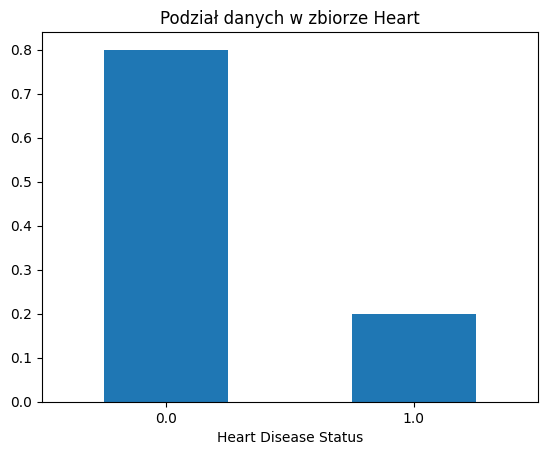

In [ ]:
(df_heart['Heart Disease Status'] \
 .value_counts(normalize=True)\
 .plot(kind='bar'))
plt.xticks(rotation=0)
plt.title("Podział danych w zbiorze Heart")
plt.show()

Niezrównoważony podział danych: 80% - 20%. Tylko 20% próby stanowią osoby z chorobą serca. Może to wpłynąć na wyniki klasyfikacji i należy zastosować metody zbalansowanych danych w zbiorze.

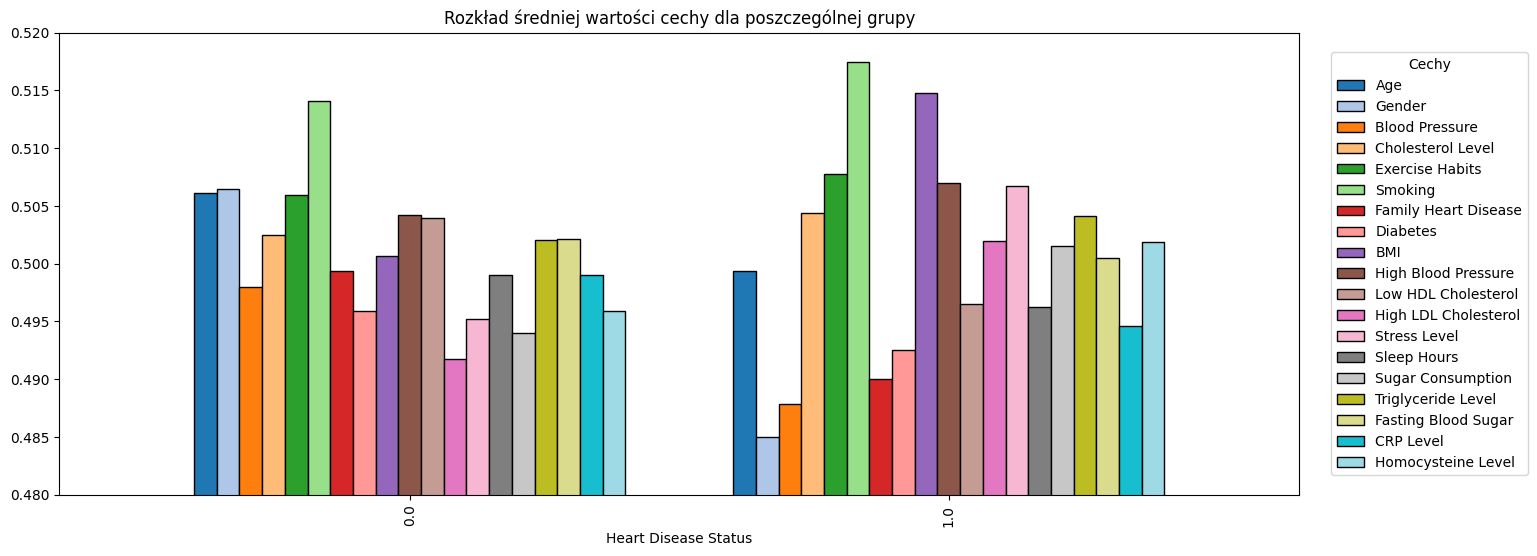

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))
df_heart.groupby("Heart Disease Status").mean().plot.bar(
    ax=ax,
    cmap="tab20",
    edgecolor="black",
    width=0.8
)

plt.ylim(0.48, 0.52)

ax.legend(loc="center left", fontsize=10, bbox_to_anchor=(1.02,0.5),title="Cechy")
plt.title("Rozkład średniej wartości cechy dla poszczególnej grupy")
plt.show()

Na podstawie wykresu możemy stwierdzić pewne założenia związane z chorobami serca:
- częściej chorują kobiety (ze względu na binarną klasyfikację 0 widzimy, że średnia jest znacznie niższa - co wskazuje na większy udział kobiet)
- osoby chore częściej palą papierosy
- częściej występuje nadciśnienie oraz podwyższony poziom stresu
- wyższy poziom BMI
- `High LDL Cholesterol`, czyli czynnik ryzyka miażdżycy, jest wyraźnie wyższy
- nieco niższy poziom snu niż w grupie zdrowej

Co ciekawe w naszej analizie - osoby zdrowe mają częściej wyższy poziom ciśnienia niż osoby chore.

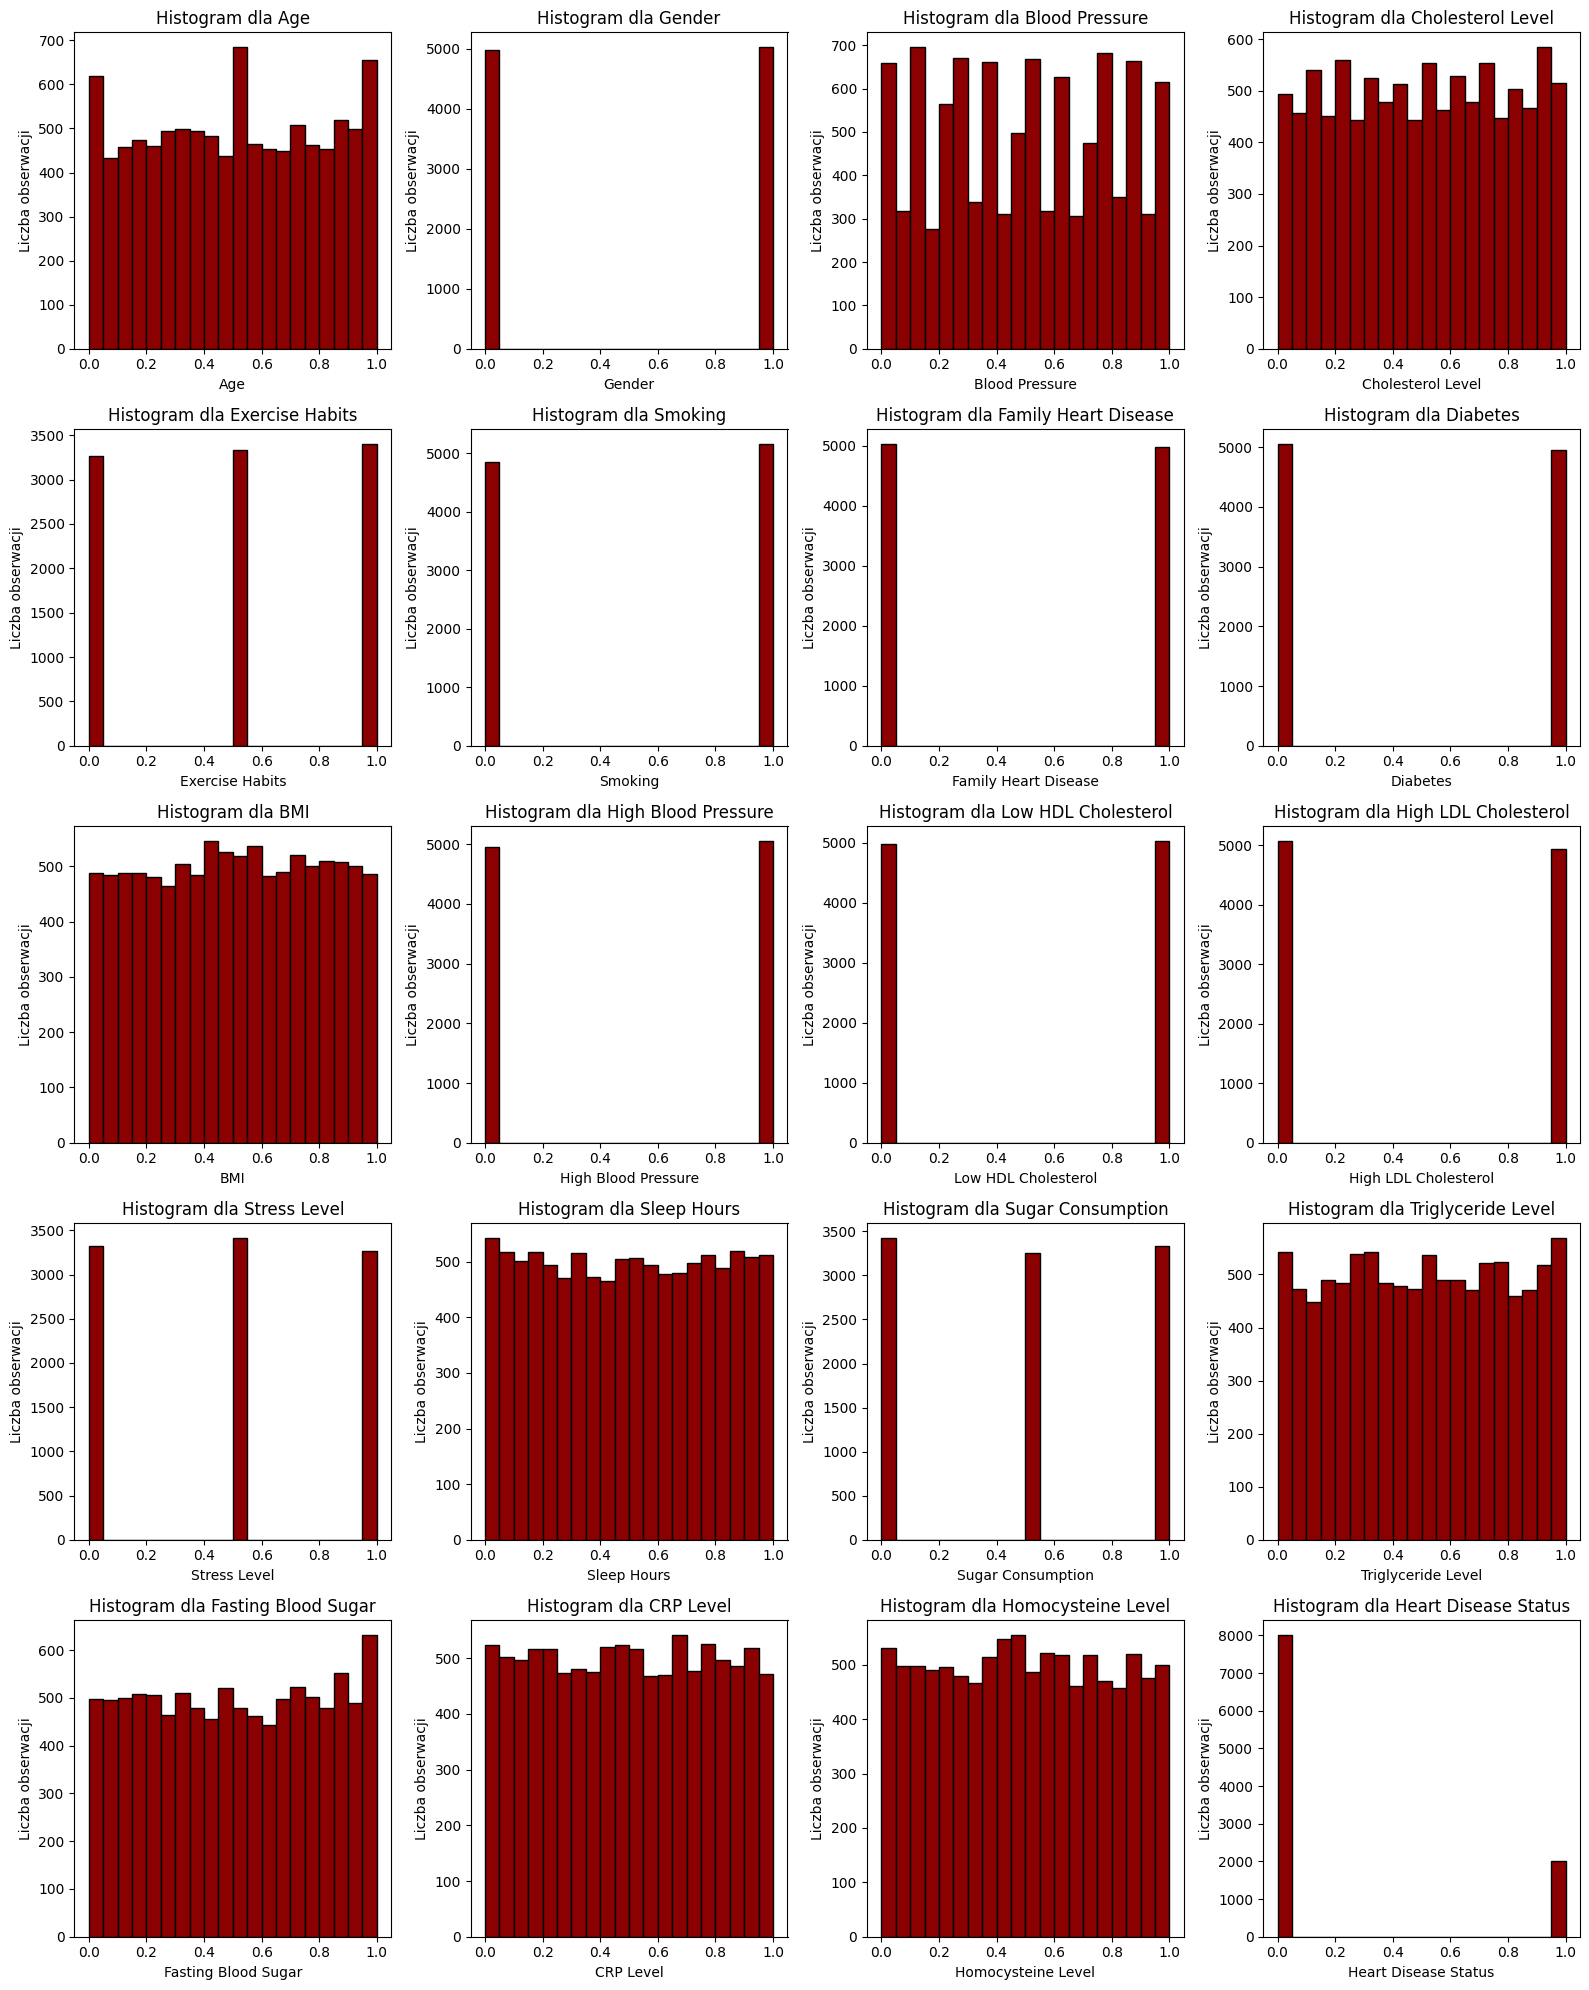

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(16, 20))
axes = axes.flatten()

#Histogram dla każdej kolumny w zbiorze df_heart
for i, column in enumerate(df_heart.columns):
    axes[i].hist(df_heart[column], bins=20, edgecolor='black', color='darkred')
    axes[i].set_title(f"Histogram dla {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Liczba obserwacji")

plt.tight_layout()
plt.show()

Na podstawie histogramów widać dwa podziały: zmienne kategoryczne oraz zmienne ciągłe.

Zmienna `Age` wskazuje na dobrą reprezentację każdej grupy wiekowej. Widać jedynie lekkie skoki w liczebności na krańcach oraz w samym środku. Natomiast zmienna z ciśnieniem krwi wskazuje na prawie równomierny rozkład. Co druga wartość ma mniejszą liczebność niż poprzednia.

Wszystkie zmienne kategoryczne, oprócz zmiennej decyzyjnej `Heart Disease Status`, mają wartości równomiernie rozłożone.

### Korelacja

In [ ]:
df_heart.corr()

Age    Gender  Blood Pressure  Cholesterol Level  \
Age                   1.000000 -0.008624       -0.020742           0.011340   
Gender               -0.008624  1.000000       -0.003199          -0.012588   
Blood Pressure       -0.020742 -0.003199        1.000000          -0.011995   
Cholesterol Level     0.011340 -0.012588       -0.011995           1.000000   
Exercise Habits      -0.009359 -0.004477        0.006068           0.000575   
Smoking              -0.000245 -0.010935       -0.001849           0.008471   
Family Heart Disease -0.019201 -0.001378        0.004751          -0.008917   
Diabetes              0.010546  0.004442        0.022305           0.003696   
BMI                   0.011198 -0.015982        0.005391           0.021942   
High Blood Pressure  -0.000409  0.014359        0.010009          -0.008194   
Low HDL Cholesterol  -0.014847  0.006178       -0.003852          -0.004698   
High LDL Cholesterol  0.000160 -0.011146       -0.000716           0.000237   
Stress Level         -0.004964  0.009265        0.009536           0.003662   
Sleep Hours           0.002474  0.001023        0.001150           0.011155   
Sugar Consumption    -0.020731  0.005404       -0.006525           0.010961   
Triglyceride Level   -0.008090  0.015741        0.008091           0.001446   
Fasting Blood Sugar  -0.006004 -0.001471       -0.011967           0.000060   
CRP Level             0.008753 -0.015084       -0.010113          -0.017518   
Homocysteine Level   -0.007069  0.006026       -0.003239          -0.006269   
Heart Disease Status -0.009239 -0.017200       -0.013877           0.002706   

                      Exercise Habits   Smoking  Family Heart Disease  \
Age                         -0.009359 -0.000245             -0.019201   
Gender                      -0.004477 -0.010935             -0.001378   
Blood Pressure               0.006068 -0.001849              0.004751   
Cholesterol Level            0.000575  0.008471             -0.008917   
Exercise Habits              1.000000  0.007630             -0.002862   
Smoking                      0.007630  1.000000              0.001149   
Family Heart Disease        -0.002862  0.001149              1.000000   
Diabetes                     0.007987 -0.012522             -0.008649   
BMI                          0.005051 -0.010356             -0.005300   
High Blood Pressure         -0.002843  0.020126              0.018249   
Low HDL Cholesterol          0.009721  0.012458              0.006825   
High LDL Cholesterol         0.008275 -0.009638              0.011339   
Stress Level                -0.002170  0.003013             -0.005820   
Sleep Hours                 -0.006890  0.002433              0.003056   
Sugar Consumption           -0.002365 -0.003816              0.001406   
Triglyceride Level          -0.005612  0.005585             -0.000423   
Fasting Blood Sugar         -0.006653  0.006272             -0.005962   
CRP Level                    0.013302 -0.003860              0.017143   
Homocysteine Level           0.006751 -0.011384              0.008804   
Heart Disease Status         0.001776  0.002701             -0.007500   

                      Diabetes       BMI  High Blood Pressure  \
Age                   0.010546  0.011198            -0.000409   
Gender                0.004442 -0.015982             0.014359   
Blood Pressure        0.022305  0.005391             0.010009   
Cholesterol Level     0.003696  0.021942            -0.008194   
Exercise Habits       0.007987  0.005051            -0.002843   
Smoking              -0.012522 -0.010356             0.020126   
Family Heart Disease -0.008649 -0.005300             0.018249   
Diabetes              1.000000 -0.005019            -0.002308   
BMI                  -0.005019  1.000000             0.009792   
High Blood Pressure  -0.002308  0.009792             1.000000   
Low HDL Cholesterol  -0.009353 -0.000221             0.010953   
High LDL Cholesterol -0.002119  0.015258            -

In [ ]:
df_heart.corr(method = "spearman")

Age    Gender  Blood Pressure  Cholesterol Level  \
Age                   1.000000 -0.008790       -0.020553           0.011304   
Gender               -0.008790  1.000000       -0.003106          -0.012506   
Blood Pressure       -0.020553 -0.003106        1.000000          -0.012059   
Cholesterol Level     0.011304 -0.012506       -0.012059           1.000000   
Exercise Habits      -0.009307 -0.004536        0.006189           0.000610   
Smoking              -0.000052 -0.010935       -0.001917           0.008405   
Family Heart Disease -0.019176 -0.001378        0.004769          -0.008966   
Diabetes              0.010703  0.004442        0.022254           0.003768   
BMI                   0.011283 -0.015811        0.005381           0.021991   
High Blood Pressure  -0.000482  0.014359        0.009960          -0.008200   
Low HDL Cholesterol  -0.014839  0.006178       -0.003833          -0.004650   
High LDL Cholesterol  0.000212 -0.011146       -0.000820           0.000200   
Stress Level         -0.004888  0.009241        0.009566           0.003742   
Sleep Hours           0.002534  0.001031        0.001092           0.011073   
Sugar Consumption    -0.020711  0.005376       -0.006507           0.010922   
Triglyceride Level   -0.008159  0.015803        0.008001           0.001280   
Fasting Blood Sugar  -0.006015 -0.001417       -0.011954           0.000059   
CRP Level             0.008886 -0.015139       -0.010228          -0.017577   
Homocysteine Level   -0.007013  0.006220       -0.003320          -0.006319   
Heart Disease Status -0.009439 -0.017200       -0.013902           0.002707   

                      Exercise Habits   Smoking  Family Heart Disease  \
Age                         -0.009307 -0.000052             -0.019176   
Gender                      -0.004536 -0.010935             -0.001378   
Blood Pressure               0.006189 -0.001917              0.004769   
Cholesterol Level            0.000610  0.008405             -0.008966   
Exercise Habits              1.000000  0.007744             -0.002830   
Smoking                      0.007744  1.000000              0.001149   
Family Heart Disease        -0.002830  0.001149              1.000000   
Diabetes                     0.007947 -0.012522             -0.008649   
BMI                          0.005042 -0.010270             -0.005248   
High Blood Pressure         -0.002847  0.020126              0.018249   
Low HDL Cholesterol          0.009679  0.012458              0.006825   
High LDL Cholesterol         0.008171 -0.009638              0.011339   
Stress Level                -0.002154  0.002997             -0.005792   
Sleep Hours                 -0.006974  0.002368              0.003165   
Sugar Consumption           -0.002362 -0.003801              0.001401   
Triglyceride Level          -0.005659  0.005455             -0.000383   
Fasting Blood Sugar         -0.006641  0.006307             -0.006016   
CRP Level                    0.013220 -0.003797              0.017135   
Homocysteine Level           0.007071 -0.011320              0.008869   
Heart Disease Status         0.001739  0.002701             -0.007500   

                      Diabetes       BMI  High Blood Pressure  \
Age                   0.010703  0.011283            -0.000482   
Gender                0.004442 -0.015811             0.014359   
Blood Pressure        0.022254  0.005381             0.009960   
Cholesterol Level     0.003768  0.021991            -0.008200   
Exercise Habits       0.007947  0.005042            -0.002847   
Smoking              -0.012522 -0.010270             0.020126   
Family Heart Disease -0.008649 -0.005248             0.018249   
Diabetes              1.000000 -0.005021            -0.002308   
BMI                  -0.005021  1.000000             0.009699   
High Blood Pressure  -0.002308  0.009699             1.000000   
Low HDL Cholesterol  -0.009353 -0.000404             0.010953   
High LDL Cholesterol -0.002119  0.015222            -

In [ ]:
df_heart.corr(method = "kendall")

Age    Gender  Blood Pressure  Cholesterol Level  \
Age                   1.000000 -0.007234       -0.013945           0.007614   
Gender               -0.007234  1.000000       -0.002557          -0.010245   
Blood Pressure       -0.013945 -0.002557        1.000000          -0.008047   
Cholesterol Level     0.007614 -0.010245       -0.008047           1.000000   
Exercise Habits      -0.007223 -0.004277        0.004808           0.000442   
Smoking              -0.000043 -0.010935       -0.001578           0.006886   
Family Heart Disease -0.015781 -0.001378        0.003926          -0.007345   
Diabetes              0.008808  0.004442        0.018319           0.003086   
BMI                   0.007547 -0.012910        0.003560           0.014658   
High Blood Pressure  -0.000397  0.014359        0.008199          -0.006718   
Low HDL Cholesterol  -0.012212  0.006178       -0.003155          -0.003809   
High LDL Cholesterol  0.000174 -0.011146       -0.000675           0.000163   
Stress Level         -0.003847  0.008712        0.007413           0.002917   
Sleep Hours           0.001638  0.000842        0.000736           0.007362   
Sugar Consumption    -0.016115  0.005068       -0.005013           0.008396   
Triglyceride Level   -0.005497  0.012925        0.005467           0.000878   
Fasting Blood Sugar  -0.004055 -0.001164       -0.008084           0.000063   
CRP Level             0.006034 -0.012362       -0.006896          -0.011815   
Homocysteine Level   -0.004808  0.005079       -0.002164          -0.004138   
Heart Disease Status -0.007768 -0.017200       -0.011444           0.002217   

                      Exercise Habits   Smoking  Family Heart Disease  \
Age                         -0.007223 -0.000043             -0.015781   
Gender                      -0.004277 -0.010935             -0.001378   
Blood Pressure               0.004808 -0.001578              0.003926   
Cholesterol Level            0.000442  0.006886             -0.007345   
Exercise Habits              1.000000  0.007301             -0.002669   
Smoking                      0.007301  1.000000              0.001149   
Family Heart Disease        -0.002669  0.001149              1.000000   
Diabetes                     0.007493 -0.012522             -0.008649   
BMI                          0.003855 -0.008386             -0.004285   
High Blood Pressure         -0.002684  0.020126              0.018249   
Low HDL Cholesterol          0.009126  0.012458              0.006825   
High LDL Cholesterol         0.007704 -0.009638              0.011339   
Stress Level                -0.001916  0.002826             -0.005460   
Sleep Hours                 -0.005373  0.001934              0.002584   
Sugar Consumption           -0.002101 -0.003584              0.001321   
Triglyceride Level          -0.004363  0.004461             -0.000313   
Fasting Blood Sugar         -0.005107  0.005181             -0.004942   
CRP Level                    0.010133 -0.003100              0.013991   
Homocysteine Level           0.005433 -0.009244              0.007242   
Heart Disease Status         0.001640  0.002701             -0.007500   

                      Diabetes       BMI  High Blood Pressure  \
Age                   0.008808  0.007547            -0.000397   
Gender                0.004442 -0.012910             0.014359   
Blood Pressure        0.018319  0.003560             0.008199   
Cholesterol Level     0.003086  0.014658            -0.006718   
Exercise Habits       0.007493  0.003855            -0.002684   
Smoking              -0.012522 -0.008386             0.020126   
Family Heart Disease -0.008649 -0.004285             0.018249   
Diabetes              1.000000 -0.004100            -0.002308   
BMI                  -0.004100  1.000000             0.007920   
High Blood Pressure  -0.002308  0.007920             1.000000   
Low HDL Cholesterol  -0.009353 -0.000330             0.010953   
High LDL Cholesterol -0.002119  0.012430            -

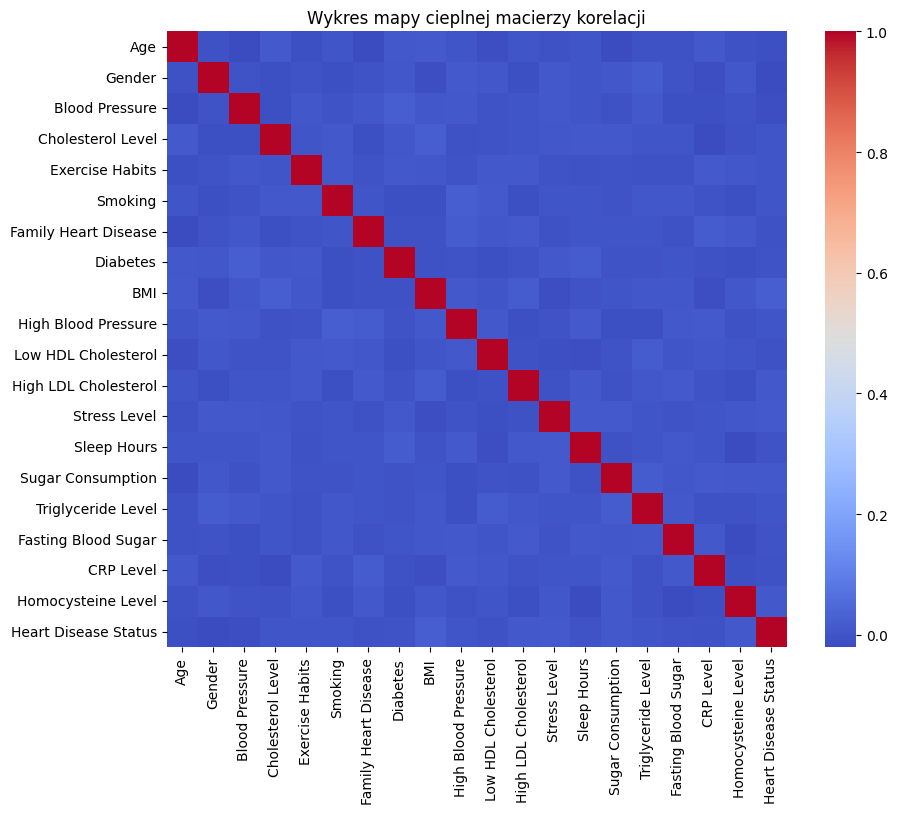

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_heart.corr(), cmap="coolwarm")
plt.title("Wykres mapy cieplnej macierzy korelacji")
plt.show()

Na podstawie mapy cieplnej korelacji możemy stwierdzić że w całym zbiorze występuje brak korelacji. Zmienne nie wykazują silnych zależności liniowych. Żadna korelacja nie wskazała na znaczną poprawę. Sugeruje to, że dane są niezależne od siebie, co jest korzystne dla modeli predykcyjnych.

Może to oznaczać, że choroba serca zależy od wielu czynników jednocześnie lub że zależności są nieliniowe.

### PCA - Principal Component Analysis

In [ ]:
pca = PCA(n_components=2)

heart_pca = pca.fit_transform(df_heart.drop(columns="Heart Disease Status"))
df_heart_pca = pd.DataFrame(heart_pca, columns=["pca_0", "pca_1"])
df_heart_pca.sample(n=5)

pca_0     pca_1
2524  0.911848  0.552708
5733  0.111161 -0.151429
9303 -0.226480 -0.063266
6335 -0.609656  0.359614
8116  0.108164 -0.598648

In [ ]:
colors, mapping = pd.factorize(df_heart["Heart Disease Status"])
colors, mapping

(array([0, 0, 0, ..., 1, 1, 1]), Index([0.0, 1.0], dtype='float64'))

<Axes: xlabel='pca_0', ylabel='pca_1'>

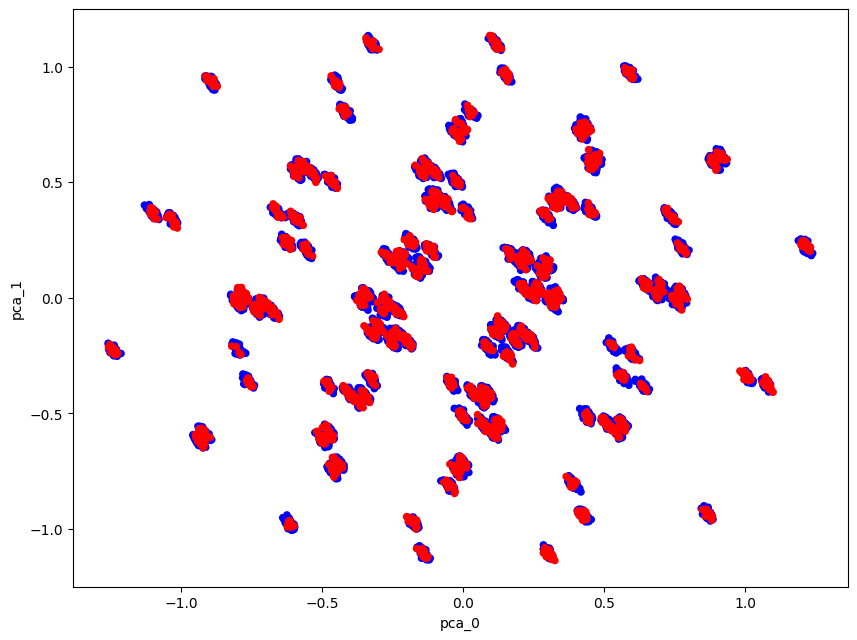

In [ ]:
df_heart_pca.plot.scatter(x="pca_0", y="pca_1",
                          c=colors, cmap="bwr", colorbar=False,
                          figsize=(10.0, 7.5))

Brak wyraźnego skupienia sugeruje, że dane nie są łatwo separowalne w przestrzeni głównych komponentów. Wartości pokrywają się i trudno je rozdzielić, co może utrudniać dalszą klasyfikację.

Dane są rozproszone równomiernie wokół środka układu współrzędnych (0,0).

### t-SNE - t-distributed Stochastic Neighbor Embedding

In [ ]:
tsne = TSNE(n_components=2)

heart_tsne = tsne.fit_transform(df_heart.drop(columns="Heart Disease Status"))
df_heart_tsne = pd.DataFrame(heart_tsne, columns=["tsne_0", "tsne_1"])
df_heart_tsne.sample(n=5)

tsne_0     tsne_1
1239  37.740067  -1.800480
2932  23.844927  62.919395
1787   5.753891 -53.721775
1904  16.217831 -78.529037
4149 -19.861713  49.681488

In [ ]:
colors, mapping = pd.factorize(df_heart["Heart Disease Status"])
colors, mapping

(array([0, 0, 0, ..., 1, 1, 1]), Index([0.0, 1.0], dtype='float64'))

<Axes: xlabel='tsne_0', ylabel='tsne_1'>

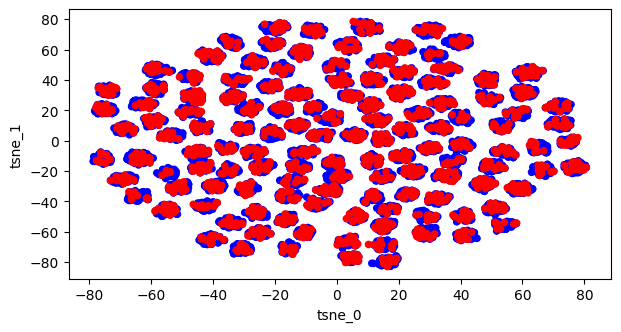

In [ ]:
df_heart_tsne.plot.scatter(x="tsne_0", y="tsne_1",
                            c=colors, cmap="bwr", colorbar=False,
                            figsize=(7.0, 3.5))

Wizualizacja t-SNE pokazuje, że dane dotyczące pacjentów z chorobą serca i bez niej nie tworzą wyraźnie odseparowanych klastrów w przestrzeni 2D. Nie da się oddzielić wartości z jednej grupy od wartości z drugiej grupy. Oznacza to, że klasy te mają bardzo podobne cechy, co może utrudniać skuteczne rozdzielenie ich za pomocą klasyfikatora.

### Regresja logistyczna

In [ ]:
X_heart = df_heart.drop('Heart Disease Status', axis=1)  #Zmienne niezależne
y_heart = df_heart['Heart Disease Status']  #Zmienna zależna
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_heart, y_heart, test_size=0.3, random_state=123)

In [ ]:
# Model regresji logistycznej
model_log_heart = LogisticRegression()
model_log_heart.fit(X_train_h, y_train_h)
y_pred_log_heart = model_log_heart.predict(X_test_h)

Macierz błędów dla regresji logistycznej

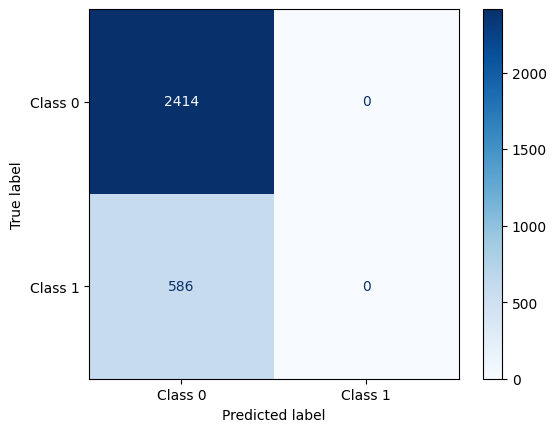

In [ ]:
cm_heart = confusion_matrix(y_test_h, y_pred_log_heart)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_heart,
                              display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.show()

Model przewiduje wyłącznie klasę 0 - czyli brak chorób serca. Niezależnie od rzeczywistej klasy, model zawsze klasyfikuje instancję jako należącą do klasy 0.

Model poprawnie zidentyfikował wszystkie 2414 przypadki, które faktycznie należały do klasy 0. Natomiast wszystkie 586 instancji, które w rzeczywistości należały do klasy 1, zostały błędnie zaklasyfikowane jako klasa 0 (FN = 586).

W tym przypadku mamy wysoką, ale całkowicie niepoprawną dokładność. Jego czułość dla klasy 1 wynosi 0% co skutkuje brakiem klasyfikacji dla tej klasy. Sprawia to, że nasz model jest bezużyteczny - nie przewiduje rozwiązań w klasie 1 - czyli dla chorób serca.

Taki wynik jest typowy dla danej sytuacji, ponieważ zbiór danych jest niezbalansowany. Model nauczył się tylko klasy 0. Należy dostosować wagę klas, aby model mógł nauczyć się również klasy 1.

In [ ]:
# Model regresji logistycznej dla klasyfikacji zbalansowanej
model_log_heart = LogisticRegression(class_weight='balanced')
model_log_heart.fit(X_train_h, y_train_h)

y_pred_log_heart = model_log_heart.predict(X_test_h)

Macierz błędów dla zbioru treningowego

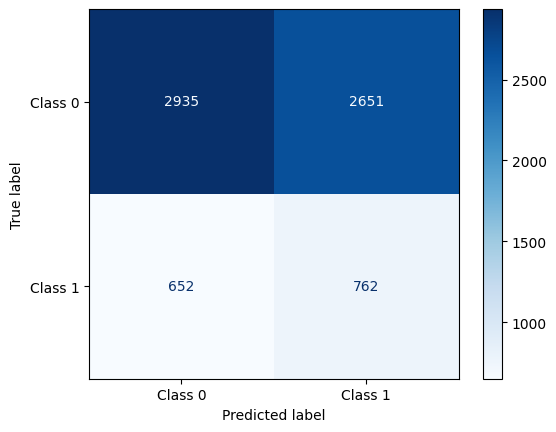

In [ ]:
y_pred_train = model_log_heart.predict(X_train_h)

cm_h = confusion_matrix(y_train_h, y_pred_train)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm_h,
                              display_labels=["Class 0", "Class 1"])
matrix.plot(cmap="Blues")
plt.show()

Ogólna wydajność modelu jest słaba: Model poprawnie sklasyfikował 3697 instancji z 7000 instancji. Daje to ogólną dokładność około 52.8%, co jest niewiele lepsze od losowego zgadywania w problemie binarnym.

Model ma wyraźne trudności w odróżnianiu klasy 0 od klasy 1. Występuje niska precyzja dla klasy 1.
Nawet na danych treningowych model miał już problemy, co może skutkować dalszymi problemami dla danych testowych.

Mimo, że jest poprawa w klasyfikacji danych dla klasy 1, model pogorszył się co do egzekwowania klasy 0.

Macierz błędów dla zbioru testowego dla regresji logistycznej

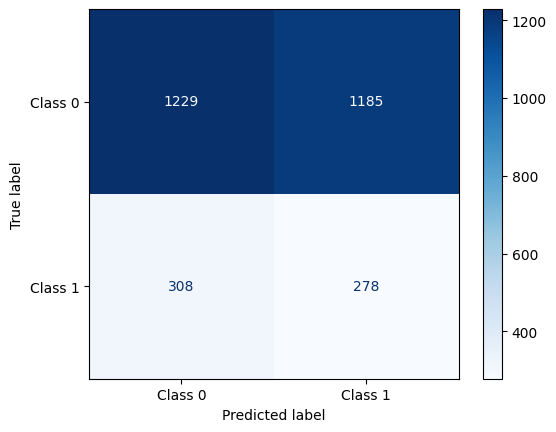

In [ ]:
cm_h = confusion_matrix(y_test_h, y_pred_log_heart)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm_h,
                              display_labels=["Class 0", "Class 1"])
matrix.plot(cmap="Blues")
plt.show()

Model regresji logistycznej wykazuje problemy z poprawną klasyfikacją obserwacji, szczególnie dla klasy pozytywnej - klasy 1. Na zbiorze testowym poprawnie sklasyfikował jedynie 1507 z 3000 przypadków, co wskazuje na ogólną skuteczność na poziomie około 50%. Szczególnie niepokojąca jest niska skuteczność w przewidywaniu klasy 1 – większość przypisanych do niej obserwacji okazała się błędna (fałszywie pozytywne).

Można zauważyć, że mimo poprawy względem wcześniejszych wyników (gdzie model w ogóle nie rozpoznawał klasy 1), nadal istnieje znaczna dysproporcja w skuteczności między klasami. To sugeruje, że nadal model może być niezbalansowany.

Metryki oceny modelu

In [ ]:
accuracy_h = accuracy_score(y_test_h, y_pred_log_heart)
precision_h = precision_score(y_test_h, y_pred_log_heart)
recall_h = recall_score(y_test_h, y_pred_log_heart)
f1_h = f1_score(y_test_h, y_pred_log_heart)

mse_h = mean_squared_error(y_test_h, y_pred_log_heart)
rmse_h = np.sqrt(mse_h)
r2_h = r2_score(y_test_h, y_pred_log_heart)

print(f"Accuracy: {accuracy_h}")
print(f"Precision: {precision_h}")
print(f"Recall: {recall_h}")
print(f"F1-Score: {f1_h}")
print(f"MSE: {mse_h}")
print(f"RMSE: {rmse_h}")
print(f"R^2 Score: {r2_h}")

Accuracy: 0.5023333333333333
Precision: 0.1900205058099795
Recall: 0.47440273037542663
F1-Score: 0.27135187896534896
MSE: 0.49766666666666665
RMSE: 0.7054549359574052
R^2 Score: -2.16625712920365


Model osiągnął dokładność na poziomie 50%, co oznacza, że klasyfikuje poprawnie niewiele lepiej niż losowe zgadywanie. Ma poważne problemy z rozróżnianiem klas (w szczególności z klasą 1).

Wartość precision sugeruje, że tylko 19% przypadków zaklasyfikowanych przez model jako klasa 1 było trafnych. Oznacza to dużą liczbę fałszywie pozytywnych predykcji.
Model wykrył około 47% wszystkich przypadków klasy 1, co oznacza, że pomija ponad połowę prawdziwych przypadków tej klasy.

F1-score na poziomie 0.27 co potwierdza, że model ma trudności z rozpoznaniem klasy 1 w sposób zrównoważony.

Wartość R^2 = -2.16 świadczy o tym, że model nie wyjaśnia zmienności danych, a wręcz gorzej dopasowuje się niż prosta średnia. Jest to wyraźny sygnał, że regresja logistyczna w tej formie nie sprawdza się dla tego zbioru.
Wysokie wartości błędów (MSE = 0.498, RMSE = 0.705) są konsekwencją licznych błędów klasyfikacji – zarówno fałszywie pozytywnych, jak i negatywnych.

### Regresja logistyczna z walidacją krzyżową

In [ ]:
X_heart = df_heart.drop('Heart Disease Status', axis=1)  #Zmienne niezależne
y_heart = df_heart['Heart Disease Status']  #Zmienna zależna

# Model regresji logistycznej
lr_heart = LogisticRegression(penalty=None, max_iter=10000, class_weight="balanced") #class_weight = 'balanced', ze względu na niezrównoważony podział danych
scores_log_heart = cross_validate(
    lr_heart, X_heart, y_heart, cv=10, return_train_score=True,
    scoring=("accuracy", "precision", "recall", "f1")
)
scores_log_heart

{'fit_time': array([0.01679254, 0.02121902, 0.01749063, 0.01499128, 0.01732135,
        0.01645446, 0.01527333, 0.01541734, 0.01556134, 0.01560712]),
 'score_time': array([0.01154208, 0.01150608, 0.01284337, 0.01187372, 0.01098633,
        0.01114345, 0.01091576, 0.01103878, 0.01253176, 0.01197886]),
 'test_accuracy': array([0.503, 0.508, 0.486, 0.513, 0.473, 0.515, 0.5  , 0.497, 0.51 ,
        0.497]),
 'train_accuracy': array([0.52177778, 0.52311111, 0.52055556, 0.52255556, 0.52477778,
        0.52155556, 0.526     , 0.523     , 0.52      , 0.52311111]),
 'test_precision': array([0.18736842, 0.19834711, 0.18346774, 0.20533881, 0.16969697,
        0.20496894, 0.20817121, 0.19760479, 0.19537815, 0.18762887]),
 'train_precision': array([0.21350114, 0.21500457, 0.21296508, 0.21265823, 0.21561424,
        0.21155617, 0.21759047, 0.21638225, 0.21634399, 0.21513489]),
 'test_recall': array([0.445, 0.48 , 0.455, 0.5  , 0.42 , 0.495, 0.535, 0.495, 0.465,
        0.455]),
 'train_recall': arra

Model osiągnął średnią dokładność około 50% na zbiorze testowym. Wyniki w poszczególnych iteracjach walidacji krzyżowej wahały się od 47.3% do 51.5%. Model ma trudności z poprawnym klasyfikowaniem, co sugeruje, że może mieć problem z wykrywaniem klasy 1.
Na zbiorze treningowym accuracy była na poziomie średnio 52%, co jest nieco lepszym wynikiem niż na zbiorze testowym, jednak model nadal dobrze nie przewiduje danych.

Precyzja zmieniała się między 16.9% a 21%, co wskazuje na dużą liczbę fałszywych pozytywów. Na zbiorze treningowym utrzymywała się na poziomie 21%.

Średnia wartość recallu wynosi około 46% na zbiorze testowym, co oznacza, że model wykrył około 46% przypadków klasy 1. Chociaż recall jest wyższy niż precyzja, to wciąż pozostaje na niskim poziomie, co wskazuje na pomijanie wielu rzeczywistych przypadków klasy 1. Na zbiorze treningowym była nieco wyższa i wynosiła średnio 52% co wskazuje na wyższą skuteczność, jednak jest to nadal metryka, która odbiega od idealnych wyników.

Wynik F1-score na danych treningowych wynosi około 30%, a na danych testowym około 27%. Oznacza to, że model nie radzi sobie dobrze w uzyskiwaniu równowagi między precyzją a recall. Wyniki w poszczególnych iteracjach wahały się między 24% a 29% co wskazuje na słabą wydajność modelu w rozpoznawaniu klasy 1.

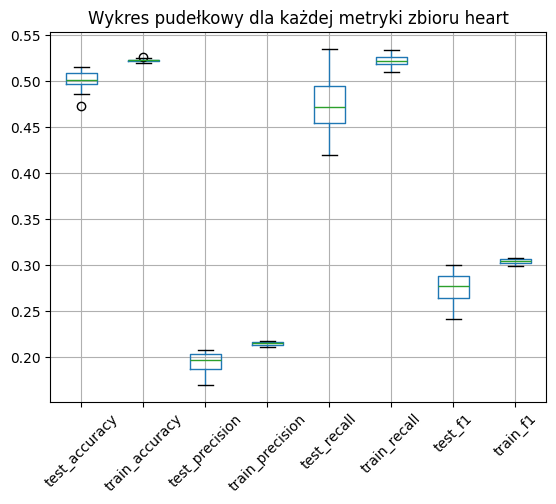

In [ ]:
scores_logistic_df = pd.DataFrame(scores_log_heart)
scores_logistic_df.drop(columns=["fit_time", "score_time"]).boxplot()
plt.title("Wykres pudełkowy dla każdej metryki zbioru heart")
plt.xticks(rotation=45)
plt.show()

Wszystkie metryki, zarówno dla zbioru treningowego, jak i testowego, osiągają stosunkowo niskie wartości. Dokładność (accuracy) oscyluje wokół 50-53%.

Dla każdej metryki wyniki na zbiorze treningowym są nieznacznie lepsze i znacznie bardziej stabilne (węższe pudełka i krótsze wąsy) niż na zbiorze testowym. Sugeruje to, że model nauczył się pewnych wzorców specyficznych dla danych treningowych, które nie generalizują się w pełni na nowe dane.

Szczególnie metryki test_recall i test_f1 wykazują dużą rozpiętość wyników, co wskazuje, że wydajność modelu na różnych podzbiorach danych testowych jest niestabilna.

### Ranking istotności cech

In [ ]:
selector_heart = RFECV(lr_heart, step=1, min_features_to_select=1,
                        cv=5, scoring="f1")
selector_heart.fit(X_heart, y_heart)

RFECV(cv=5,
      estimator=LogisticRegression(class_weight='balanced', max_iter=10000,
                                   penalty=None),
      scoring='f1')

In [ ]:
selected_features_heart = pd.DataFrame({
    "selected": selector_heart.support_,
    "ranking": selector_heart.ranking_
}, index=X_heart.columns)
selected_features_heart

selected  ranking
Age                       True        1
Gender                    True        1
Blood Pressure            True        1
Cholesterol Level        False       10
Exercise Habits          False       14
Smoking                  False       12
Family Heart Disease     False        5
Diabetes                 False       13
BMI                       True        1
High Blood Pressure      False       11
Low HDL Cholesterol      False        7
High LDL Cholesterol     False        4
Stress Level              True        1
Sleep Hours              False        6
Sugar Consumption        False        3
Triglyceride Level       False        8
Fasting Blood Sugar      False        9
CRP Level                False        2
Homocysteine Level        True        1

In [ ]:
feature_names_heart = selected_features_heart[selected_features_heart["selected"] == True].index
feature_names_heart

Index(['Age', 'Gender', 'Blood Pressure', 'BMI', 'Stress Level',
       'Homocysteine Level'],
      dtype='object')

Na podstawie algorytmu rankingu istotności cech jesteśmy w stanie zmniejszyć nasz zbiór danych tylko do cech istotnych dla modelu. Oznacza to, że możemy znacząco poprawić naszą klasyfikację za pomocą zawęzienia liczby kolumn.
Zbiór df_heart zawęził się do cech: `Age`, `Gender`, `Blood Pressure`, `BMI`, `Stress Level`, `Homocysteine Level`.

In [ ]:
#zapisanie zbioru danych z wybranymi cechami
df_heart_new = df_heart[feature_names_heart.tolist() + ["Heart Disease Status"]]
df_heart_new

Age  Gender  Blood Pressure       BMI  Stress Level  \
0     0.612903     1.0        0.550000  0.317756           0.5   
1     0.822581     0.0        0.433333  0.328222           1.0   
2     0.451613     1.0        0.100000  0.538899           0.0   
3     0.225806     0.0        0.033333  0.278604           1.0   
4     0.677419     1.0        0.766667  0.112914           1.0   
...        ...     ...             ...       ...           ...   
9995  0.112903     0.0        0.266667  0.035735           1.0   
9996  0.322581     1.0        0.866667  0.629894           1.0   
9997  0.887097     1.0        0.533333  0.404521           0.0   
9998  0.080645     1.0        0.366667  0.771169           1.0   
9999  0.322581     0.0        0.133333  0.323198           0.5   

      Homocysteine Level  Heart Disease Status  
0               0.492507                   0.0  
1               0.953319                   0.0  
2               0.415412                   0.0  
3               0.064120                   0.0  
4               0.210260                   0.0  
...                  ...                   ...  
9995            0.942193                   1.0  
9996            0.314390                   1.0  
9997            0.299503                   1.0  
9998            0.458253                   1.0  
9999            0.080559                   1.0  

[10000 rows x 7 columns]

In [ ]:
colors, mapping = pd.factorize(df_heart_new["Heart Disease Status"])
colors, mapping

(array([0, 0, 0, ..., 1, 1, 1]), Index([0.0, 1.0], dtype='float64'))

Zależności pomiędzy dwoma zmiennymi

In [ ]:
columns = df_heart_new.columns[:-1]
fig, axes = plt.subplots(3, 5, figsize=(24, 16))
axes = axes.flatten()

for idx, (x, y) in enumerate(itertools.combinations(columns, 2)):
    df_heart_new.plot.scatter(x=x, y=y, c=colors, cmap="coolwarm", colorbar=False, ax=axes[idx])
    axes[idx].set_title(f"{x} i {y}")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Nie widać wyraźnego związku między żadną ze zmiennych - punkty są równomiernie rozłożone.

Dokładniejsze porównanie dla 4 zmiennych kategorycznych:

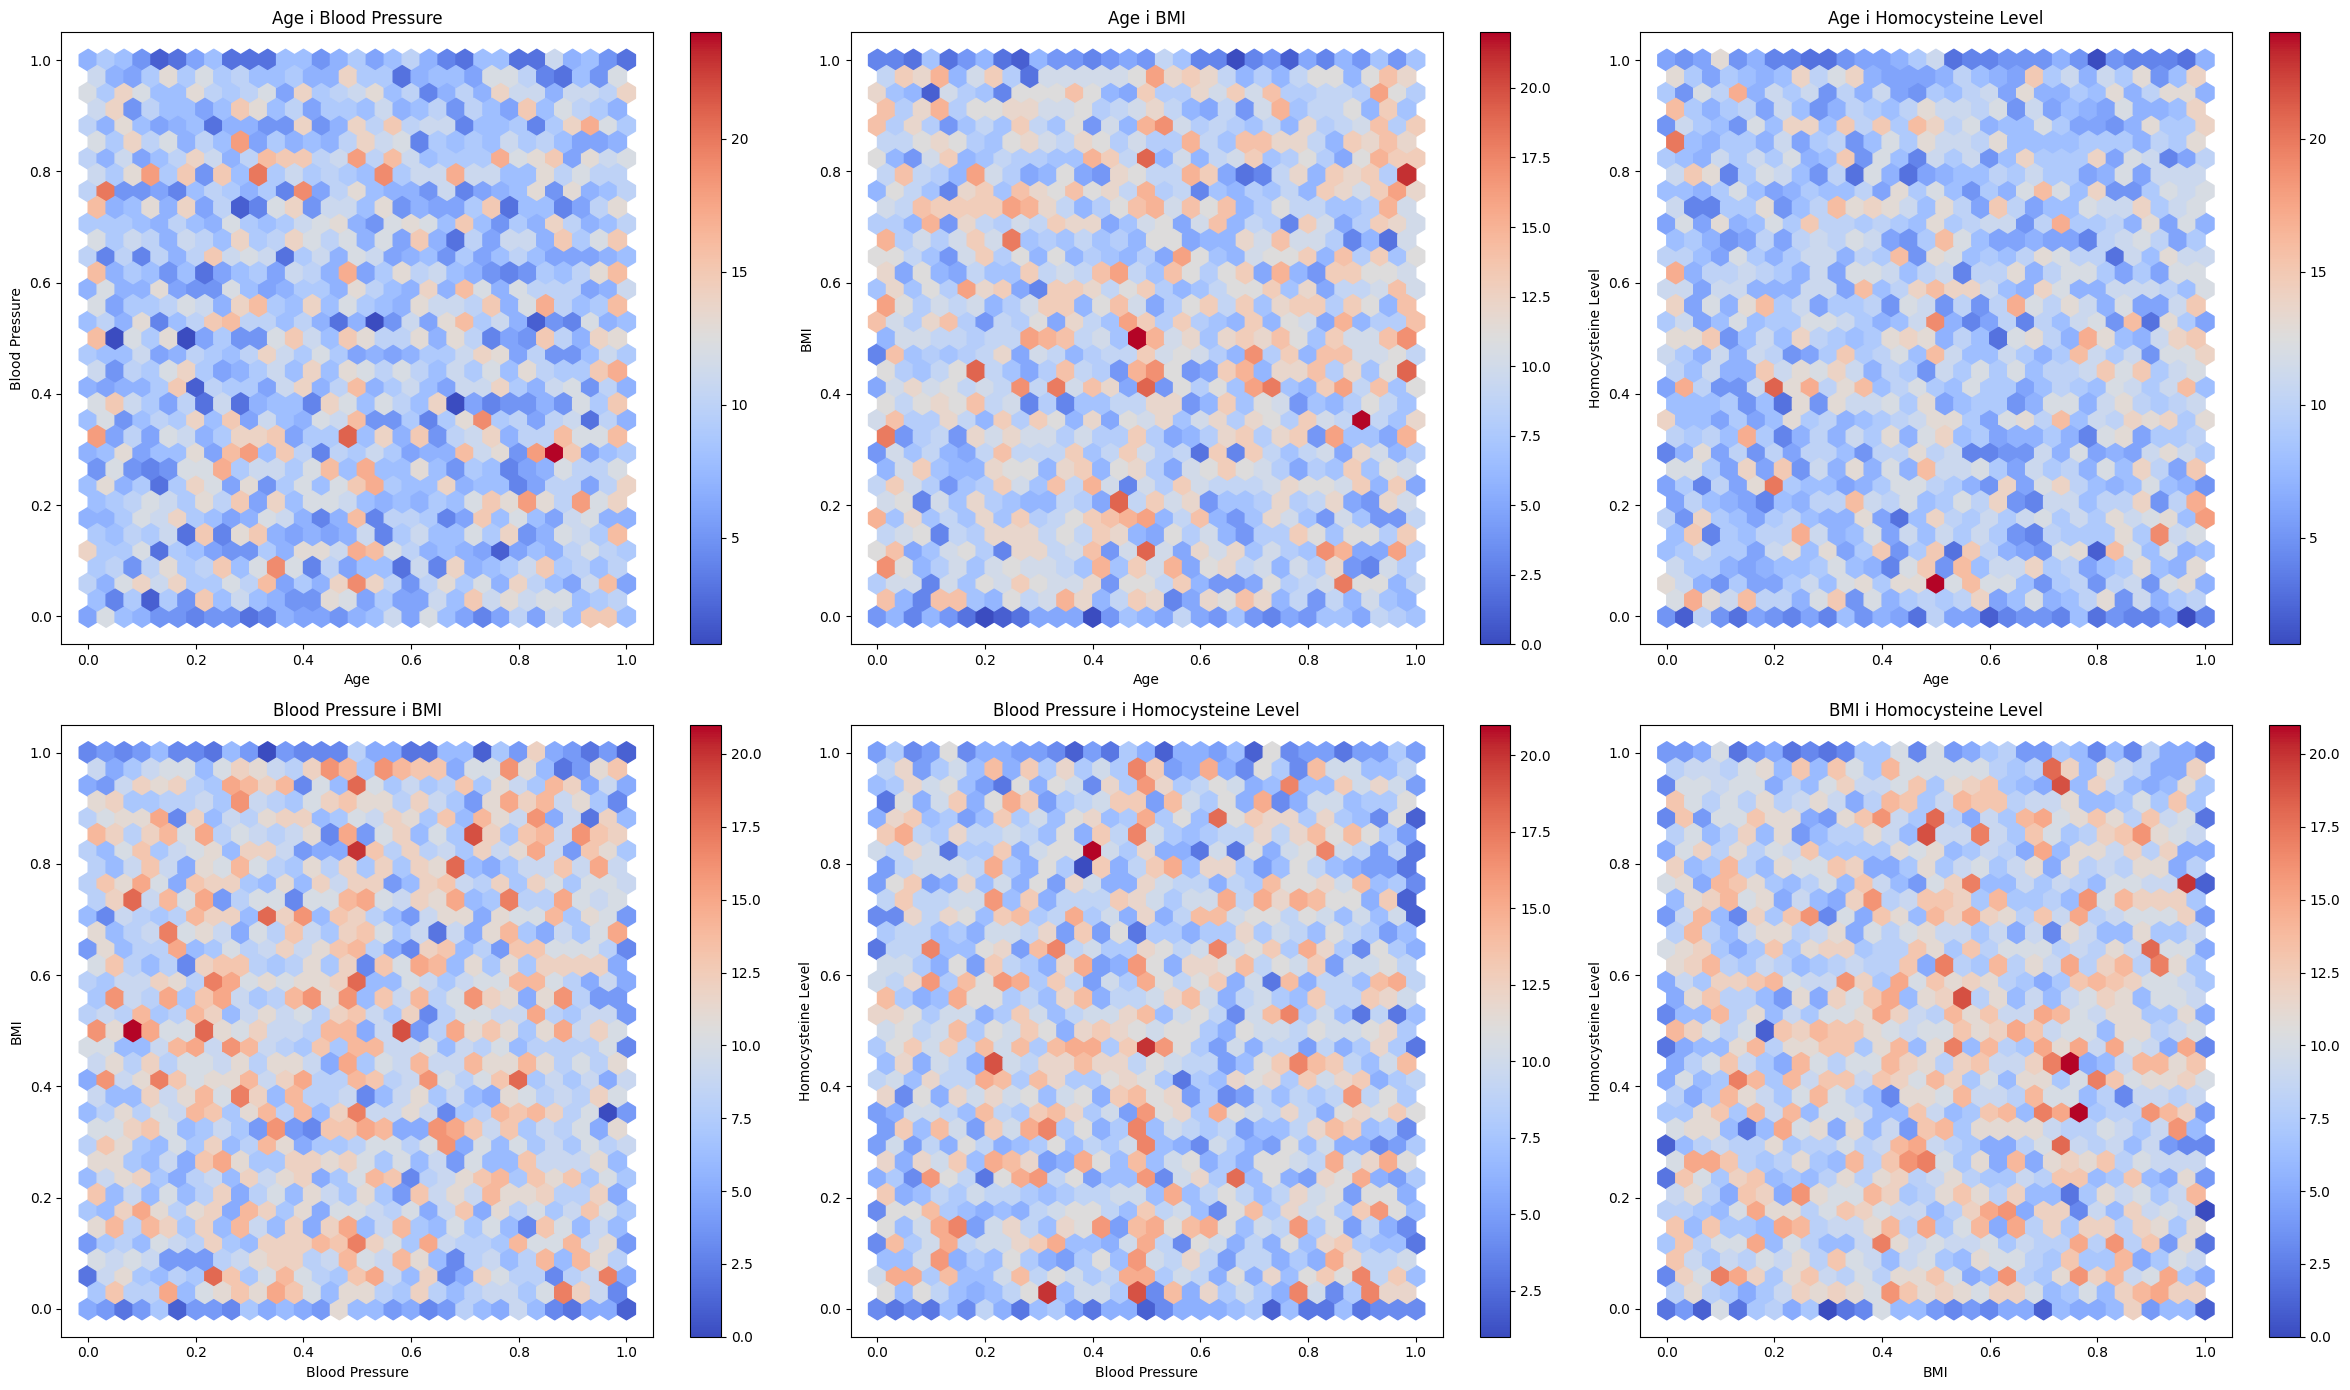

In [ ]:
columns = ['Age', 'Blood Pressure', 'BMI', 'Homocysteine Level']
#wszystkie kombinacje
combinations = list(itertools.combinations(columns, 2))

fig, axes = plt.subplots(2, 3, figsize=(24, 14))
axes = axes.flatten()

for idx, (x, y) in enumerate(combinations):
    hb = axes[idx].hexbin(df_heart_new[x], df_heart_new[y], gridsize=30, cmap="coolwarm")
    axes[idx].set_xlabel(x)
    axes[idx].set_ylabel(y)
    axes[idx].set_title(f"{x} i {y}")
    fig.colorbar(hb, ax=axes[idx])

plt.tight_layout()
plt.show()

Brak silnych zależności liniowych między parami zmiennych. Dane są dobrze rozproszone i zrównoważone.

### Regresja logistyczna dla cech istotnych

In [ ]:
X_heart_ist = df_heart_new.drop('Heart Disease Status', axis=1)
y_heart_ist = df_heart_new['Heart Disease Status']
X_train_h_ist, X_test_h_ist, y_train_h_ist, y_test_h_ist = train_test_split(X_heart_ist, y_heart_ist, test_size=0.3, random_state=123)

In [ ]:
# Model regresji logistycznej dla cech istotnych
model_heart_log_ist = LogisticRegression(class_weight="balanced")
model_heart_log_ist.fit(X_train_h_ist, y_train_h_ist)
y_pred_log_ist_h = model_heart_log_ist.predict(X_test_h_ist)

Macierz błędów

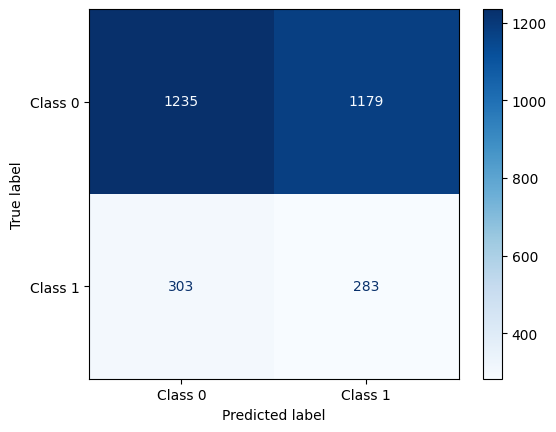

In [ ]:
cm_h_ist = confusion_matrix(y_test_h_ist, y_pred_log_ist_h)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm_h_ist,
                              display_labels=["Class 0", "Class 1"])
matrix.plot(cmap="Blues")
plt.show()

Po redukcji cech w zbiorze df_heart możemy przede wszystkim zauważyć mniejszą ilość danych.
Całkowita trafność modelu jest nadal stosunkowo niska na poziomie 50%.
Model ma problem z klasyfikacją klasy 1 pomimo wyboru tylko istotnych cech do modelu oraz z uwzględnieniem class_weight="balanced". Model przegapia ponad połowę rzeczywistych przypadków Klasy 1.

Tylko około 19% przypadków zaklasyfikowanych przez model jako Klasa 1 faktycznie należy do tej klasy.
Model ma największy problem z klasyfikacją przypadków jako fałszywie pozytywnych (FP). Aż 1179 przypadków należących w rzeczywistości do Klasy 0 zostało błędnie zaklasyfikowanych jako Klasa 1. Jest to główna przyczyna bardzo niskiej precyzji dla Klasy 1. Model ma silną tendencję do błędnego oznaczania przypadków negatywnych jako pozytywne.

Likwidacja cech na podstawie rankingu istotności nie wpłyneła ani na poprawę, ani na pogorszenie wyników regresji logistycznej.

Metryki oceny modelu

In [ ]:
accuracy_h_ist = accuracy_score(y_test_h_ist, y_pred_log_ist_h)
precision_h_ist = precision_score(y_test_h_ist, y_pred_log_ist_h)
recall_h_ist = recall_score(y_test_h_ist, y_pred_log_ist_h)
f1_h_ist = f1_score(y_test_h_ist, y_pred_log_ist_h)

mse_h_ist = mean_squared_error(y_test_h_ist, y_pred_log_ist_h)
rmse_h_ist = np.sqrt(mse_h_ist)
r2_h_ist = r2_score(y_test_h_ist, y_pred_log_ist_h)

print(f"Accuracy: {accuracy_h_ist}")
print(f"Precision: {precision_h_ist}")
print(f"Recall: {recall_h_ist}")
print(f"F1-Score: {f1_h_ist}")
print(f"MSE: {mse_h_ist}")
print(f"RMSE: {rmse_h_ist}")
print(f"R^2 Score: {r2_h_ist}")

Accuracy: 0.506
Precision: 0.1935704514363885
Recall: 0.48293515358361777
F1-Score: 0.2763671875
MSE: 0.494
RMSE: 0.7028513356322231
R^2 Score: -2.142929045867253


Accuracy dla modelu na poziomie 0.506. Model przewiduje poprawnie tylko trochę ponad połowę przypadków — praktycznie na poziomie losowym - z tendencją do przyporządkowywania dla klasy 1. Spośród wszystkich pozytywnych przewidywań tylko 19% było trafnych.

Czułość 0.4829 wskazuje na to, że model wykrywa około 48% przypadków klasy pozytywnej. Co najważniejsze f1-score = 0.2764 wskazuje na słaby balans między precyzją, a czułością. Nadal potwierdza to, że model nie radzi sobie z klasyfikacją pozytywnej klasy.

Błędy predykcji MSE i RMSE stosunkowo wysokie. Ujemna wartość R^2 również wskazuje, że błędy są wysokie oraz model jest gorszy niż przewidywanie średniej wartości.

Nowy model wypada minimalnie lepiej, lecz różnice są bardzo małe – rzędu 0.001 – i nie mają znaczącego wpływu na końcową ocenę skuteczności modelu.

### Regresja logistyczna z walidacją krzyżową dla cech istotnych

In [ ]:
# Model regresji logistycznej z walidacją krzyżową dla cech istotnych
lr_heart_log_ist = LogisticRegression(penalty=None, max_iter=10000, class_weight="balanced")
scores_log_ist_heart = cross_validate(
    lr_heart_log_ist, X_heart_ist, y_heart_ist, cv=10, return_train_score=True,
    scoring=("accuracy", "precision", "recall", "f1")
)
scores_log_ist_heart

{'fit_time': array([0.01498175, 0.01462507, 0.01275539, 0.01159143, 0.0119462 ,
        0.01140261, 0.01157022, 0.01268339, 0.01232815, 0.01964331]),
 'score_time': array([0.01226377, 0.01110935, 0.01125455, 0.01071072, 0.01068807,
        0.01109171, 0.0108707 , 0.01242161, 0.01086855, 0.03550887]),
 'test_accuracy': array([0.517, 0.527, 0.5  , 0.503, 0.478, 0.533, 0.528, 0.497, 0.52 ,
        0.507]),
 'train_accuracy': array([0.516     , 0.51466667, 0.51855556, 0.51711111, 0.52144444,
        0.51688889, 0.51722222, 0.51577778, 0.51766667, 0.51922222]),
 'test_precision': array([0.2033543 , 0.21383648, 0.19879518, 0.20240481, 0.178     ,
        0.21535181, 0.22244898, 0.20696325, 0.21193416, 0.19668737]),
 'train_precision': array([0.21203245, 0.2100271 , 0.21430183, 0.21107581, 0.2162101 ,
        0.21163422, 0.2113858 , 0.21193694, 0.21327014, 0.21368683]),
 'test_recall': array([0.485, 0.51 , 0.495, 0.505, 0.445, 0.505, 0.545, 0.535, 0.515,
        0.475]),
 'train_recall': arra

Model jest względnie stabilny i nie przejawia overfittingu — wyniki na zbiorze testowym są zbliżone do wyników treningowych.

Zbiór treningowy osiągnął dokładność średnio około 0.517, co oznacza, że model potrafi poprawnie sklasyfikować jedynie połowę przypadków.
Precyzja (ok. 0.212) oraz F1-score (ok. 0.302) pozostają na niskim poziomie. Jednak czułość, która osiągała średnio 0.523, wskazuje na to, że model dość dobrze rozponaje przypadki klasy pozytywnej. Dzieje się tak kosztem wielu fałszywie pozytywnych klasyfikacji.

Na zbiorze testowym model uzyskał bardzo podobne wyniki, średnia accuracy wyniosła około 0.511. Precyzja i F1-score również są tylko nieznacznie niższe niż na zbiorze treningowym(odpowiednio ~0.205 i ~0.291), co oznacza, że model  nie traci znacząco jakości predykcji na danych niewidzianych wcześniej.
Czułość jest nadal wyższa niż precyzja.

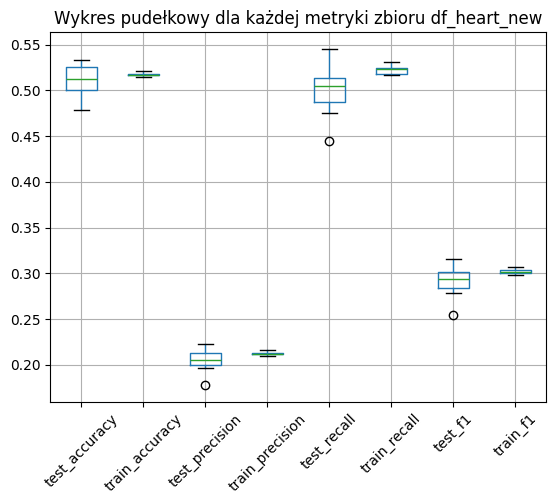

In [ ]:
scores_logistic_ist_df = pd.DataFrame(scores_log_ist_heart)
scores_logistic_ist_df.drop(columns=["fit_time", "score_time"]).boxplot()
plt.title("Wykres pudełkowy dla każdej metryki zbioru df_heart_new")
plt.xticks(rotation=45)
plt.show()

Wszystkie metryki na zbiorach testowych osiągają niskie wartości. Mediana dokładności oscyluje wokół 0.51-0.52.
W konsekwencji bardzo niskiej precyzji i przeciętnej czułości, wynik test_f1 jest również niski, z medianą około 0.28-0.29. To potwierdza słabą ogólną zdolność modelu do poprawnego identyfikowania klasy pozytywnej.

Wyniki na zbiorach treningowych mają znacznie mniejszy rozrzut (węższe pudełka, krótsze wąsy) niż odpowiadające im metryki na zbiorach testowych.
Stała obecność tej różnicy może sugerować lekkie przeuczenie. Model lepiej radzi sobie z danymi, na których trenował w danej iteracji walidacji krzyżowej.

Metryki testowe wykazują zauważalną zmienność (większy rozrzut, obecność wartości odstających). Oznacza to, że wydajność modelu na niewidzianych danych może się wahać w zależności od konkretnego podziału danych użytego w walidacji krzyżowej.

### KNN - K-najbliższych sąsiadów

In [ ]:
#Zastosowanie SMOTE, aby zrównoważyć dane treningowe
smote = SMOTE(random_state=123)
X_train_h_smote, y_train_h_smote = smote.fit_resample(X_train_h, y_train_h)

# Model KNN
model_heart_knn = KNeighborsClassifier(n_neighbors=2)
model_heart_knn.fit(X_train_h_smote, y_train_h_smote)

y_pred_h_knn = model_heart_knn.predict(X_test_h)

Macierz błędów

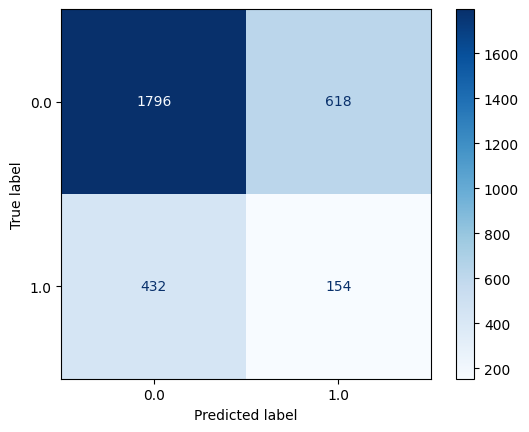

In [ ]:
cm_knn_h = confusion_matrix(y_test_h, y_pred_h_knn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn_h,
                              display_labels=model_heart_knn.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy:", accuracy_score(y_test_h, y_pred_h_knn))
print("Classification Report:\n", classification_report(y_test_h, y_pred_h_knn))

Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.74      0.77      2414
         1.0       0.20      0.26      0.23       586

    accuracy                           0.65      3000
   macro avg       0.50      0.50      0.50      3000
weighted avg       0.69      0.65      0.67      3000



Model osiągnął ogólną trafność na poziomie 65%. Jest to wynik znacznie lepszy niż poprzednie modele.
Tylko 20% przypadków zaklasyfikowanych przez model jako Klasa 1 faktycznie należy do tej klasy. Pozostałe 80% to fałszywie pozytywne zaklasyfikowane przypadki (FP = 611).

Model poprawnie zidentyfikował tylko 154 przypadków klasy 1.0 (TP), podczas gdy aż 432 przypadków tej klasy zostało błędnie sklasyfikowanych jako FN.
Wynik F1-Score wyniósł 0.23 dla klasy 1, co jednoznacznie wskazuje na całkowitą nieefektywność modelu w identyfikacji Klasy 1.0.

O wiele lepiej wypada indetyfikacji klasy 0 (klasa negatywna): Model poprawnie zidentyfikował 1803 przypadki spośród 2414 rzeczywistych przypadków tej klasy. Jest to precyzja na poziomie 81%.
F1-Score jest o wiele wyższy niż dla klasy 1 i wyniósł 0.77. Wskazuje na stosunkowo dobrą równowagę między precyzją a czułością dla tej klasy.

Model KNN wykazuje silną tendencję do przewidywania klasy 0 i jest wysoce nieefektywny w wykrywaniu klasy mniejszościowej 1.
Kiedy model przewiduje klasę 0.0, jest to poprawna decyzja w większości przypadków. NPV wynosi 80.7%.

### Szukanie najlepszej liczby n_neighbors dla KNN

In [ ]:
grid_cv = GridSearchCV(KNeighborsClassifier(),
                       param_grid={
                           "n_neighbors": range(2, 50)
                       }, cv=5, scoring="f1",
                       verbose=1, n_jobs=6)

In [ ]:
grid_cv.fit(X_train_h_smote, y_train_h_smote)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'n_neighbors': range(2, 50)}, scoring='f1', verbose=1)

In [ ]:
grid_cv.best_score_

np.float64(0.8643208062868032)

In [ ]:
knn = grid_cv.best_estimator_
knn

KNeighborsClassifier(n_neighbors=2)

Za pomocą GridSearchCV z zakresu `n_neighbors` od 2 do 49 oraz 5-krotnej walidacji krzyżowej, algorytm wskazał nam na najlepszą wartość hiperparametru `n_neighbors` = 2. Dobór ten został dokonany na podstawie maksymalizacji miary F1. Jest to taki sam dobór parametru, jaki użyty przy pierwotnym modelu KNN.

Najlepszy wynik F1-score uzyskany podczas walidacji krzyżowej na zbiorze treningowym wyniósł 0.8643. Oznacza to, że model bardzo dobrze radził sobie z danymi treningowymi po zastosowaniu SMOTE.

In [ ]:
f1_score(y_test_h, knn.predict(X_test_h))

0.2268041237113402

Po przetestowaniu najlepszego modelu (z `n_neighbors=2`) na danych testowych uzyskano wynik F1-score równy 0.2268.
Jest to stosunkowo niski wynik i jest on podobny do wyniku z regresji logistycznej. Model dalej nie potrafi poradzić sobie z danymi testowymi, a w treningowych dąży do overfittingu z faworyzacją klasy 0.

### Wykres z podziałem na obszary klasyfikacji KNN

In [ ]:
#redukcja wymiarów do 2 za pomocą PCA, aby narysować wykres
pca = PCA(n_components=2)
X_train_h_knn_pca = pca.fit_transform(X_train_h_smote)
X_test_h_knn_pca = pca.transform(X_test_h)

model_heart_knn_pca = KNeighborsClassifier(n_neighbors=2)
model_heart_knn_pca.fit(X_train_h_knn_pca, y_train_h_smote)

y_pred_h_knn_pca = model_heart_knn_pca.predict(X_test_h_knn_pca)

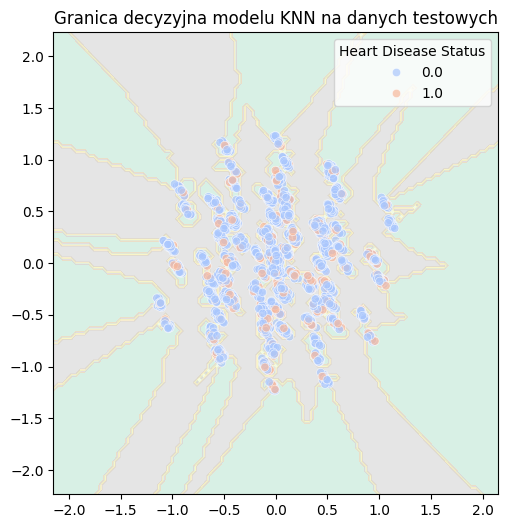

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(model_heart_knn_pca, X_test_h_knn_pca, response_method="predict", ax=ax, cmap="Pastel2", alpha=0.5)
sns.scatterplot(x=X_test_h_knn_pca[:, 0], y=X_test_h_knn_pca[:, 1], hue=y_test_h, alpha=0.7, ax=ax, palette="coolwarm")
ax.set_aspect("equal")
ax.set_title("Granica decyzyjna modelu KNN na danych testowych")
plt.show()

Granica pomiędzy klasami ma bardzo nieregularny kształt. Może to prowadzić do przeuczenia modelu, który zbyt mocno dopasowuje się do danych treningowych.
Na wykresie widać, że punkty klasy 0 i 1 są silnie wymieszane w centralnej części przestrzeni. Świadczy to o dużym stopniu nakładania się klas, co utrudnia modelowi skuteczną separację.

Większość danych testowych znajduje się w obszarze przypisanym klasie 0. Model nadal ma trudności z poprawnym klasyfikowaniem przypadków klasy 1. Granice decyzyjne wokół tych punktów są bardzo wąskie i "niespokojne", co może skutkować losowym przypisywaniem klas w ich pobliżu.

### KNN - dla cech istotnych

In [ ]:
#Zastosowanie SMOTE, aby zrównoważyć dane treningowe
smote = SMOTE(random_state=123)
X_train_h_smote_ist, y_train_h_smote_ist = smote.fit_resample(X_train_h_ist, y_train_h_ist)

# Model KNN
model_heart_knn_ist = KNeighborsClassifier(n_neighbors=2)
model_heart_knn_ist.fit(X_train_h_smote_ist, y_train_h_smote_ist)

y_pred_h_knn_ist = model_heart_knn_ist.predict(X_test_h_ist)

Macierz błędów

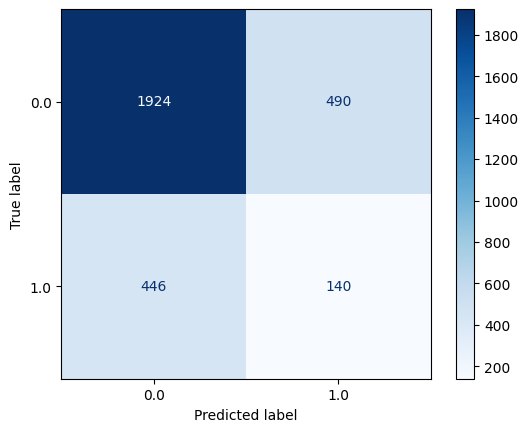

In [ ]:
cm_knn_ist = confusion_matrix(y_test_h_ist, y_pred_h_knn_ist)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn_ist, display_labels=model_heart_knn_ist.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy:", accuracy_score(y_test_h_ist, y_pred_h_knn_ist))
print("Classification Report:\n", classification_report(y_test_h_ist, y_pred_h_knn_ist))

Accuracy: 0.688
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.80      0.80      2414
         1.0       0.22      0.24      0.23       586

    accuracy                           0.69      3000
   macro avg       0.52      0.52      0.52      3000
weighted avg       0.70      0.69      0.69      3000



Model KNN z tylko cechami istotnymi daje najlepszy poziom dokładności przy dobrych wynikach dla precision, recall i f1-score w klasie 1. Wyniki te nadal są na poziomie minimum i nie dają gwarancji poprawności modelu, jednak są one lepsze niż poprzednie.

Na podstawie przedstawionych metryk klasyfikacji dla modelu KNN można sformułować następujące wnioski:

Dokładność wyniosła 0.688, co oznacza, że około 69% przykładów zostało prawidłowo sklasyfikowanych.
Dla klasy 0.0 większośc statystyk była na poziomie 0.8 co oznacza, że model dobrze radzi sobie z klasyfikacją klasy dominującej. Jest to też spowodowane tym, że 80% danych w zbiorze to dane zaklasyfikowane do klasy 0.
Dla klasy 1.0 statystyki są na poziomie 0.2. Model ma nadal bardzo ograniczoną skuteczność w wykrywaniu przypadków klasy 1.0.

Pomimo zastosowania PCA, SMOTE i rankingu istotności cech, model nadal nie radzi sobie dobrze z rozpoznawaniem klasy mniejszościowej. Jest poprawa w klasyfikacji, jednak nadal jest to na niskim poziomie.

### Wykres z podziałem na obszary klasyfikacji KNN dla cech istotnych

In [ ]:
#redukcja wymiarów do 2 za pomocą PCA
pca = PCA(n_components=2)
X_train_pca_knn_ist = pca.fit_transform(X_train_h_smote_ist)
X_test_pca_knn_ist = pca.transform(X_test_h_ist)

# Model KNN
model_heart_pca_knn_ist = KNeighborsClassifier(n_neighbors=2)
model_heart_pca_knn_ist.fit(X_train_pca_knn_ist, y_train_h_smote_ist)

y_pred_h_knn_new = model_heart_pca_knn_ist.predict(X_test_pca_knn_ist)

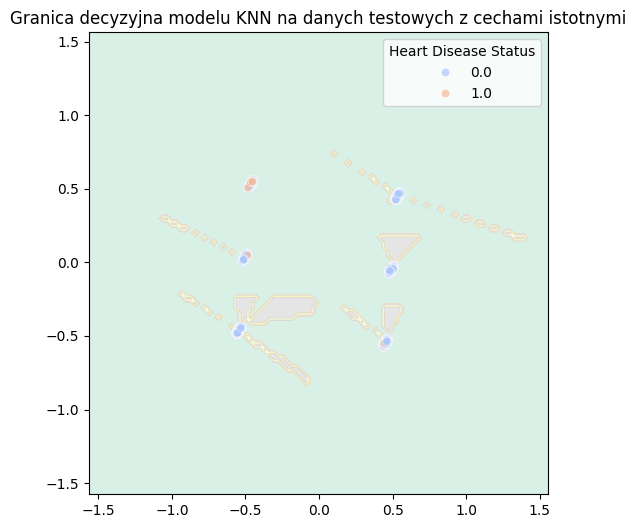

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(model_heart_pca_knn_ist, X_test_pca_knn_ist, response_method="predict", ax=ax, cmap="Pastel2", alpha=0.5)
sns.scatterplot(x=X_test_pca_knn_ist[:, 0], y=X_test_pca_knn_ist[:, 1], hue=y_test_h_ist, alpha=0.7, ax=ax, palette="coolwarm")
ax.set_aspect("equal")
ax.set_title("Granica decyzyjna modelu KNN na danych testowych z cechami istotnymi")
plt.show()

Model KNN słabo generalizuje dane testowe – granice decyzyjne są nieregularne, co sugeruje przeuczenie dla klasy 0. Klasyfikacja jest bardzo zależna od lokalnych sąsiadów, co prowadzi do wielu błędów.
Warto też zauważyć trudność z poprawną klasyfikacją przypadków choroby serca, zwłaszcza że są one rzadkie i rozproszone.

Cechy istotne mogły być zbyt silnie zredukowane i spowodować utratę informacji potrzebnej do poprawnej klasyfikacji, szczególnie klasy mniejszościowej.

### SVM (Support Vector Machine) - LinearSVC()

In [ ]:
# Model SVM
model_svm_h_linear = LinearSVC()
model_svm_h_linear.fit(X_train_h_smote, y_train_h_smote)

y_pred_svm_h_linear = model_svm_h_linear.predict(X_test_h)

Macierz błędów

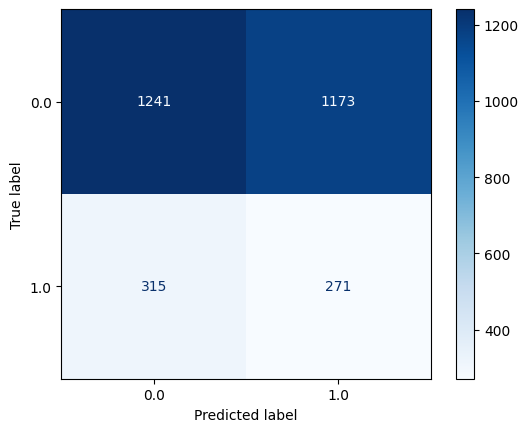

In [ ]:
cm_svm_h = confusion_matrix(y_test_h, y_pred_svm_h_linear)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_h, display_labels=model_svm_h_linear.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy:", accuracy_score(y_test_h, y_pred_svm_h_linear))
print("Classification Report:\n", classification_report(y_test_h, y_pred_svm_h_linear))

Accuracy: 0.504
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.51      0.63      2414
         1.0       0.19      0.46      0.27       586

    accuracy                           0.50      3000
   macro avg       0.49      0.49      0.45      3000
weighted avg       0.68      0.50      0.56      3000



Model wykazuje słabą wydajność na poziomie 50%. Jest to kolejny raz kiedy model przewiduje losowo.

Model poprawnie zidentyfikował tylko 271 z 586 rzeczywistych przypadków klasy 1. Oznacza to, że ponad połowa przypadków została błędnie sklasyfikowana jako 0(wysoka liczba FN). Wskazuje na to niska czułość dla klasy 1 = 0.46.
Gdy model przewiduje klasę 1.0, jest to w większości błędna predykcja (wysoka liczba Fałszywych Pozytywów). Jest poprawny tylko w 19% przypadków.

Gdy model przewiduje klasę 0.0, jest poprawny w 80% przypadków.
Model identyfikuje poprawnie tylko 51% rzeczywistych przypadków klasy 0.0.
Wynik F1 dla klasy 0.0 jest umiarkowany, głównie zaniżony przez słabą czułość.

Model ma wyraźny problem z rozróżnieniem klas, a szczególnie ze skutecznym identyfikowaniem klasy mniejszościowej. Ma tendecję do klasyfikowania większości danych jako klasa 0.
Liniowy model SVM w obecnej formie jest nieodpowiedni dla tego zbioru danych i należy spróbować z jądrem nieliniowym.

### SVM (Support Vector Machine) - kernel = "poly"

In [ ]:
# Model SVM - poly
model_svm_h_poly = SVC(kernel="poly", degree=4)
model_svm_h_poly.fit(X_train_h_smote, y_train_h_smote)

y_pred_svm_h_poly = model_svm_h_poly.predict(X_test_h)

Macierz błędów

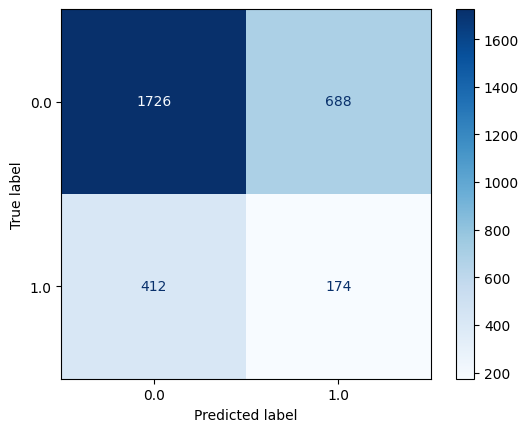

In [ ]:
cm_svm_h_poly = confusion_matrix(y_test_h, y_pred_svm_h_poly)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_h_poly, display_labels=model_svm_h_poly.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy: ", accuracy_score(y_test_h, y_pred_svm_h_poly))
print("Classification Report:\n", classification_report(y_test_h, y_pred_svm_h_poly))

Accuracy:  0.6333333333333333
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.71      0.76      2414
         1.0       0.20      0.30      0.24       586

    accuracy                           0.63      3000
   macro avg       0.50      0.51      0.50      3000
weighted avg       0.69      0.63      0.66      3000



Model SVM Poly osiągnął wyższą dokładność - około 63.3%. Jest to więcej niż model liniowy, głównie dzięki lepszemu rozpoznawaniu liczniejszej klasy 0.0 (Recall ok. 71.5%).

Klasyfikacja klasy 1.0 uległa znacznemu pogorszeniu. Model poprawnie zidentyfikował tylko 174 z 586 rzeczywistych przypadków klasy 1.0. Oznacza to, że SVM poly wykrył tylko 30% jej przypadków, a 70% pominął. Wskazuje na to bardzo duża liczba Fałszywych Negatywów.
Precyzja dla klasy 1.0 pozostaje bardzo niska, co oznacza, że większość predykcji dla tej klasy jest błędna.

Natomiast, gdy model przewiduje klasę 0 jest poprawny w 81% przypadków.

Jądro wielomianowe (stopnia 4) pozwoliło modelowi lepiej dopasować się do klasy 0, zwiększając liczbę Prawdziwych Negatywów (TN) i poprawiając specyficzność.
Ta poprawa odbyła się kosztem jeszcze gorszej identyfikacji klasy 1, gdzie czułość spadła drastycznie.

### SVM (Support Vector Machine) - kernel = "rbf"

In [ ]:
#Model SVM - rbf
model_svm_h_rbf = SVC(kernel="rbf")
model_svm_h_rbf.fit(X_train_h_smote, y_train_h_smote)

y_pred_svm_h_rbf = model_svm_h_rbf.predict(X_test_h)

Macierz błędów

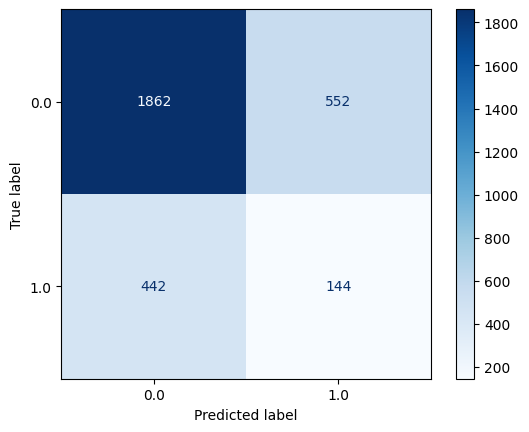

In [ ]:
cm_svm_h_rbf = confusion_matrix(y_test_h, y_pred_svm_h_rbf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_h_rbf, display_labels=model_svm_h_rbf.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy: ", accuracy_score(y_test_h, y_pred_svm_h_rbf))
print("Classification Report:\n", classification_report(y_test_h, y_pred_svm_h_rbf))

Accuracy:  0.6686666666666666
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.77      0.79      2414
         1.0       0.21      0.25      0.22       586

    accuracy                           0.67      3000
   macro avg       0.51      0.51      0.51      3000
weighted avg       0.69      0.67      0.68      3000



Model, spośród wszystkich modeli SVM, osiągnął najlepszy wynik dla zbioru danych df_heart z dokładnością około 67%. Jednak biorąc pod uwagę resztę statystyk - nie jest to miarodajny wynik. Model prawidłowo klasyfikuje około 2/3 przypadków. Jednak należy wziąć pod uwagę, że zbiór jest niezrównoważony. Na korzyść klasyfikacji klasy 0 - zmniejszyliśmy poziom klasyfikacji klasy 1.

Model wykazuje niską czułość dla klasy 1.0. Tylko 25% rzeczywistych przypadków choroby serca zostało poprawnie wykrytych. Precyzja tego modelu również wskazuje na to, że większość przypadków zaklasyfikowanych jako chorzy, była w rzeczywistości zdrowa. Zaledwie 144 z 586 rzeczywistych przypadków choroby zostało prawidłowo rozpoznanych.

Natomiast klasa 0.0 wykazuje bardzo dobrą klasyfikację. O wiele łatwiej modelowi wykryć osobę zdrową. Precyzja wyniosła 0.81, a czułość 0.77. F1-Score na poziomie 0.79 to bardzo dobry wynik.

Najlepszym modelem okazał się model SVM z jądrem wielomianowym (kernel = 'poly', degree = 4). Jego skuteczność wynika z lepszego dopasowania danych do przestrzeni wielomianowej niż liniowej.
Pomimo nieco niższej wartości accuracy w porównaniu z modelem SVM z jądrem RBF, model z jądrem poly wykazywał większą stabilność wyników, szczególnie pod względem metryk recall i F1-score dla obu klas.

### Wykres z podziałem na obszary klasyfikacji SVM dla funkcji jądra wielomianowego poly

In [ ]:
pca = PCA(n_components=2)
X_train_svm_h_pca = pca.fit_transform(X_train_h_smote)
X_test_svh_h_pca = pca.transform(X_test_h)

model_svm_pca_h_rbf = SVC(kernel="poly", degree=4)
model_svm_pca_h_rbf.fit(X_train_svm_h_pca, y_train_h_smote)

y_pred_svm_h_pca_rbf = model_svm_pca_h_rbf.predict(X_test_svh_h_pca)

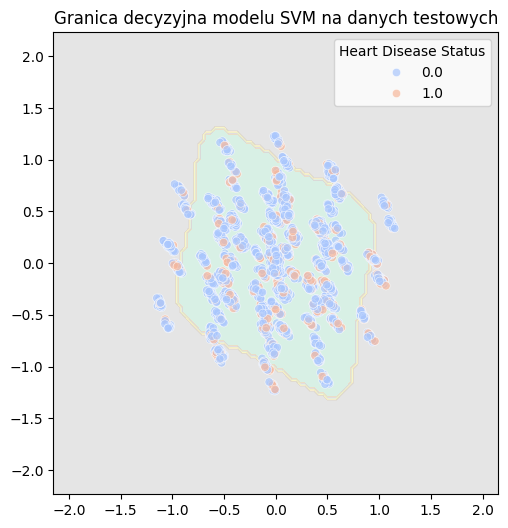

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(model_svm_pca_h_rbf, X_test_svh_h_pca, response_method="predict", ax=ax, cmap="Pastel2", alpha=0.5)
sns.scatterplot(x=X_test_svh_h_pca[:, 0], y=X_test_svh_h_pca[:, 1], hue=y_test_h, alpha=0.7, ax=ax, palette="coolwarm")
ax.set_aspect("equal")
ax.set_title("Granica decyzyjna modelu SVM na danych testowych")
plt.show()

Granica decyzyjna przyjmuje nieliniowy, nieregularny kształt, co potwierdza, że model dobrze wykorzystuje właściwości jądra wielomianowego.

Większość punktów klasy 0 znajduje się wewnątrz wyznaczonego obszaru klasyfikacyjnego, co sugeruje, że model skutecznie identyfikuje osoby zdrowe.
Z kolei punkty klasy 1 są rozproszone i często znajdują się w tej samej przestrzeni co klasa 0, co może wskazywać na trudności modelu w jednoznacznym odróżnianiu przypadków choroby serca.
Gęstość punktów i ich nakładanie się sugerują, że przypadki obu klas nie są łatwe do separacji, a dane są częściowo nieliniowo rozdzielne.

### SVM (Support Vector Machine) - LinearSVC() dla cech istotnych

In [ ]:
#Model SVM z cechami istotnymi
model_svm_h_ist = LinearSVC()
model_svm_h_ist.fit(X_train_h_smote_ist, y_train_h_smote_ist)

y_pred_svm_h_ist = model_svm_h_ist.predict(X_test_h_ist)

Macierz błędów

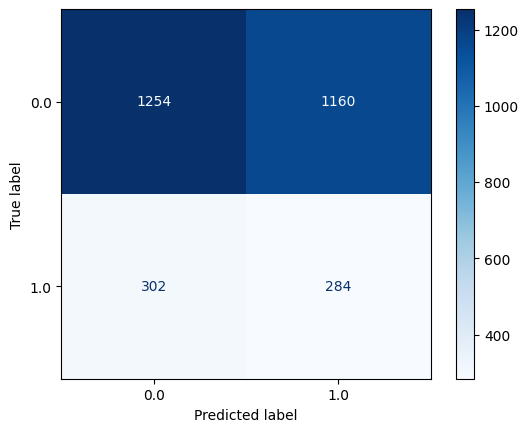

In [ ]:
cm_svm_h_ist = confusion_matrix(y_test_h_ist, y_pred_svm_h_ist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_h_ist, display_labels=model_svm_h_ist.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy: ", accuracy_score(y_test_h_ist, y_pred_svm_h_ist))
print("Classification Report:\n", classification_report(y_test_h_ist, y_pred_svm_h_ist))

Accuracy:  0.5126666666666667
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.52      0.63      2414
         1.0       0.20      0.48      0.28       586

    accuracy                           0.51      3000
   macro avg       0.50      0.50      0.46      3000
weighted avg       0.69      0.51      0.56      3000



Model oparty wyłącznie na cechach istotnych uzyskał minimalnie wyższą dokładność niż model liniowy oparty na wszystkich cechach. Teraz wynosi 51%, jednak jest to nadal bardzo słaby poziom dokładności. Nieznaczna poprawa może sugerować redukcję szumu informacyjnego z naszych danych.

Recall wzrósł z 0.46 do 0.48, jednak precision pozostała na niskim poziomie, wskazując nadal na trudności w klasyfikacji klasy 1.0.

F1-Score dla klasy 1 wyniósł 0.28 i wskazuje na nieznaczną poprawę.
Selekcja cech mogła pozytywnie wpłynąć na stabilność klasyfikacji, szczególnie dla klasy mniejszościowej.

### SVM (Support Vector Machine) - kernel = "poly" dla cech istotnych

In [ ]:
#Model SVM - poly z cechami istotnymi
model_svm_h_poly_ist = SVC(kernel="poly", degree=5)
model_svm_h_poly_ist.fit(X_train_h_smote_ist, y_train_h_smote_ist)

y_pred_svm_h_poly_ist = model_svm_h_poly_ist.predict(X_test_h_ist)

Macierz błędów

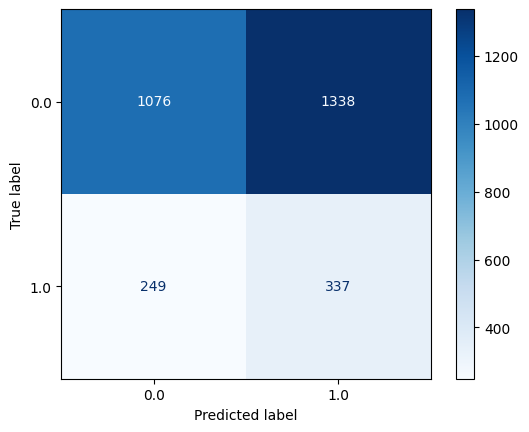

In [ ]:
cm_h_poly_ist = confusion_matrix(y_test_h_ist, y_pred_svm_h_poly_ist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_h_poly_ist, display_labels=model_svm_h_poly_ist.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy: ", accuracy_score(y_test_h_ist, y_pred_svm_h_poly_ist))
print("Classification Report:\n", classification_report(y_test_h_ist, y_pred_svm_h_poly_ist))

Accuracy:  0.471
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.45      0.58      2414
         1.0       0.20      0.58      0.30       586

    accuracy                           0.47      3000
   macro avg       0.51      0.51      0.44      3000
weighted avg       0.69      0.47      0.52      3000



Kluczowym wnioskiem jest to, że model na zredukowanych danych gorzej radzi sobie przy użyciu jądra wielomianowego niż przy użyciu jądra liniowego.
Jądro wielomianowe tworzy bardziej złożone granice decyzyjne. Mniejsza liczba cech mogła sprawić, że model stał się zbyt elastyczny. Możliwe jest, że wybrane cechy tworzą przestrzeń, w której klasy są bardziej liniowo separowalne, a złożoność jądra wielomianowego jest niepotrzebna i utrudniająca klasyfikację.

Model osiągnął bardzo niską dokładność (Accuracy) na poziomie 47%, co jest najgorszym wynikiem.

Model wygenerował bardzo dużą liczbę FP = 1338. Oznacza to, że przypadki należące w rzeczywistości do klasy 0.0 były błędnie klasyfikowane jako klasa 1.0. Liczba Fałszywie Negatywnych jest również duża, wskazując, że prawie 250 przypadków faktycznie należących do klasy 1.0 zostało błędnie sklasyfikowanych jako klasa 0.0. Nie tylko losowe było sklasyfikowanie kogoś jako chorego, ale również jako kogoś zdrowego.

Klasa 1 Charakteryzuje się niską precyzją, gdzie tylko 20% przypadków zidentyfikowanych przez model jako klasa 1 faktycznie należało do tej klasy. Czułość jest o wiele większa w porównaniu do innych modeli - 58% rzeczywistych przypadków klasy 1.0 było dobrze zaklasyfikowanych. Niski F1-score (0.30) odzwierciedla słabą równowagę tych metryk.

Klasa 0 posiada stosunkowo dobrą precyzję na poziomie 81%, ale bardzo niską czułość 45%. Model poprawnie zidentyfikował jedynie 45% wszystkich rzeczywistych przypadków klasy 0.0, co jest bezpośrednim skutkiem dużej liczby FP.

### SVM (Support Vector Machine) - kernel = "rbf" dla cech istotnych

In [ ]:
#Model SVM - rbf z cechami istotnymi
model_svm_h_rbf_ist = SVC(kernel="rbf")
model_svm_h_rbf_ist.fit(X_train_h_smote_ist, y_train_h_smote_ist)

y_pred_svm_h_rbf_ist = model_svm_h_rbf_ist.predict(X_test_h_ist)

Macierz błędów

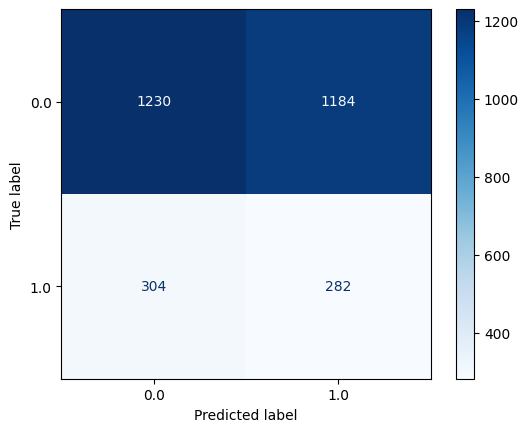

In [ ]:
cm_h_rbf_ist = confusion_matrix(y_test_h_ist, y_pred_svm_h_rbf_ist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_h_rbf_ist, display_labels=model_svm_h_rbf_ist.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy: ", accuracy_score(y_test_h_ist, y_pred_svm_h_rbf_ist))
print("Classification Report:\n", classification_report(y_test_h_ist, y_pred_svm_h_rbf_ist))

Accuracy:  0.504
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.51      0.62      2414
         1.0       0.19      0.48      0.27       586

    accuracy                           0.50      3000
   macro avg       0.50      0.50      0.45      3000
weighted avg       0.68      0.50      0.56      3000



Choć model poprawnie zidentyfikował 1230 przypadków klasy 0.0 (TN) i 282 przypadki klasy 1.0 (TP), to jednocześnie wygenerował bardzo dużą liczbę FP = 1184 oraz znaczącą liczbę FN = 304.

Klasa 1 ma niską precyzję, co oznacza, że gdy model przewidując tę klasę, myli się w ponad 80% przypadków (z powodu wysokiego FP). Również poziom czułości modelu jest niski - model nie wykrywa ponad połowy rzeczywistych przypadków tej klasy.

Klasa 0 również ma niską czułość, co jest bezpośrednim skutkiem dużej liczby błędnych klasyfikacji jako klasa 1. Wraz ze wzrostem czułości dla klasy 1, zmalała ona dla klasy 0.

Model SVM z jądrem RBF na istotnych cechach jest nieefektywny. Charakteryzuje się bardzo niską ogólną trafnością i jest szczególnie niewiarygodny w identyfikacji przypadków klasy 1. Zastosowanie jądra RBF nie przyniosło poprawy w stosunku do jądra wielomianowego na tym konkretnym zestawie cech. Najlepsze wyniki i stałe proporcje w raporcie osiągnął model wykorzystujący jądro liniowe.

### Wykres z podziałem na obszary klasyfikacji SVM dla cech istotnych dla funkcji jądra liniowego

In [ ]:
pca = PCA(n_components=2)
X_train_svm_h_ist_pca = pca.fit_transform(X_train_h_smote_ist)
X_test_svm_h_ist_pca = pca.transform(X_test_h_ist)

#Model SVM z cechami istotnymi dla najlepszej funkcji - LinearSVC()
model_svm_h_ist_pca = LinearSVC()
model_svm_h_ist_pca.fit(X_train_svm_h_ist_pca, y_train_h_smote_ist)
y_pred_svm_h_ist_pca = model_svm_h_ist_pca.predict(X_test_svm_h_ist_pca)

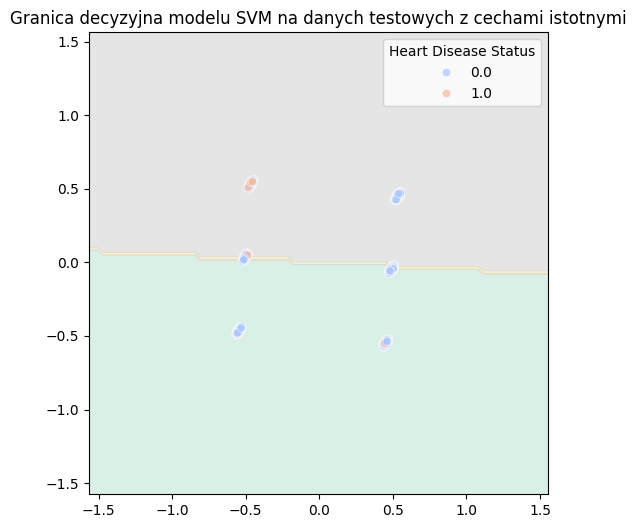

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(model_svm_h_ist_pca, X_test_svm_h_ist_pca, response_method="predict", ax=ax, cmap="Pastel2", alpha=0.5)
sns.scatterplot(x=X_test_svm_h_ist_pca[:, 0], y=X_test_svm_h_ist_pca[:, 1], hue=y_test_h_ist, alpha=0.7, ax=ax, palette="coolwarm")
ax.set_aspect("equal")
ax.set_title("Granica decyzyjna modelu SVM na danych testowych z cechami istotnymi")
plt.show()

Wykres granicy decyzyjnej na danych testowych, dla cech istotnych wskazuje, że model nie dokonuje efektywnej separacji pomiędzy klasami. Punkty obu klas są znacząco przemieszane, szczególnie w pobliżu granicy. Punkty z klasy 0 znajdują się i powyżej granicy i poniżej granicy. Wizualizacja potwierdza problemy zaobserwowane w macierzy błędów.

Słaba separacja sugeruje, że podział danych na tylko istotne cechy nie dostarcza wystarczjącej informacji, aby model SVM mógł poprawnie klasyfikować dane i rozdzielić je na klasy za pomocą wyuczonej granicy. Model ma trudności ze znalezieniem wyraźnej reguły podziału między klasami, co prowadzi do licznych błędów klasyfikacji obserwowanych w metrykach ilościowych.

### Podsumowanie trzech modeli

In [ ]:
#Lista do przechowywania wyników dla każdego modelu
model_results = []

#Regresja logistyczna (Wszystkie cechy, class_weight=balanced)
model_results.append({
    'Model': 'Logistic Regression',
    'Features': 'All',
    'Preprocessing': 'class_weight=balanced',
    'Accuracy': accuracy_h,
    'Precision': precision_h,
    'Recall': recall_h,
    'F1-Score': f1_h
})

#Regresja logistyczna (Wybrane cechy - RFECV, class_weight=balanced)
model_results.append({
    'Model': 'Logistic Regression',
    'Features': 'RFECV',
    'Preprocessing': 'class_weight=balanced',
    'Accuracy': accuracy_h_ist,
    'Precision': precision_h_ist,
    'Recall': recall_h_ist,
    'F1-Score': f1_h_ist
})

#KNN (k=2, Wszystkie Cechy, SMOTE)
model_results.append({
    'Model': 'KNN (k=2)',
    'Features': 'All',
    'Preprocessing': 'SMOTE',
    'Accuracy': accuracy_score(y_test_h, y_pred_h_knn),
    'Precision': precision_score(y_test_h, y_pred_h_knn),
    'Recall': recall_score(y_test_h, y_pred_h_knn),
    'F1-Score': f1_score(y_test_h, y_pred_h_knn)
})

#KNN (k=2, Wybrane Cechy - RFECV, SMOTE)
model_results.append({
    'Model': 'KNN (k=2)',
    'Features': 'RFECV',
    'Preprocessing': 'SMOTE',
    'Accuracy': accuracy_score(y_test_h_ist, y_pred_h_knn_ist),
    'Precision': precision_score(y_test_h_ist, y_pred_h_knn_ist),
    'Recall': recall_score(y_test_h_ist, y_pred_h_knn_ist),
    'F1-Score': f1_score(y_test_h_ist, y_pred_h_knn_ist)
})

#SVM (Linear, Wszystkie Cechy, SMOTE)
model_results.append({
    'Model': 'SVM (Linear)',
    'Features': 'All',
    'Preprocessing': 'SMOTE',
    'Accuracy': accuracy_score(y_test_h, y_pred_svm_h_linear),
    'Precision': precision_score(y_test_h, y_pred_svm_h_linear),
    'Recall': recall_score(y_test_h, y_pred_svm_h_linear),
    'F1-Score': f1_score(y_test_h, y_pred_svm_h_linear)
})

#SVM (Poly, Wszystkie Cechy, SMOTE)
model_results.append({
    'Model': 'SVM (Poly degree = 4)',
    'Features': 'All',
    'Preprocessing': 'SMOTE',
    'Accuracy': accuracy_score(y_test_h, y_pred_svm_h_poly),
    'Precision': precision_score(y_test_h, y_pred_svm_h_poly),
    'Recall': recall_score(y_test_h, y_pred_svm_h_poly),
    'F1-Score': f1_score(y_test_h, y_pred_svm_h_poly)
})

#SVM (RBF, Wszystkie Cechy, SMOTE)
model_results.append({
    'Model': 'SVM (RBF)',
    'Features': 'All',
    'Preprocessing': 'SMOTE',
    'Accuracy': accuracy_score(y_test_h, y_pred_svm_h_rbf),
    'Precision': precision_score(y_test_h, y_pred_svm_h_rbf),
    'Recall': recall_score(y_test_h, y_pred_svm_h_rbf),
    'F1-Score': f1_score(y_test_h, y_pred_svm_h_rbf)
})

#SVM (Linear, Wybrane Cechy - RFECV, SMOTE)
model_results.append({
    'Model': 'SVM (Linear)',
    'Features': 'RFECV',
    'Preprocessing': 'SMOTE',
    'Accuracy': accuracy_score(y_test_h_ist, y_pred_svm_h_ist),
    'Precision': precision_score(y_test_h_ist, y_pred_svm_h_ist),
    'Recall': recall_score(y_test_h_ist, y_pred_svm_h_ist),
    'F1-Score': f1_score(y_test_h_ist, y_pred_svm_h_ist)
})

#SVM (Poly, Wybrane Cechy - RFECV, SMOTE)
model_results.append({
    'Model': 'SVM (Poly degree = 5)',
    'Features': 'RFECV',
    'Preprocessing': 'SMOTE',
    'Accuracy': accuracy_score(y_test_h_ist, y_pred_svm_h_poly_ist),
    'Precision': precision_score(y_test_h_ist, y_pred_svm_h_poly_ist),
    'Recall': recall_score(y_test_h_ist, y_pred_svm_h_poly_ist),
    'F1-Score': f1_score(y_test_h_ist, y_pred_svm_h_poly_ist)
})

#SVM (RBF, Wybrane Cechy - RFECV, SMOTE)
model_results.append({
    'Model': 'SVM (RBF)',
    'Features': 'RFECV',
    'Preprocessing': 'SMOTE',
    'Accuracy': accuracy_score(y_test_h_ist, y_pred_svm_h_rbf_ist),
    'Precision': precision_score(y_test_h_ist, y_pred_svm_h_rbf_ist),
    'Recall': recall_score(y_test_h_ist, y_pred_svm_h_rbf_ist),
    'F1-Score': f1_score(y_test_h_ist, y_pred_svm_h_rbf_ist)
})

summary_df = pd.DataFrame(model_results)
pd.options.display.float_format = '{:.4f}'.format
print(summary_df)

                   Model Features          Preprocessing  Accuracy  Precision  \
0    Logistic Regression      All  class_weight=balanced    0.5023     0.1900   
1    Logistic Regression    RFECV  class_weight=balanced    0.5060     0.1936   
2              KNN (k=2)      All                  SMOTE    0.6500     0.1995   
3              KNN (k=2)    RFECV                  SMOTE    0.6880     0.2222   
4           SVM (Linear)      All                  SMOTE    0.5040     0.1877   
5  SVM (Poly degree = 4)      All                  SMOTE    0.6333     0.2019   
6              SVM (RBF)      All                  SMOTE    0.6687     0.2069   
7           SVM (Linear)    RFECV                  SMOTE    0.5127     0.1967   
8  SVM (Poly degree = 5)    RFECV                  SMOTE    0.4710     0.2012   
9              SVM (RBF)    RFECV                  SMOTE    0.5040     0.1924   

   Recall  F1-Score  
0  0.4744    0.2714  
1  0.4829    0.2764  
2  0.2628    0.2268  
3  0.2389    0.2303 

Zbiór `df_heart` posiada niezbalansowane dane, które bez wcześniejszej obróbki (`class_weight='balanced' oraz techniki SMOTE) nie byłyby możliwe do klasyfikacji.

Na podstawie przedstawionych wyników podsumowania można stwierdzić, że:
- Najlepszą skuteczność osiągnął model KNN (n_neighbours=2) z modelowaniem na cechach istotnych i zastosowaniem techniki SMOTE dla danych niezbalansowanych. Taki model osiągnął najwyższą dokładność: 68.8%. Dla KNN dobór cech za pomocą RFECV pozytywnie wpłynął na wynik w porównaniu do wersji z wszystkimi cechami. Miało to jednak swoje konsekwencje dla czułości i f1-score.
- Najlepszą precyzję również osiągnął model model KNN (n_neighbours=2) z modelowaniem na cechach istotnych i zastosowaniem techniki SMOTE dla danych niezbalansowanych. Osiągnął wartość 22.2%, co oznacza, że żaden z modeli nie odróżniał dobrze klas pozytywnych i jest to możliwie najlepsza z najgorszych wyników.
- Najwyższy wynik Recall = 0.5751 uzyskał model SVM z jądrem wielomianowym ("Poly", degree = 5) na danych istotnych i zastosowaniem techniki SMOTE. Model najlepiej wykrywał klasę pozytywną, ale kosztem bardzo niskiej dokładności (0.47).

Dobór cech zazwyczaj zwiększa wyniki dla KNN i SVM (Linear), ale w przypadku SVM Poly dla stopnia 5 — mimo wzrostu recall, dokładność spadła.
Jednak zarówno z wszystkimi cechami, jak i po RFECT, model ten osiąga dokładność około 50%. Ma on często bardzo niską precyzję.

Warto pamiętać, że gdy skupiamy się w tym modelu na wzrost dokładności - spada nam zdolność rozróżniania klasy pozytywnej (1.0), a wzrasta dla klasy 0.0. Jest to klasa bardziej liczna, przez co wpływa na nią najbardziej zmiana dokładności. Modele, które miały gorsze wyniki w dokładności, miały lepsze dopasowanie do klasy 1.0, na rzecz spadku dla klasy 0.0. Obie klasy są od siebie zależne i trudne do łatwego odseparowania, również ze względu na niezbalansowany zbiór danych.
Najmniejszym skutecznym modelem jest regresja logistyczna, natomiast modele KNN i SVM po wybraniu istotnych cech, są najlepsze dla tego zbioru danych. Mimo to, ten model pozostaje nadal trudnym do klasyfikowania danych.

## Zbiór df_cirrhosis - predicting Liver Cirrhosis Stage

In [ ]:
#próbka danych
df_cirrhosis.sample(n=5)

N_Days  Drug  Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  Bilirubin  \
410    1119   NaN   51    0      NaN           NaN      NaN      0        0.6   
97     3823   1.0   29    0      0.0           0.0      0.0      0        1.0   
190     216   0.0   53    0      1.0           1.0      1.0      0       24.5   
108    2504   0.0   44    0      0.0           0.0      0.0      0        0.5   
81     3574   1.0   68    0      0.0           0.0      0.0      0        4.5   

     Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  Platelets  \
410          NaN     3.57     NaN       NaN     NaN            NaN      286.0   
97         239.0     3.77    77.0    1877.0   97.65          101.0      312.0   
190       1092.0     3.35   233.0    3740.0  147.25          432.0      399.0   
108        120.0     3.61    53.0     804.0  110.05           52.0      271.0   
81         472.0     4.09   154.0    1580.0  117.80          272.0      412.0   

     Prothrombin  Stage  Status  
410         10.6    3.0       0  
97          10.2    1.0       0  
190         15.2    4.0       1  
108         10.6    3.0       0  
81          11.1    3.0       1

Zbiór danych `df_cirrhosis` pochodzi z badania dotyczącego pacjentów z pierwotnym zapaleniem dróg żółciowych wątroby (PBC) i zawiera informacje kliniczne zbadane na 418 pacjentach. Dane te wskazują na przewidywanie, czy pacjent przeżyje czy umrze w trakcie okresu obserwacji.

Zmienna `Status` wskazuje na dwie klasy:
0 – pacjent przeżył
1 – pacjent zmarł

Zbiór zawiera dane demograficzne, czas przeżycia, czynniki kliniczne, parametry laboratoryjne (np. poziom cholesteru, liczba płytek krwi) oraz typ leczenia (lek lub placebo).
Celem analizy jest identyfikacja zależności pomiędzy tymi cechami, a stanem pacjenta.

### Sprawdzanie braków danych

In [ ]:
pd.isna(df_cirrhosis).sum()

N_Days             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
Status             0
dtype: int64

Nie wszystkie zmienne posiadają braki danych. Zmienna decyzyjna - `Status` nie posiada żadnych braków danych. Najwięcej braków danych ma zmienna `Tryglicerides`.
Na tym etapie nie usuwam żadnej z kolumn, ponieważ widzimy podobne liczby w brakach danych. Przyjrzyjmy się, czy braki danych są powiązane ze sobą.

In [ ]:
df_cirrhosis.loc[df_cirrhosis.isnull().sum(axis=1).nlargest(5).index]

N_Days  Drug  Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  Bilirubin  \
312    4062   NaN   60    0      NaN           NaN      NaN      0        0.7   
315    2071   NaN   76    0      NaN           NaN      NaN      1        0.7   
316    3030   NaN   62    0      NaN           NaN      NaN      0        0.8   
318      41   NaN   46    0      NaN           NaN      NaN      0        5.0   
321    2011   NaN   64    0      NaN           NaN      NaN      0        1.1   

     Cholesterol  Albumin  Copper  Alk_Phos  SGOT  Tryglicerides  Platelets  \
312          NaN     3.65     NaN       NaN   NaN            NaN      378.0   
315          NaN     3.96     NaN       NaN   NaN            NaN        NaN   
316          NaN     2.48     NaN       NaN   NaN            NaN      273.0   
318          NaN     2.93     NaN       NaN   NaN            NaN      260.0   
321          NaN     3.69     NaN       NaN   NaN            NaN      139.0   

     Prothrombin  Stage  Status  
312         11.0    NaN       0  
315         11.3    4.0       1  
316         10.0    NaN       0  
318         10.4    NaN       1  
321         10.5    NaN       1

Wiele wartości, jeśli ma braki, to ma braki w wielu kolumnach. Należy usunąć te wiersze, w którym braki występują w więcej niż w 8 kolumnach, ponieważ wpływają one na nieefektywną analizę zbioru.

In [ ]:
df_cirrhosis = df_cirrhosis[df_cirrhosis.isnull().sum(axis=1) < 9]

In [ ]:
df_cirrhosis.isnull().sum()

N_Days            0
Drug              0
Age               0
Sex               0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol      28
Albumin           0
Copper            2
Alk_Phos          0
SGOT              0
Tryglicerides    30
Platelets         4
Prothrombin       0
Stage             0
Status            0
dtype: int64

Po usunięciu tych wierszy gdzie były braki w danych w więcej niż połowie kolumn - zostały nam tylko 4 niezależne cechy do zbadania. Są to zmienne: `Cholesterol`, `Copper`, `Tryglicerides` oraz `Plates`.

In [ ]:
df_cirrhosis.loc[df_cirrhosis.isnull().sum(axis=1).nlargest(5).index]

N_Days  Drug  Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  Bilirubin  \
13    1217   0.0   57    1      1.0           1.0      0.0      2        0.8   
39    4467   1.0   47    0      0.0           0.0      0.0      0        1.3   
40    1350   1.0   34    0      0.0           1.0      0.0      0        6.8   
41    4453   0.0   34    0      0.0           1.0      1.0      0        2.1   
44    4025   0.0   42    0      0.0           0.0      0.0      0        0.6   

    Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  Platelets  \
13          NaN     2.27    43.0     728.0   71.00            NaN      156.0   
39          NaN     3.34   105.0   11046.6  104.49            NaN      358.0   
40          NaN     3.26    96.0    1215.0  151.90            NaN      226.0   
41          NaN     3.54   122.0    8778.0   56.76            NaN      344.0   
44          NaN     3.93    19.0    1826.0   71.30            NaN      474.0   

    Prothrombin  Stage  Status  
13         11.0    4.0       1  
39         11.0    4.0       0  
40         11.7    4.0       1  
41         11.0    4.0       0  
44         10.9    2.0       0

In [ ]:
(df_cirrhosis['Cholesterol'].isna() & df_cirrhosis['Cholesterol'].isna()).sum()

np.int64(28)

Natomiast `Cholesterol` oraz `Tryglicerides` - zmienna `Cholesterol` ma braki danych w już tylko 28 przypadkach i na każdy z tych przypadków przypada również brak danych w zmiennej `Tryglicerides`. Jest to szczególny problem zależności między brakami danych.

In [ ]:
imputer = IterativeImputer(random_state=0)
df_cirrhosis[['Tryglicerides', 'Cholesterol']] = imputer.fit_transform(df_cirrhosis[['Tryglicerides', 'Cholesterol']])

Imputacja wielowymiarowa jest w tym wypadku lepszym rozwiązaniem dla obu zmiennych, ponieważ przewiduje ona brakującą wartość na podstawie pozostałych kolumn. Dane obu zmiennych są ze sobą powiązane, a więc taka imputacja jest lepsza niż zastąpienie wartości średnią/medianą.

In [ ]:
df_cirrhosis = df_cirrhosis.fillna(df_cirrhosis.mean())

Pozostałe zmienne - `Copper` oraz `Plates` są zmiennymi niezależnymi względem braków danych. Można je zastąpić wartością średnią - są to zmienne ciągłe.

In [ ]:
df_cirrhosis.isna().sum()

N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

### Opis danych: wartość średnia, mediana, odchylenie standardowe, wartość minimalna, maksymalna oraz kwartyle

In [ ]:
df_cirrhosis.describe()

N_Days        Drug         Age         Sex     Ascites  \
count   312.000000  312.000000  312.000000  312.000000  312.000000   
mean   2006.362179    0.506410   50.250000    0.115385    0.076923   
std    1123.280843    0.500762   10.732422    0.319999    0.266897   
min      41.000000    0.000000   26.000000    0.000000    0.000000   
25%    1191.000000    0.000000   42.000000    0.000000    0.000000   
50%    1839.500000    1.000000   50.000000    0.000000    0.000000   
75%    2697.250000    1.000000   57.000000    0.000000    0.000000   
max    4556.000000    1.000000   79.000000    1.000000    1.000000   

       Hepatomegaly     Spiders       Edema   Bilirubin  Cholesterol  \
count    312.000000  312.000000  312.000000  312.000000   312.000000   
mean       0.512821    0.288462    0.221154    3.256090   369.510563   
std        0.500639    0.453775    0.549014    4.530315   221.257085   
min        0.000000    0.000000    0.000000    0.300000   120.000000   
25%        0.000000    0.000000    0.000000    0.800000   255.750000   
50%        1.000000    0.000000    0.000000    1.350000   322.000000   
75%        1.000000    1.000000    0.000000    3.425000   392.250000   
max        1.000000    1.000000    2.000000   28.000000  1775.000000   

          Albumin      Copper      Alk_Phos        SGOT  Tryglicerides  \
count  312.000000  312.000000    312.000000  312.000000     312.000000   
mean     3.520000   97.648387   1982.655769  122.556346     124.706856   
std      0.419892   85.338190   2140.388824   56.699525      61.926780   
min      1.960000    4.000000    289.000000   26.350000      33.000000   
25%      3.310000   41.750000    871.500000   80.600000      87.000000   
50%      3.550000   73.000000   1259.000000  114.700000     114.000000   
75%      3.800000  123.000000   1980.000000  151.900000     145.250000   
max      4.640000  588.000000  13862.400000  457.250000     598.000000   

        Platelets  Prothrombin       Stage      Status  
count  312.000000   312.000000  312.000000  312.000000  
mean   261.935065    10.725641    3.032051    0.400641  
std     94.991905     1.004323    0.877880    0.490816  
min     62.000000     9.000000    1.000000    0.000000  
25%    200.000000    10.000000    2.000000    0.000000  
50%    258.500000    10.600000    3.000000    0.000000  
75%    322.000000    11.100000    4.000000    1.000000  
max    563.000000    17.100000    4.000000    1.000000

Zbiór danych, po usunięciu wierszy z dużą ilością braków danych, zmniejszył się do wyników 312 pacjentów. Średni wiek pacjentów to 50 lat, a dane obejmują rozrzut od 26 roku życia do 79 roku życia. Większość pacjentów to kobiety, a średnia liczba dni obserwacji wynosi około 2006 dni. W badaniu połowa pacjentów otrzymywała lek, a druga połowa placebo. Wartość zmiennej dotyczącej statusu przeżycia wskazuje, że około 40% pacjentów zmarło w czasie obserwacji, co jest reprezentowane przez zmienną `Status`.

Większość pacjentów nie wykazywała objawów takich jak `Ascites`, `Edema`, chociaż w przypadku niektórych objawów, jak `Hepatomegaly`, odsetek pacjentów wynosił ponad 50%. Wyniki badań laboratoryjnych wskazują na szeroki zakres wartości dla takich zmiennych jak `Bilirubin` i `Cholesterol`, co może sugerować duże zróżnicowanie stanu zdrowia pacjentów. Największy zakres wartości występuje w przypadku `Bilirubin` (od 0,3 do 28 mg/dL) oraz `Alk_Phos` (od 289 do 13 862 U/L).

Większość pacjentów znajduje się w zaawansowanym stadium choroby (średnia wartość zmiennej `Stage` to 3,0).

### Skalowanie danych

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

def scaleColumns(df, cols_to_scale=None):
    if cols_to_scale is None:
        cols_to_scale = df.columns
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

In [ ]:
scaleColumns(df_cirrhosis)

N_Days  Drug       Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  \
0    0.079513   1.0  0.622642  0.0      1.0           1.0      1.0    1.0   
1    0.987597   1.0  0.584906  0.0      0.0           1.0      1.0    0.0   
2    0.215061   1.0  0.849057  1.0      0.0           0.0      0.0    0.5   
3    0.417276   1.0  0.547170  0.0      0.0           1.0      1.0    0.5   
4    0.324031   0.0  0.226415  0.0      0.0           1.0      1.0    0.0   
..        ...   ...       ...  ...      ...           ...      ...    ...   
307  0.246290   1.0  0.679245  0.0      0.0           1.0      0.0    0.0   
308  0.211074   0.0  0.622642  0.0      0.0           0.0      0.0    0.0   
309  0.198893   1.0  0.698113  0.0      0.0           0.0      0.0    0.0   
310  0.176744   1.0  0.226415  0.0      0.0           0.0      0.0    0.0   
311  0.165449   0.0  0.132075  0.0      0.0           0.0      1.0    0.0   

     Bilirubin  Cholesterol   Albumin    Copper  Alk_Phos      SGOT  \
0     0.512635     0.085196  0.238806  0.260274  0.105279  0.258993   
1     0.028881     0.109970  0.813433  0.085616  0.523509  0.202298   
2     0.039711     0.033837  0.567164  0.352740  0.016724  0.161871   
3     0.054152     0.074924  0.216418  0.102740  0.429723  0.079554   
4     0.111913     0.096073  0.585821  0.238014  0.028143  0.201439   
..         ...          ...       ...       ...       ...       ...   
307   0.003610     0.076133  0.604478  0.034247  0.037426  0.150035   
308   0.003610     0.084592  0.294776  0.063356  0.064612  0.101300   
309   0.050542     0.189728  0.518657  0.059932  0.104911  0.335693   
310   0.061372     0.076737  0.447761  0.111301  0.056066  0.210374   
311   0.220217     0.275529  0.682836  0.311644  0.134528  0.254467   

     Tryglicerides  Platelets  Prothrombin     Stage  Status  
0         0.246018   0.255489     0.395062  1.000000     1.0  
1         0.097345   0.317365     0.197531  0.666667     0.0  
2         0.038938   0.177645     0.370370  1.000000     1.0  
3         0.104425   0.241517     0.160494  1.000000     1.0  
4         0.069027   0.147705     0.234568  0.666667     0.0  
..             ...        ...          ...       ...     ...  
307       0.141593   0.451098     0.172840  0.333333     0.0  
308       0.086726   0.337325     0.222222  0.333333     0.0  
309       0.118584   0.343313     0.148148  0.333333     0.0  
310       0.097345   0.544910     0.185185  0.333333     0.0  
311       0.205310   0.275449     0.222222  0.333333     0.0  

[312 rows x 19 columns]

In [ ]:
df_cirrhosis.describe()

N_Days        Drug         Age         Sex     Ascites  \
count  312.000000  312.000000  312.000000  312.000000  312.000000   
mean     0.435296    0.506410    0.457547    0.115385    0.076923   
std      0.248789    0.500762    0.202499    0.319999    0.266897   
min      0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.254707    0.000000    0.301887    0.000000    0.000000   
50%      0.398339    1.000000    0.452830    0.000000    0.000000   
75%      0.588317    1.000000    0.584906    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000   

       Hepatomegaly     Spiders       Edema   Bilirubin  Cholesterol  \
count    312.000000  312.000000  312.000000  312.000000   312.000000   
mean       0.512821    0.288462    0.110577    0.106718     0.150762   
std        0.500639    0.453775    0.274507    0.163549     0.133690   
min        0.000000    0.000000    0.000000    0.000000     0.000000   
25%        0.000000    0.000000    0.000000    0.018051     0.082024   
50%        1.000000    0.000000    0.000000    0.037906     0.122054   
75%        1.000000    1.000000    0.000000    0.112816     0.164502   
max        1.000000    1.000000    1.000000    1.000000     1.000000   

          Albumin      Copper    Alk_Phos        SGOT  Tryglicerides  \
count  312.000000  312.000000  312.000000  312.000000     312.000000   
mean     0.582090    0.160357    0.124778    0.223268       0.162313   
std      0.156676    0.146127    0.157690    0.131584       0.109605   
min      0.000000    0.000000    0.000000    0.000000       0.000000   
25%      0.503731    0.064640    0.042915    0.125899       0.095575   
50%      0.593284    0.118151    0.071463    0.205036       0.143363   
75%      0.686567    0.203767    0.124582    0.291367       0.198673   
max      1.000000    1.000000    1.000000    1.000000       1.000000   

        Platelets  Prothrombin       Stage      Status  
count  312.000000   312.000000  312.000000  312.000000  
mean     0.399072     0.213042    0.677350    0.400641  
std      0.189605     0.123991    0.292627    0.490816  
min      0.000000     0.000000    0.000000    0.000000  
25%      0.275449     0.123457    0.333333    0.000000  
50%      0.392216     0.197531    0.666667    0.000000  
75%      0.518962     0.259259    1.000000    1.000000  
max      1.000000     1.000000    1.000000    1.000000

Większość zmiennych kategorycznych, takich jak `Sex`, `Ascites`, `Hepatomegaly`, `Spiders`, `Edema`, oraz `Status`, zostały przekonwertowane na skale 0-1.
Zmienne `Bilirubin` oraz `Cholesterol` mają dość duży rozrzut, co sugeruje zróżnicowanie stanu zdrowia pacjentów.

Zmienna `Status` ma średnią wartość wynoszącą około 0.40, co oznacza, że około 40% pacjentów zmarło podczas okresu obserwacji, a pozostała część była żyła lub została poddana transplantacji.

Zmienna `Prothrombin` z odchyleniem standardowym wynoszącym 0.12, wskazuje na to, że większość pacjentów ma ten parametr w normie lub z niewielkimi odchyleniami.
Natomiast zmienne takie jak `Hepatomegalia` i `Spiders` mają odchylenie standardowe równe około 0.45, co sugeruje, że mniej więcej połowa pacjentów miała te objawy.

### Zapisanie danych do pliku CSV

In [ ]:
to_csv = df_cirrhosis.to_csv('cirrhosis-norm.csv', index=False)

### Wykresy poszczególnych cech

In [ ]:
count = df_cirrhosis['Status'].value_counts()

percentage_cirr = (count / len(df_cirrhosis)) * 100
print(percentage_cirr)

Status
0.0000   59.9359
1.0000   40.0641
Name: count, dtype: float64


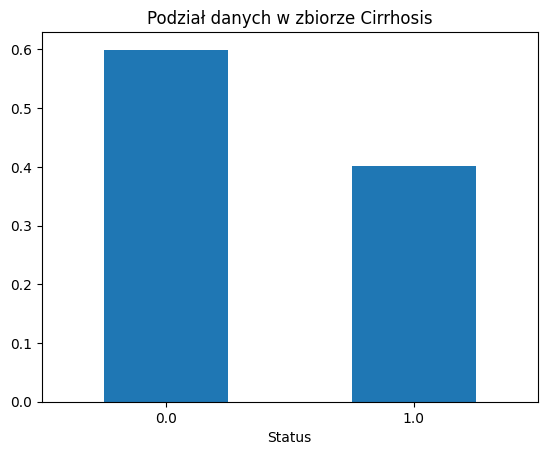

In [ ]:
(df_cirrhosis['Status'] \
 .value_counts(normalize=True)\
 .plot(kind='bar'))
plt.xticks(rotation=0)
plt.title("Podział danych w zbiorze Cirrhosis")
plt.show()

W tym zbiorze danych 59.9% pacjentów przeżyło lub zostało poddanych transplantacji, podczas gdy 40% pacjentów zmarło w czasie obserwacji. Oznacza to, że w próbie pacjentów występuje nieco wyższy odsetek osób, które przeżyły lub zostały poddane transplantacji, w porównaniu do tych, którzy zmarli, jednak nie są to niezbalansowane dane.

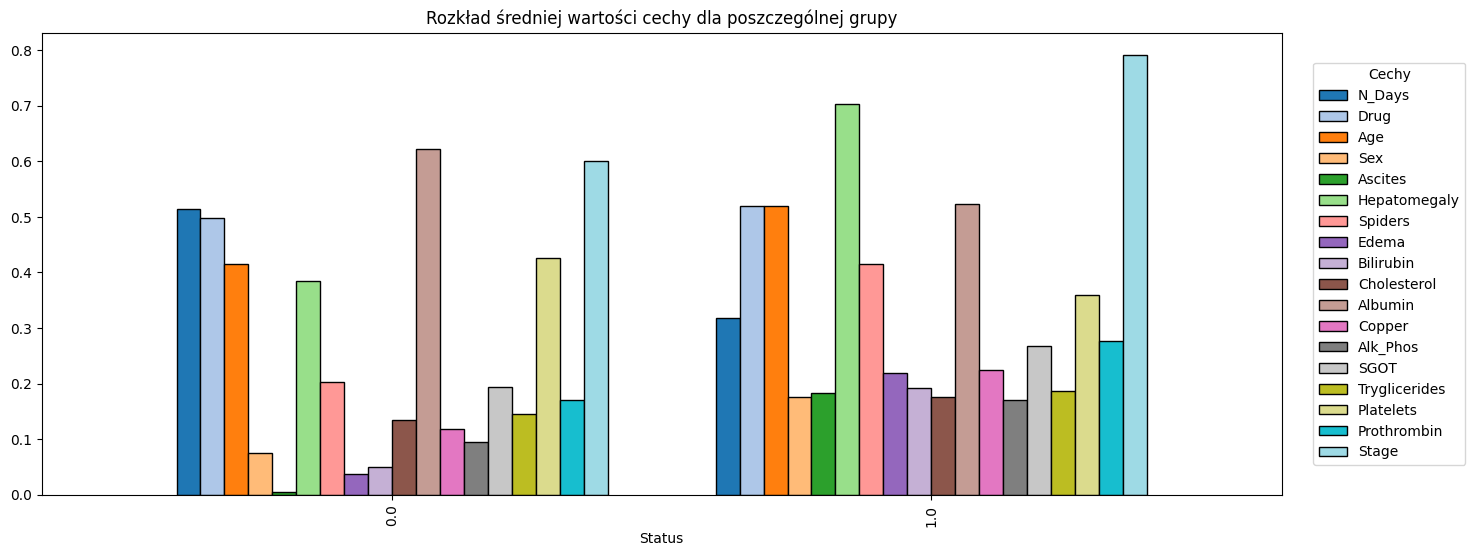

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))
df_cirrhosis.groupby("Status").mean().plot.bar(
    ax=ax,
    cmap="tab20",
    edgecolor="black",
    width=0.8
)

ax.legend(loc="center left", fontsize=10, bbox_to_anchor=(1.02,0.5),title="Cechy")
plt.title("Rozkład średniej wartości cechy dla poszczególnej grupy")
plt.show()

Na podstawie wykresu możemy stwierdzić pewne założenia związane z pacjentami, którzy przeżyli (Grupa 0.0), a tymi którzy zmarli (Grupa 1.0) w związku z chorobą wątroby:

* Pacjenci, którzy zmarli, znajdowali się średnio w bardziej zaawansowanym stadium choroby, na co wskazuje wyższa średnia dla `Stage`.
* Grupa zmarłych pacjentów charakteryzowała się średnio znacznie gorszą funkcją wątroby, co sugerują wyższe średnie wartości prawie wszystkich zmiennych związanych z badaniami oraz istotnie niższa średnia wartość `Albumin`.
* Objawy takie jak `Ascites` i `Edema`, występowały średnio znacznie częściej w grupie pacjentów, którzy zmarli. Podobnie, `Spiders` i `Hepatomegaly` były średnio częstsze w tej grupie.
* Pacjenci, którzy zmarli, byli średnio starsi od tych, którzy przeżyli lub mieli transplantację.
* Pacjenci, którzy przeżyli lub przeszli transplantację, byli obserwowani przez średnio dłuższy czas

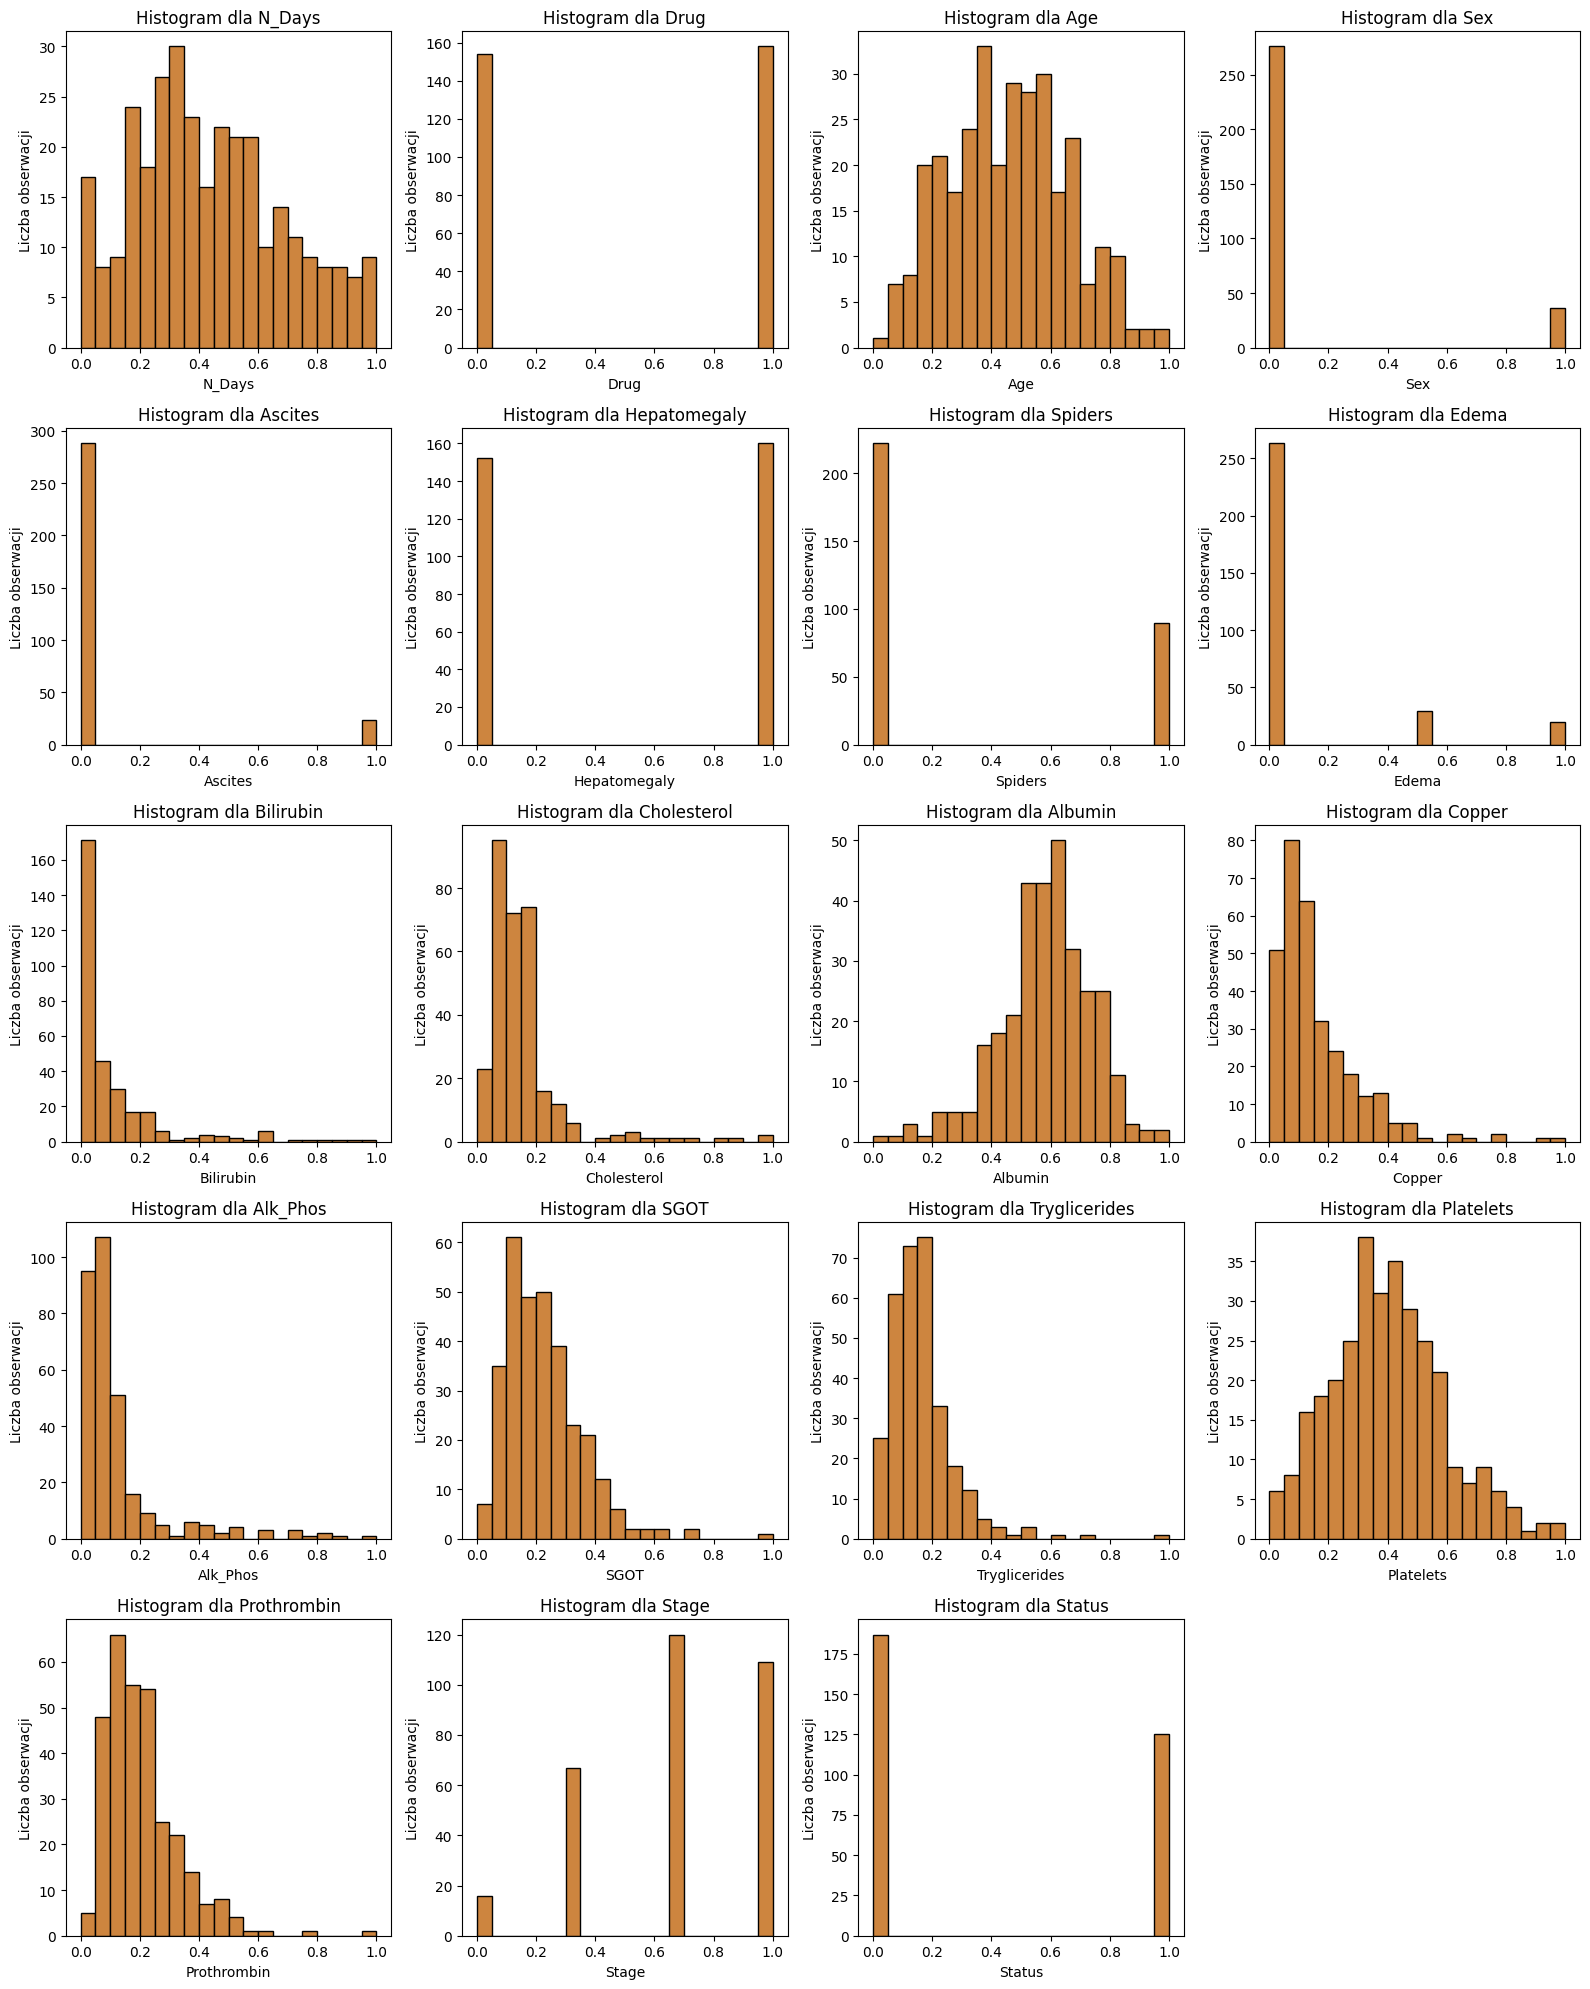

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(16, 20))
axes = axes.flatten()

#Histogram dla każdej kolumny w zbiorze df_cirrhosis
for i, column in enumerate(df_cirrhosis.columns):
    axes[i].hist(df_cirrhosis[column], bins=20, edgecolor='black', color='peru')
    axes[i].set_title(f"Histogram dla {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Liczba obserwacji")

axes[19].axis('off')
plt.tight_layout()
plt.show()

Zbiór danych `df_cirrhosis` zawiera dużą liczbę zmiennych ciągłych oraz zmiennych kategorycznych.
Cechy takie jak `Age`, `Albumin` i `Platelets` mają rozkład zbliżony do rozkładu normalnego, choć mogą wykazywać lekką skośność. Zmienna `N_days` ma szeroki rozkład.

Wiele cech, takich jak `Bilirubin`, `Cholesterol`, `Copper`, `Alk_Phos`, `SGOT`, `Tryglicerides` i `Prothrombin`, wykazuje silną prawoskośność. Oznacza to, że większość pacjentów ma stosunkowo niskie wartości tych parametrów, ale istnieje mniejsza grupa z wartościami znacznie podwyższonymi.

Na wykresach widzimy przede wszystkim dominację płci kobiecej oraz faktu, że u większości pacjentów cechy `Ascites` oraz `Edema` nie występują.
Dominacja jednej płci (Sex).

Większość pacjentów znajduje się w późniejszych stadiach choroby (stadium 3 i 4).

### Korelacja

In [ ]:
df_cirrhosis.corr()

N_Days    Drug     Age     Sex  Ascites  Hepatomegaly  Spiders  \
N_Days         1.0000  0.0084 -0.1316 -0.0199  -0.3071       -0.2881  -0.2664   
Drug           0.0084  1.0000  0.1343  0.0556   0.0444       -0.1029  -0.0082   
Age           -0.1316  0.1343  1.0000  0.2097   0.2312        0.0754  -0.0498   
Sex           -0.0199  0.0556  0.2097  1.0000   0.0087        0.0509  -0.1414   
Ascites       -0.3071  0.0444  0.2312  0.0087   1.0000        0.1610   0.1613   
Hepatomegaly  -0.2881 -0.1029  0.0754  0.0509   0.1610        1.0000   0.2951   
Spiders       -0.2664 -0.0082 -0.0498 -0.1414   0.1613        0.2951   1.0000   
Edema         -0.3520  0.0124  0.2203  0.0373   0.5857        0.1710   0.2723   
Bilirubin     -0.4418 -0.0857  0.0399 -0.0307   0.3783        0.3017   0.2883   
Cholesterol   -0.1306 -0.0183 -0.1513 -0.0112  -0.0543        0.1314   0.0595   
Albumin        0.4358 -0.0090 -0.1959  0.0510  -0.3893       -0.2992  -0.2337   
Copper        -0.3641 -0.0001  0.0599  0.2400   0.2222        0.2334   0.2603   
Alk_Phos       0.1493  0.0183 -0.0478  0.0322   0.0106        0.1102   0.0379   
SGOT          -0.2255 -0.0420 -0.1509 -0.0036   0.0923        0.1360   0.1307   
Tryglicerides -0.1445 -0.0081  0.0204  0.0495   0.1898        0.1525   0.0918   
Platelets      0.1908 -0.0336 -0.1406 -0.0965  -0.2154       -0.1890  -0.1610   
Prothrombin   -0.1683 -0.0732  0.1964  0.0998   0.3201        0.1874   0.2462   
Stage         -0.3716 -0.0663  0.1664  0.0211   0.2502        0.4673   0.2915   
Status        -0.3869  0.0222  0.2513  0.1551   0.3285        0.3127   0.2302   

                Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  \
N_Days        -0.3520    -0.4418      -0.1306   0.4358 -0.3641    0.1493   
Drug           0.0124    -0.0857      -0.0183  -0.0090 -0.0001    0.0183   
Age            0.2203     0.0399      -0.1513  -0.1959  0.0599   -0.0478   
Sex            0.0373    -0.0307      -0.0112   0.0510  0.2400    0.0322   
Ascites        0.5857     0.3783      -0.0543  -0.3893  0.2222    0.0106   
Hepatomegaly   0.1710     0.3017       0.1314  -0.2992  0.2334    0.1102   
Spiders        0.2723     0.2883       0.0595  -0.2337  0.2603    0.0379   
Edema          1.0000     0.4046      -0.1008  -0.4013  0.2564    0.0235   
Bilirubin      0.4046     1.0000       0.3806  -0.3346  0.4565    0.1170   
Cholesterol   -0.1008     0.3806       1.0000  -0.0640  0.1230    0.1401   
Albumin       -0.4013    -0.3346      -0.0640   1.0000 -0.2643   -0.1015   
Copper         0.2564     0.4565       0.1230  -0.2643  1.0000    0.1873   
Alk_Phos       0.0235     0.1170       0.1401  -0.1015  0.1873    1.0000   
SGOT           0.1407     0.4417       0.3373  -0.2200  0.2935    0.1122   
Tryglicerides  0.0774     0.4185       0.2768  -0.0947  0.2725    0.1687   
Platelets     -0.2326    -0.0868       0.1780   0.2030 -0.0641    0.1428   
Prothrombin    0.3897     0.3617      -0.0294  -0.2340  0.2179    0.0894   
Stage          0.2521     0.2414       0.0104  -0.3370  0.2683    0.0413   
Status         0.3264     0.4292       0.1561  -0.3103  0.3595    0.2340   

                 SGOT  Tryglicerides  Platelets  Prothrombin   Stage  Status  
N_Days        -0.2255        -0.1445     0.1908      -0.1683 -0.3716 -0.3869  
Drug          -0.0420        -0.0081    -0.0336      -0.0732 -0.0663  0.0222  
Age           -0.1509         0.0204    -0.1406       0.1964  0.1664  0.2513  
Sex           -0.0036         0.0495    -0.0965       0.0998  0.0211  0.1551  
Ascites        0.0923         0.1898    -0.2154       0.3201  0.2502  0.3285  
Hepatomegaly   0.1360         0.1525    -0.1890       0.1874  0.4673  0.3127  
Spiders        0.1307         0.0918    -0.1610       0.2462  0.2915  0.2302  
Edema          0.1407         0.0774    -0.2326       0.3897  0.2521  0.3264  
Bilirubin      0.4417         0.4185    -0.0868       0.3617  0.2414  0.4292  
Cholesterol    0.3373         0.2768     0.1780      -0.0294  0.0104  0.1561  
Albu

In [ ]:
df_cirrhosis.corr(method="spearman")

N_Days    Drug     Age     Sex  Ascites  Hepatomegaly  Spiders  \
N_Days         1.0000  0.0124 -0.1261 -0.0489  -0.3102       -0.2991  -0.2668   
Drug           0.0124  1.0000  0.1342  0.0556   0.0444       -0.1029  -0.0082   
Age           -0.1261  0.1342  1.0000  0.1883   0.2114        0.0843  -0.0521   
Sex           -0.0489  0.0556  0.1883  1.0000   0.0087        0.0509  -0.1414   
Ascites       -0.3102  0.0444  0.2114  0.0087   1.0000        0.1610   0.1613   
Hepatomegaly  -0.2991 -0.1029  0.0843  0.0509   0.1610        1.0000   0.2951   
Spiders       -0.2668 -0.0082 -0.0521 -0.1414   0.1613        0.2951   1.0000   
Edema         -0.3367  0.0191  0.1966  0.0376   0.5032        0.1753   0.2583   
Bilirubin     -0.5041 -0.0113 -0.0083  0.1103   0.2743        0.3901   0.3467   
Cholesterol   -0.0833  0.0535 -0.1436 -0.0021  -0.1037        0.0942  -0.0069   
Albumin        0.4333 -0.0035 -0.1560  0.0747  -0.3239       -0.3042  -0.2289   
Copper        -0.4306 -0.0205  0.0000  0.2421   0.1927        0.2797   0.2680   
Alk_Phos      -0.0328 -0.0135 -0.1478 -0.0039   0.0319        0.1651   0.0923   
SGOT          -0.2796 -0.0420 -0.1838  0.0205   0.0845        0.1621   0.1548   
Tryglicerides -0.1672 -0.0523  0.0235  0.0878   0.1327        0.1531  -0.0070   
Platelets      0.1963 -0.0419 -0.1437 -0.0828  -0.2189       -0.2026  -0.1562   
Prothrombin   -0.1737 -0.0307  0.1569  0.1280   0.3146        0.2208   0.2440   
Stage         -0.3886 -0.0490  0.1676  0.0335   0.2697        0.4693   0.2979   
Status        -0.4038  0.0222  0.2484  0.1551   0.3285        0.3127   0.2302   

                Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  \
N_Days        -0.3367    -0.5041      -0.0833   0.4333 -0.4306   -0.0328   
Drug           0.0191    -0.0113       0.0535  -0.0035 -0.0205   -0.0135   
Age            0.1966    -0.0083      -0.1436  -0.1560  0.0000   -0.1478   
Sex            0.0376     0.1103      -0.0021   0.0747  0.2421   -0.0039   
Ascites        0.5032     0.2743      -0.1037  -0.3239  0.1927    0.0319   
Hepatomegaly   0.1753     0.3901       0.0942  -0.3042  0.2797    0.1651   
Spiders        0.2583     0.3467      -0.0069  -0.2289  0.2680    0.0923   
Edema          1.0000     0.2958      -0.1318  -0.3206  0.1939    0.0329   
Bilirubin      0.2958     1.0000       0.3758  -0.3691  0.6233    0.3577   
Cholesterol   -0.1318     0.3758       1.0000  -0.0254  0.1939    0.3903   
Albumin       -0.3206    -0.3691      -0.0254   1.0000 -0.3010   -0.1854   
Copper         0.1939     0.6233       0.1939  -0.3010  1.0000    0.2797   
Alk_Phos       0.0329     0.3577       0.3903  -0.1854  0.2797    1.0000   
SGOT           0.1056     0.5863       0.3348  -0.2362  0.4050    0.4074   
Tryglicerides  0.0495     0.3426       0.3953  -0.0745  0.2957    0.2211   
Platelets     -0.2231    -0.2108       0.2354   0.1957 -0.0802    0.1669   
Prothrombin    0.3464     0.3015      -0.1292  -0.2101  0.2082    0.0905   
Stage          0.2493     0.3910      -0.0071  -0.3504  0.2961    0.1299   
Status         0.3053     0.4994       0.1501  -0.2840  0.4057    0.2634   

                 SGOT  Tryglicerides  Platelets  Prothrombin   Stage  Status  
N_Days        -0.2796        -0.1672     0.1963      -0.1737 -0.3886 -0.4038  
Drug          -0.0420        -0.0523    -0.0419      -0.0307 -0.0490  0.0222  
Age           -0.1838         0.0235    -0.1437       0.1569  0.1676  0.2484  
Sex            0.0205         0.0878    -0.0828       0.1280  0.0335  0.1551  
Ascites        0.0845         0.1327    -0.2189       0.3146  0.2697  0.3285  
Hepatomegaly   0.1621         0.1531    -0.2026       0.2208  0.4693  0.3127  
Spiders        0.1548        -0.0070    -0.1562       0.2440  0.2979  0.2302  
Edema          0.1056         0.0495    -0.2231       0.3464  0.2493  0.3053  
Bilirubin      0.5863         0.3426    -0.2108       0.3015  0.3910  0.4994  
Cholesterol    0.3348         0.3953     0.2354      -0.1292 -0.0071  0.1501  
Albu

In [ ]:
df_cirrhosis.corr(method="kendall")

N_Days    Drug     Age     Sex  Ascites  Hepatomegaly  Spiders  \
N_Days         1.0000  0.0102 -0.0814 -0.0400  -0.2537       -0.2446  -0.2182   
Drug           0.0102  1.0000  0.1111  0.0556   0.0444       -0.1029  -0.0082   
Age           -0.0814  0.1111  1.0000  0.1560   0.1751        0.0698  -0.0431   
Sex           -0.0400  0.0556  0.1560  1.0000   0.0087        0.0509  -0.1414   
Ascites       -0.2537  0.0444  0.1751  0.0087   1.0000        0.1610   0.1613   
Hepatomegaly  -0.2446 -0.1029  0.0698  0.0509   0.1610        1.0000   0.2951   
Spiders       -0.2182 -0.0082 -0.0431 -0.1414   0.1613        0.2951   1.0000   
Edema         -0.2714  0.0188  0.1596  0.0369   0.4940        0.1721   0.2536   
Bilirubin     -0.3459 -0.0094 -0.0075  0.0914   0.2274        0.3234   0.2874   
Cholesterol   -0.0600  0.0440 -0.1009 -0.0017  -0.0852        0.0774  -0.0057   
Albumin        0.2957 -0.0029 -0.1049  0.0613  -0.2659       -0.2497  -0.1879   
Copper        -0.2946 -0.0168 -0.0015  0.1986   0.1581        0.2295   0.2198   
Alk_Phos      -0.0253 -0.0110 -0.0983 -0.0032   0.0261        0.1351   0.0755   
SGOT          -0.1869 -0.0344 -0.1258  0.0168   0.0692        0.1329   0.1269   
Tryglicerides -0.1142 -0.0430  0.0152  0.0722   0.1092        0.1259  -0.0058   
Platelets      0.1345 -0.0343 -0.0971 -0.0678  -0.1793       -0.1659  -0.1279   
Prothrombin   -0.1133 -0.0256  0.1078  0.1068   0.2623        0.1841   0.2034   
Stage         -0.3039 -0.0457  0.1304  0.0312   0.2517        0.4380   0.2781   
Status        -0.3303  0.0222  0.2057  0.1551   0.3285        0.3127   0.2302   

                Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos  \
N_Days        -0.2714    -0.3459      -0.0600   0.2957 -0.2946   -0.0253   
Drug           0.0188    -0.0094       0.0440  -0.0029 -0.0168   -0.0110   
Age            0.1596    -0.0075      -0.1009  -0.1049 -0.0015   -0.0983   
Sex            0.0369     0.0914      -0.0017   0.0613  0.1986   -0.0032   
Ascites        0.4940     0.2274      -0.0852  -0.2659  0.1581    0.0261   
Hepatomegaly   0.1721     0.3234       0.0774  -0.2497  0.2295    0.1351   
Spiders        0.2536     0.2874      -0.0057  -0.1879  0.2198    0.0755   
Edema          1.0000     0.2412      -0.1065  -0.2615  0.1555    0.0267   
Bilirubin      0.2412     1.0000       0.2699  -0.2569  0.4587    0.2489   
Cholesterol   -0.1065     0.2699       1.0000  -0.0171  0.1354    0.2704   
Albumin       -0.2615    -0.2569      -0.0171   1.0000 -0.2085   -0.1284   
Copper         0.1555     0.4587       0.1354  -0.2085  1.0000    0.1885   
Alk_Phos       0.0267     0.2489       0.2704  -0.1284  0.1885    1.0000   
SGOT           0.0855     0.4202       0.2339  -0.1625  0.2736    0.2904   
Tryglicerides  0.0397     0.2367       0.2743  -0.0490  0.2048    0.1500   
Platelets     -0.1788    -0.1457       0.1597   0.1302 -0.0538    0.1109   
Prothrombin    0.2824     0.2040      -0.0856  -0.1428  0.1412    0.0608   
Stage          0.2293     0.3049      -0.0044  -0.2684  0.2300    0.0992   
Status         0.2997     0.4140       0.1233  -0.2332  0.3327    0.2154   

                 SGOT  Tryglicerides  Platelets  Prothrombin   Stage  Status  
N_Days        -0.1869        -0.1142     0.1345      -0.1133 -0.3039 -0.3303  
Drug          -0.0344        -0.0430    -0.0343      -0.0256 -0.0457  0.0222  
Age           -0.1258         0.0152    -0.0971       0.1078  0.1304  0.2057  
Sex            0.0168         0.0722    -0.0678       0.1068  0.0312  0.1551  
Ascites        0.0692         0.1092    -0.1793       0.2623  0.2517  0.3285  
Hepatomegaly   0.1329         0.1259    -0.1659       0.1841  0.4380  0.3127  
Spiders        0.1269        -0.0058    -0.1279       0.2034  0.2781  0.2302  
Edema          0.0855         0.0397    -0.1788       0.2824  0.2293  0.2997  
Bilirubin      0.4202         0.2367    -0.1457       0.2040  0.3049  0.4140  
Cholesterol    0.2339         0.2743     0.1597      -0.0856 -0.0044  0.1233  
Albu

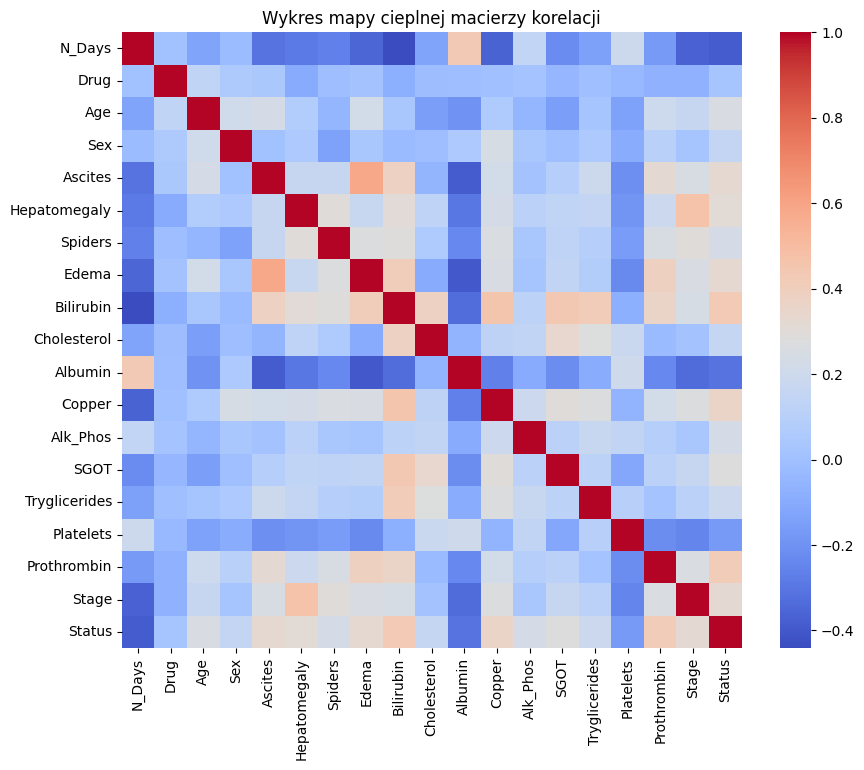

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_cirrhosis.corr(), cmap="coolwarm")
plt.title("Wykres mapy cieplnej macierzy korelacji")
plt.show()

Na podstawie mapy cieplnej korelacji dla danych dotyczących marskości wątroby możemy stwierdzić, że w zbiorze danych występują pewne zależności liniowe, choć nie wszystkie zmienne są ze sobą silnie skorelowane.
Można zauważyć korelacje dodatnie pomiędzy wskaźnikami pogorszenia stanu wątroby i zaawansowania choroby. Największą dodatnią korelację mają zmienne, które są kategoryczne: osiągają wartości 0 lub 1. Przykładem są zmienne `Ascites` oraz `Edema`.

Widoczne są również znaczące korelacje ujemne. Największą liczbę korelacji mają zmienne `N_days` oraz `Albumin`. Najważniejszą ujemną korelacją jest `N_days` oraz `Status`.
Wiele par zmiennych wykazuje jednak słabe korelacje liniowe, co sugeruje brak silnych bezpośrednich powiązań liniowych między nimi.
Obecność tych korelacji, potwierdza, że przebieg choroby jest procesem złożonym, zależnym od wielu powiązanych czynników.

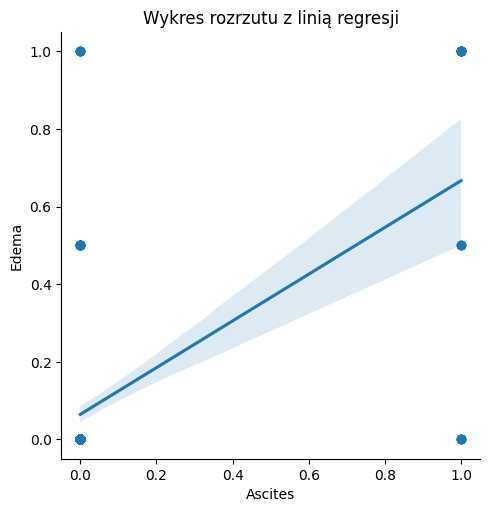

In [ ]:
sns.lmplot(x='Ascites', y='Edema', data=df_cirrhosis)
plt.title("Wykres rozrzutu z linią regresji")
plt.show()

Wykres wizualnie potwierdza silną dodatnią zależność liniową między dwoma cechami.
Punkty na wykresie pokazują, że pacjenci z nasilonym wodobrzuszem często mają również nasilone obrzęki.

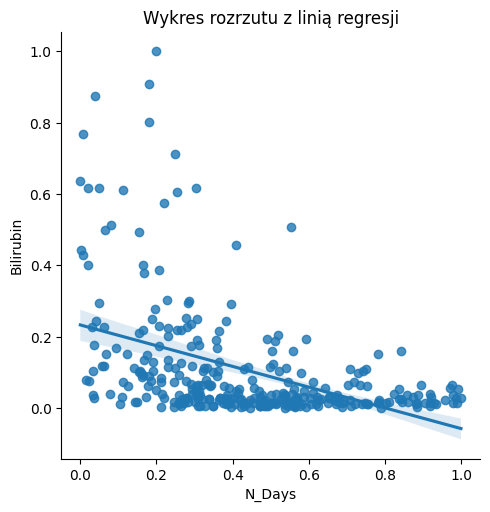

In [ ]:
sns.lmplot(x='N_Days', y='Bilirubin', data=df_cirrhosis)
plt.title("Wykres rozrzutu z linią regresji")
plt.show()

Mamy tutaj przykład dwóch zmiennych ciągłych, gdzie uzyskaliśmy przykład jednej z największych ujemnych korelacji dla zbioru danych.
Widoczna jest ujemna zależność liniowa - im dłuższy czas obserwacji, tym niższy poziom bilirubiny.
Sugeruje to, że pacjenci z niższym poziomem bilirubiny przeżywają dłużej lub są obserwowani przez dłuższy czas.

Mimo trendu, występuje duży rozrzut punktów, zwłaszcza przy krótszym czasie obserwacji, gdzie poziomy bilirubiny są bardzo zróżnicowane.

### PCA - Principal Component Analysis

In [ ]:
pca = PCA(n_components=2)

cirrhosis_pca = pca.fit_transform(df_cirrhosis.drop(columns="Status"))
df_cirrhosis_pca = pd.DataFrame(cirrhosis_pca, columns=["pca_0", "pca_1"])
df_cirrhosis_pca.sample(n=5)

pca_0   pca_1
160 -0.6137 -0.6074
5    0.1815 -0.5558
63   0.2842 -0.5296
279 -0.6211  0.3942
132 -0.4129 -0.5011

In [ ]:
colors, mapping = pd.factorize(df_cirrhosis["Status"])
colors, mapping

(array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 

<Axes: xlabel='pca_0', ylabel='pca_1'>

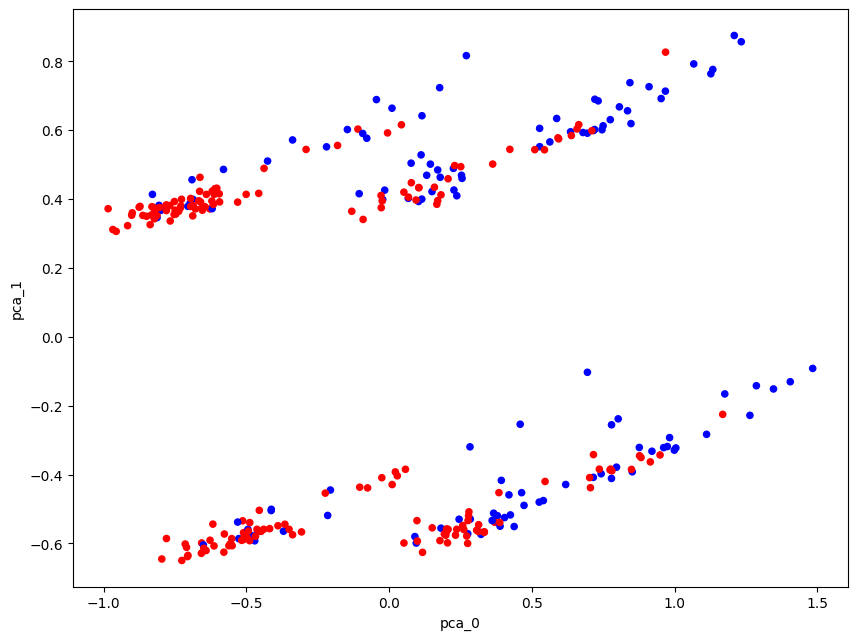

In [ ]:
df_cirrhosis_pca.plot.scatter(x="pca_0", y="pca_1",
                              c=colors, cmap="bwr", colorbar=False,
                              figsize=(10.0, 7.5))

Na podstawie wykresu rozrzutu dwóch pierwszych głównych składowych (PCA) dla danych `df_cirrhosis` można stwierdzić, że da się wyznaczyć jakąś prostą oddzielającą jeden zbiór od drugiego zbioru.

Jednak mimo, że punkty nie są rozłożone losowo i tworzą pewne skupiska, to ta struktura nie pokrywa się w prosty sposób z podziałem na klasy `Status`. Nie zapewniają one wyraźniej separacji liniowej i proste modele liniowe mogą mieć trudności z osiągnięciem wysokiej dokłądności w klasyfikacji stanu pacjentów na podstawie tych danych.

### t-SNE - t-distributed Stochastic Neighbor Embedding

In [ ]:
tsne = TSNE(n_components=2)

cirrhosis_tsne = tsne.fit_transform(df_cirrhosis.drop(columns="Status"))
df_cirrhosis_tsne = pd.DataFrame(cirrhosis_tsne, columns=["tsne_0", "tsne_1"])
df_cirrhosis_tsne.sample(n=5)

tsne_0   tsne_1
55   -2.0515 -11.8583
199 -10.7759  -6.3785
62   -0.3693  -6.5372
148   3.4985   1.6264
130  -0.3237  -9.5788

In [ ]:
colors, mapping = pd.factorize(df_cirrhosis["Status"])
colors, mapping

(array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 

<Axes: xlabel='tsne_0', ylabel='tsne_1'>

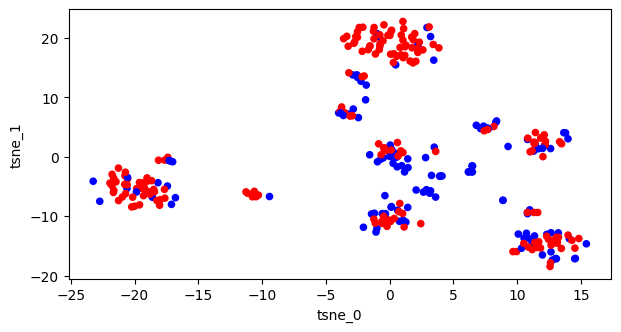

In [ ]:
df_cirrhosis_tsne.plot.scatter(x="tsne_0", y="tsne_1",
                               c=colors, cmap="bwr", colorbar=False,
                               figsize=(7.0, 3.5))

t-SNE, jako algorytm nieliniowy, ujawnił istnienie kilku wyraźnych klastrów punktów w przestrzeni dwuwymiarowej. Oznacza to, że istnieją grupy pacjentów o podobnych profilach cech. Większość z tych klastrów nie jest jednak jednorodna pod względem klasy `Status`. Obserwujemy znaczące przemieszanie punktów czerwonych i niebieskich w obrębie poszczególnych skupisk. Nie ma wyraźnej linii separacji między obiema klasami.

Wynik t-SNE, podobnie jak PCA, sugeruje, że związek między cechami pacjentów a ich statusem końcowym jest złożony.

### Regresja logistyczna

In [ ]:
X_cirrhosis = df_cirrhosis.drop('Status', axis=1)  #Zmienne niezależne
y_cirrhosis = df_cirrhosis['Status']  #Zmienna zależna
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cirrhosis, y_cirrhosis, test_size=0.3, random_state=123)

In [ ]:
# Model regresji logistycznej
model_log_cirrhosis = LogisticRegression()
model_log_cirrhosis.fit(X_train_c, y_train_c)
y_pred_log_cirrhosis = model_log_cirrhosis.predict(X_test_c)

Macierz błędów

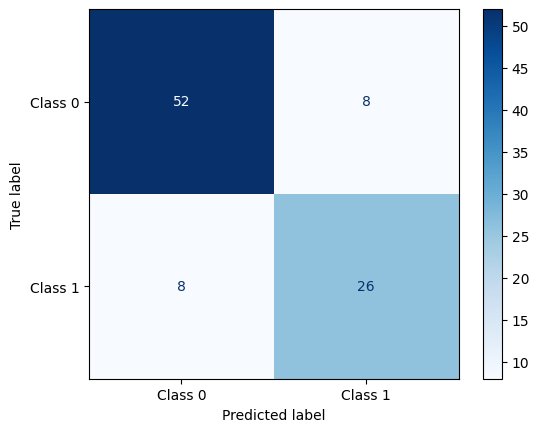

In [ ]:
cm_cirrhosis = confusion_matrix(y_test_c, y_pred_log_cirrhosis)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cirrhosis,
                              display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues")
plt.show()

Model regresji logistycznej wskazał dobrą zdolność predykcyjną w klasyfikacji statusu pacjentów. Osiągnął wysoką liczbę poprawnych klasyfikacji (78 z 94 przypadków). Bardzo wysoka liczba TN I TP wskazuje na dobry model do klasyfikacji.

Zidentyfikowano 16 błędnych klasyfikacji, w tym 8 pacjentów, którzy zmarli (klasa 1) i zostali zaklasyfikowani jako żyjący/po transplantacji wątroby oraz 8 pacjentów, którzy zostali zaklasyfikowani jako zmarli, a nadal żyli.

Metryki oceny modelu

In [ ]:
accuracy_c = accuracy_score(y_test_c, y_pred_log_cirrhosis)
precision_c = precision_score(y_test_c, y_pred_log_cirrhosis)
recall_c = recall_score(y_test_c, y_pred_log_cirrhosis)
f1_c = f1_score(y_test_c, y_pred_log_cirrhosis)

mse_c = mean_squared_error(y_test_c, y_pred_log_cirrhosis)
rmse_c = np.sqrt(mse_c)
r2_c = r2_score(y_test_c, y_pred_log_cirrhosis)

print(f"Accuracy: {accuracy_c}")
print(f"Precision: {precision_c}")
print(f"Recall: {recall_c}")
print(f"F1-Score: {f1_c}")
print(f"MSE: {mse_c}")
print(f"RMSE: {rmse_c}")
print(f"R^2 Score: {r2_c}")

Accuracy: 0.8297872340425532
Precision: 0.7647058823529411
Recall: 0.7647058823529411
F1-Score: 0.7647058823529411
MSE: 0.1702127659574468
RMSE: 0.41256849850351734
R^2 Score: 0.262745098039216


Model osiągnął dokładność na poziomie blisko 83%, co oznacza, że poprawnie klasyfikuje większość przypadków w zbiorze testowym. Zarówno precyzja, jak i czułość dla klasy pozytywnej wynoszą około 76.5%. Gdy model przewiduje, że pacjent należy do klasy 1, jest to poprawne w około 76.5% przypadków. Pozostałe 23.5% to przypadki fałszywie pozytywne.

Wartość F1-Score, również wynosi 0.765. Potwierdza to zrównoważoną wydajność modelu.
Wartości MSE (0.17) i RMSE (0.41) wskazują na umiarkowany błąd w szacowaniu prawdopodobieństwa przynależności do danej klasy.

Jednak warto wskazać, że wartość R^2 wynosząca 0.26 jest bardzo niska. Model liniowy wyjaśnia jedynie niewielką część zmienności w przynależności do klas, co może wskazywać na istnienie złożonych, nieliniowych zależności w danych.

### Regresja logistyczna z walidacją krzyżową

In [ ]:
# Model regresji logistycznej z walidacją krzyżową
lr_cirrhosis = LogisticRegression(penalty=None, max_iter=10000)
scores_log_cirrhosis = cross_validate(
    lr_cirrhosis, X_cirrhosis, y_cirrhosis, cv=10, return_train_score=True,
    scoring=("accuracy", "precision", "recall", "f1")
)
scores_log_cirrhosis

{'fit_time': array([0.01416421, 0.01588082, 0.01377106, 0.01102829, 0.01150823,
        0.01628661, 0.01197863, 0.0130825 , 0.00945139, 0.01350927]),
 'score_time': array([0.01839876, 0.01603293, 0.01965547, 0.01496911, 0.01657081,
        0.01740742, 0.01470828, 0.02099729, 0.01678801, 0.01875949]),
 'test_accuracy': array([0.6875    , 0.84375   , 0.83870968, 0.90322581, 0.80645161,
        0.77419355, 0.80645161, 0.74193548, 0.80645161, 0.74193548]),
 'train_accuracy': array([0.84285714, 0.83928571, 0.83629893, 0.83629893, 0.84341637,
        0.84697509, 0.84341637, 0.85053381, 0.84697509, 0.85053381]),
 'test_precision': array([0.61538462, 0.9       , 0.83333333, 0.91666667, 0.88888889,
        1.        , 0.71428571, 0.66666667, 0.75      , 0.61111111]),
 'train_precision': array([0.84693878, 0.86021505, 0.82352941, 0.85106383, 0.84      ,
        0.85      , 0.84158416, 0.85148515, 0.86458333, 0.85858586]),
 'test_recall': array([0.61538462, 0.69230769, 0.76923077, 0.84615385, 0.6

Na podstawie wyników 10-krotnej walidacji krzyżowej dla modelu możemy stwierdzić, że średnia dokładność modelu na danych testowych wynosiła około 80%, a na danych treningowych 83%. Model ma zdolność do dobrej klasyfikacji nowych danych. Średni wynik F1-score również jest bardzo duży dla danych testowych - około 73%.
Wartości precyzji i czułości na zbiorze testowym różnią się. Model wydaje się być nieco lepszy w unikaniu fałszywie pozytywnych wartości niż w wykrywaniu wszystkich pozytywnych przypadków.

Istnieje zauważalna zmienność wyników między poszczególnymi foldami walidacji krzyżowej. Dokładność testowa waha się od 69% do 90%, a F1-score od 59% do 88%. Sugeruje to, że wydajność modelu może być wrażliwa na konkretny podział danych na zbiory treningowe i walidacyjne. Niektóre podzbiory danych mogą być trudniejsze do sklasyfikowania niż inne.

Wyniki na zbiorze treningowym były nieco wyższe niż odpowiadające im wyniki na zbiorze testowym, co może wskazywać na przeuczenie modelu.
Czasy dopasowania i predykcji są bardzo niskie, co świadczy o wysokiej wydajności obliczeniowej modelu.

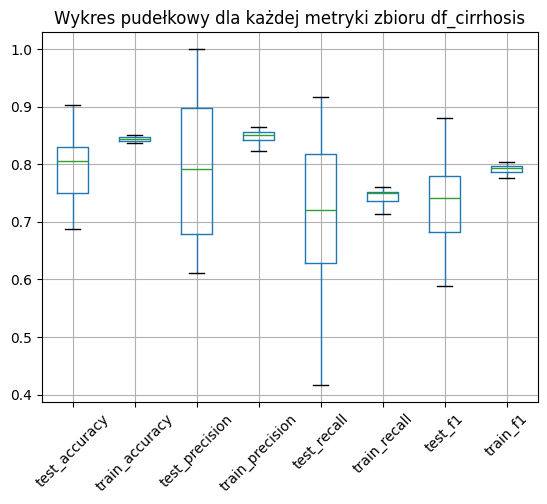

In [ ]:
scores_logistic_cirrhosis_df = pd.DataFrame(scores_log_cirrhosis)
scores_logistic_cirrhosis_df.drop(columns=["fit_time", "score_time"]).boxplot()
plt.title("Wykres pudełkowy dla każdej metryki zbioru df_cirrhosis")
plt.xticks(rotation=45)
plt.show()

Wykresy pudełkowe dla walidacji krzyżowej wskazują na to, że zakres międzykwartylowy oraz rozrzut w wartościach testowych był znacznie większy niż w przypadku wartości treningowych. Szczególnie metryki test_precision, test_recall i test_f1 wykazują znaczną zmienność. Oznacza to, że wydajność modelu w tych aspektach mocno zależy od konkretnego podziału danych użytego w danym kroku walidacji krzyżowej. Model nie jest równie skuteczny na wszystkich podzbiorach danych. Natomiast dla danych treningowych oznacza to, że model konsekwentnie osiąga podobne, wysokie wyniki na danych, na których był trenowany w każdym foldzie.

Porównanie rozkładów metryk testowych i treningowych wyraźnie ilustruje zjawisko lekkiego przeuczenia. Metryki treningowe mają nie tylko wyższe mediany, ale przede wszystkim są znacznie bardziej stabilne.

### Ranking istotności cech

In [ ]:
selector_cirrhosis = RFECV(lr_cirrhosis, step=1, min_features_to_select=1,
                            cv=5, scoring="f1")
selector_cirrhosis.fit(X_cirrhosis, y_cirrhosis)

RFECV(cv=5, estimator=LogisticRegression(max_iter=10000, penalty=None),
      scoring='f1')

In [ ]:
selected_features_cirrhosis = pd.DataFrame({
    "selected": selector_cirrhosis.support_,
    "ranking": selector_cirrhosis.ranking_
}, index=X_cirrhosis.columns)
selected_features_cirrhosis

selected  ranking
N_Days             True        1
Drug              False       11
Age                True        1
Sex               False        8
Ascites           False        2
Hepatomegaly      False        9
Spiders           False       10
Edema             False       12
Bilirubin          True        1
Cholesterol       False        7
Albumin           False        5
Copper            False        3
Alk_Phos           True        1
SGOT               True        1
Tryglicerides      True        1
Platelets         False        4
Prothrombin        True        1
Stage             False        6

In [ ]:
feature_names_cirrhosis = selected_features_cirrhosis[selected_features_cirrhosis["selected"] == True].index
feature_names_cirrhosis

Index(['N_Days', 'Age', 'Bilirubin', 'Alk_Phos', 'SGOT', 'Tryglicerides',
       'Prothrombin'],
      dtype='object')

Na podstawie algorytmu rankingu istotności cech jesteśmy w stanie zmniejszyć nasz zbiór danych tylko do cech istotnych dla modelu. Oznacza to, że możemy znacząco poprawić naszą klasyfikację za pomocą zawęzienia liczby kolumn.
Zbiór df_cirrhosis zawęził się do cech: `N_Days`, `Age`, `Bilirubin`, `Alk_Phos`, `SGOT`, `Tryglicerides`, `Prothrombin`.

In [ ]:
#zapisanie zbioru danych z wybranymi cechami
df_cirrhosis_new = df_cirrhosis[feature_names_cirrhosis.tolist() + ["Status"]]
df_cirrhosis_new

N_Days    Age  Bilirubin  Alk_Phos   SGOT  Tryglicerides  Prothrombin  \
0    0.0795 0.6226     0.5126    0.1053 0.2590         0.2460       0.3951   
1    0.9876 0.5849     0.0289    0.5235 0.2023         0.0973       0.1975   
2    0.2151 0.8491     0.0397    0.0167 0.1619         0.0389       0.3704   
3    0.4173 0.5472     0.0542    0.4297 0.0796         0.1044       0.1605   
4    0.3240 0.2264     0.1119    0.0281 0.2014         0.0690       0.2346   
..      ...    ...        ...       ...    ...            ...          ...   
307  0.2463 0.6792     0.0036    0.0374 0.1500         0.1416       0.1728   
308  0.2111 0.6226     0.0036    0.0646 0.1013         0.0867       0.2222   
309  0.1989 0.6981     0.0505    0.1049 0.3357         0.1186       0.1481   
310  0.1767 0.2264     0.0614    0.0561 0.2104         0.0973       0.1852   
311  0.1654 0.1321     0.2202    0.1345 0.2545         0.2053       0.2222   

     Status  
0    1.0000  
1    0.0000  
2    1.0000  
3    1.0000  
4    0.0000  
..      ...  
307  0.0000  
308  0.0000  
309  0.0000  
310  0.0000  
311  0.0000  

[312 rows x 8 columns]

In [ ]:
colors, mapping = pd.factorize(df_cirrhosis_new["Status"])
colors, mapping

(array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 

Zależności między cechami

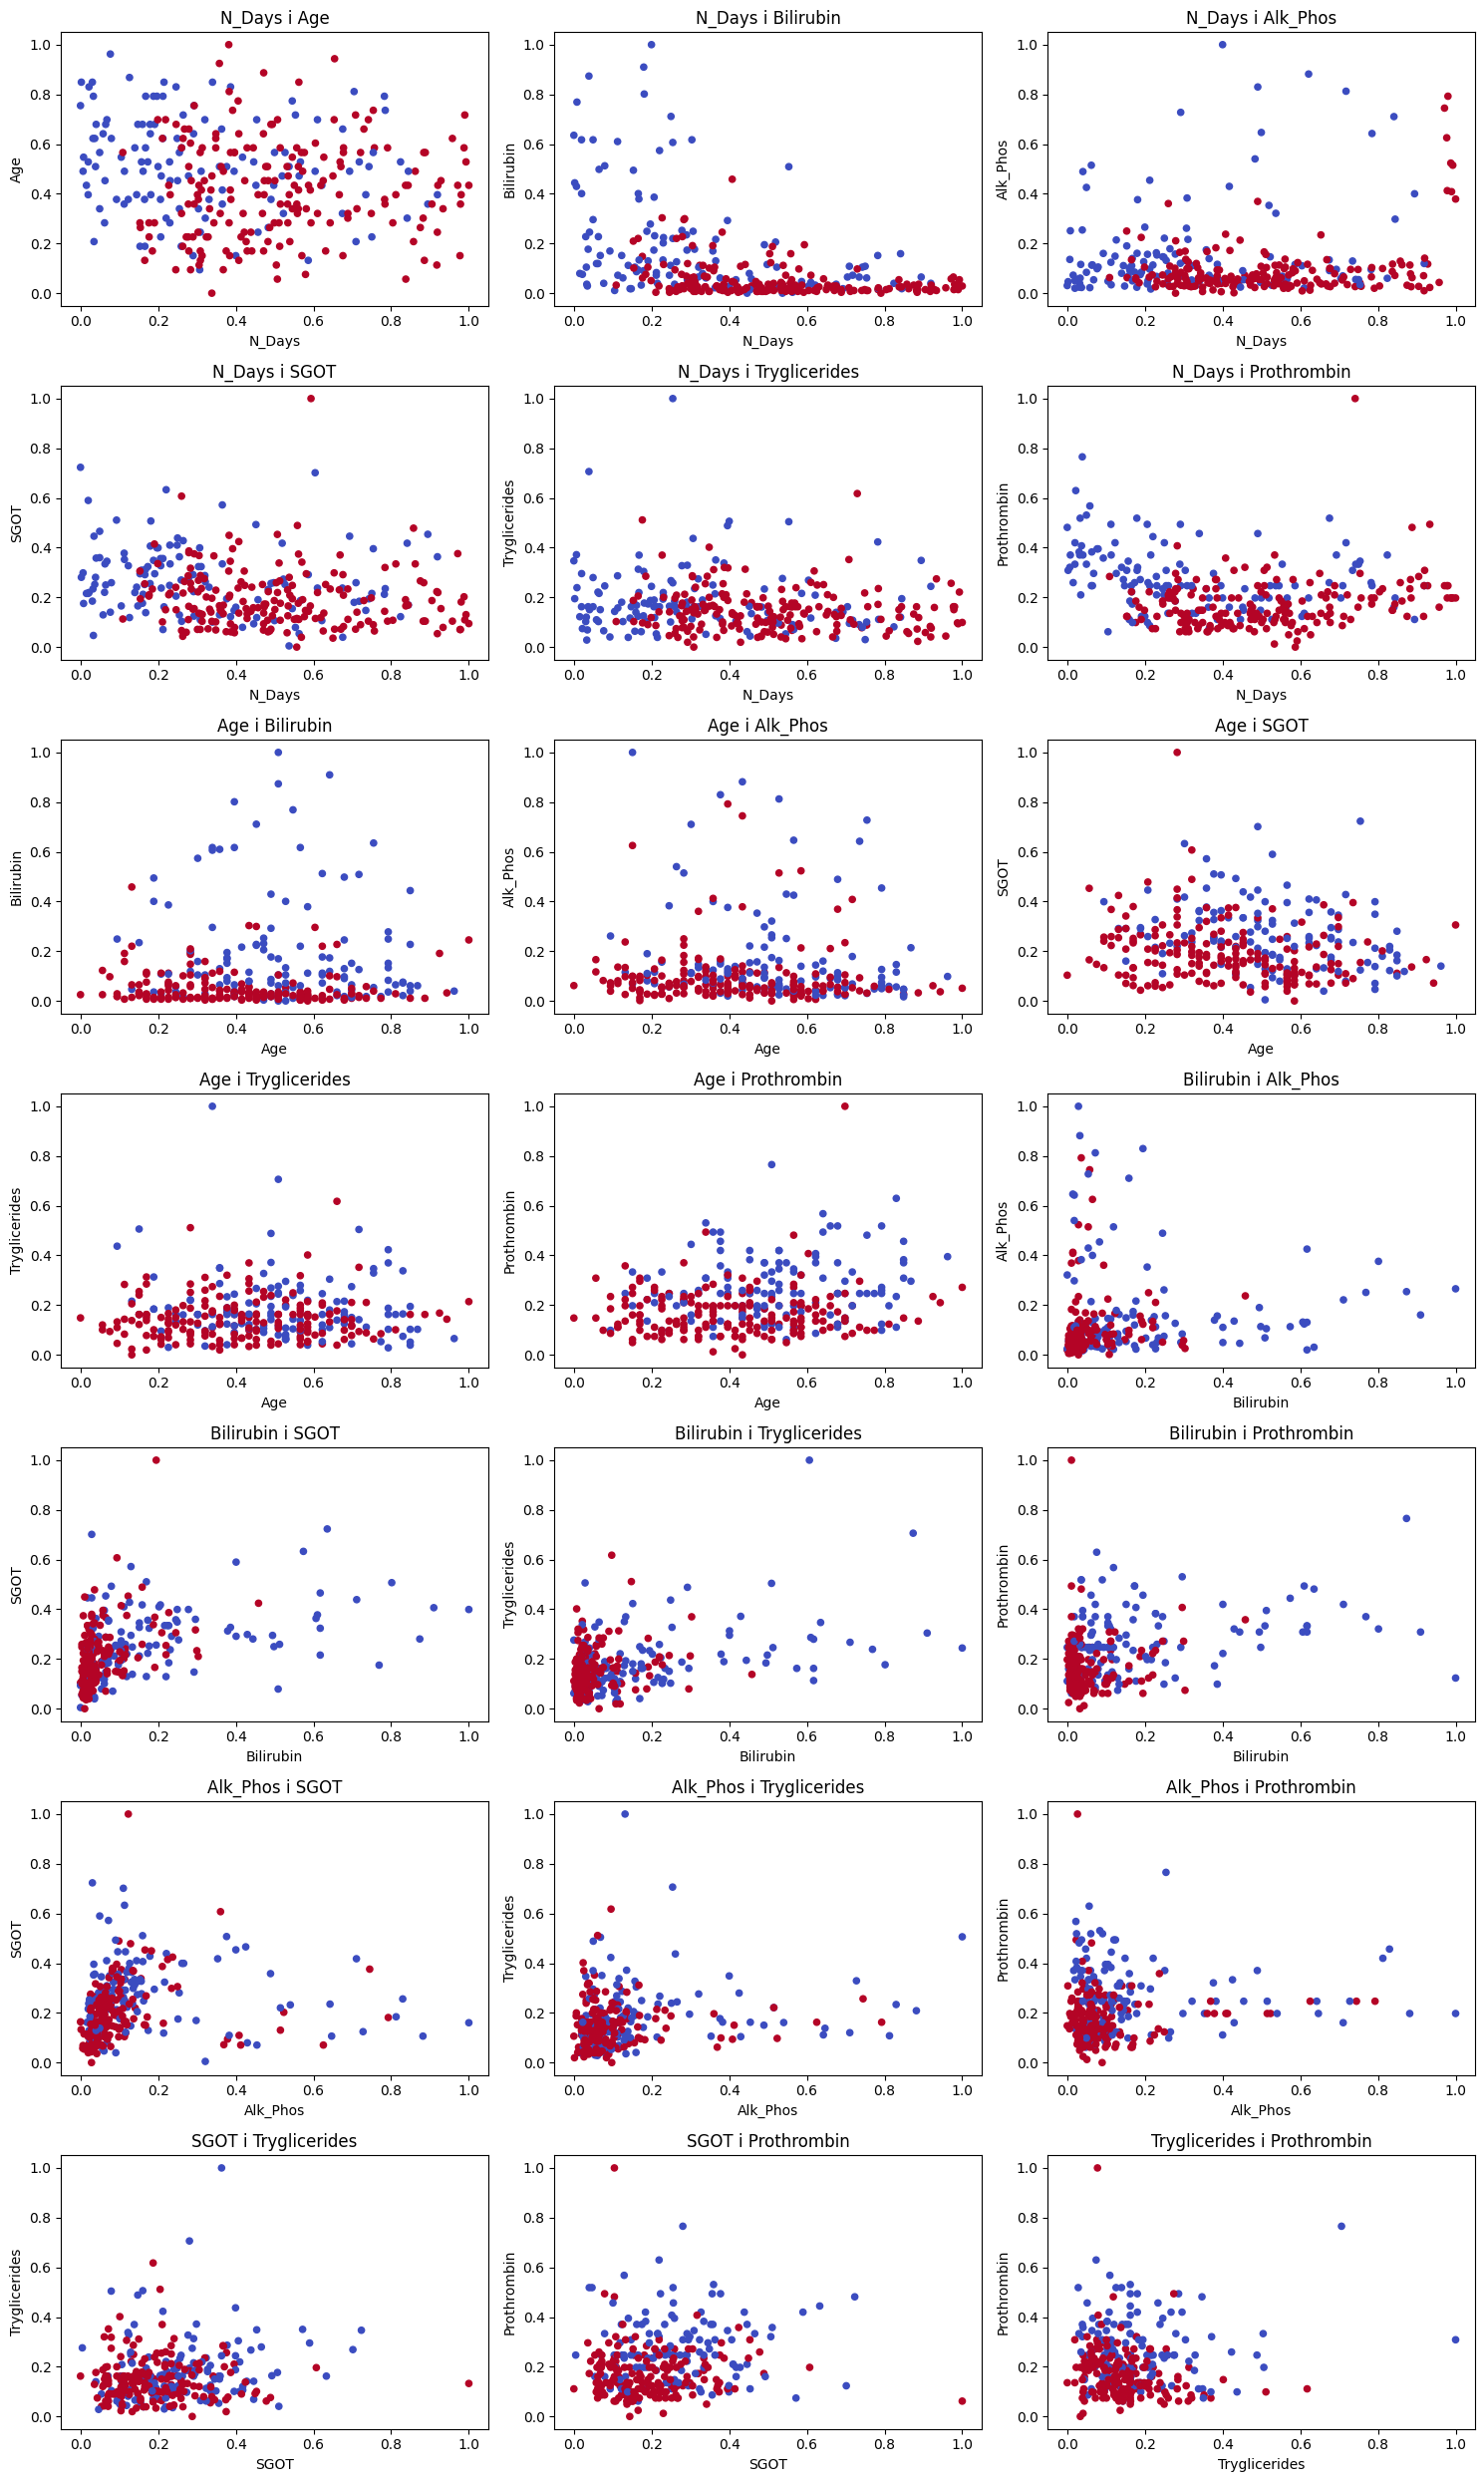

In [ ]:
columns = df_cirrhosis_new.columns[:-1]
fig, axes = plt.subplots(7, 3, figsize=(15, 25))
axes = axes.flatten()

for idx, (x, y) in enumerate(itertools.combinations(columns, 2)):
    df_cirrhosis_new.plot.scatter(x=x, y=y, c=colors, cmap="coolwarm", colorbar=False, ax=axes[idx])
    axes[idx].set_title(f"{x} i {y}")

plt.tight_layout()
plt.show()

Na podstawie wykresów rozrzutu par cech można stwierdzić, że ze zmiennych zostały już tylko zmienne ciągłe, a zostały usunięte wszystkie kategoryczne.
Potwierdzają się ujemne zależności widoczne wcześniej, np. między `N_Days` a zmiennymi `Bilirubin`, `Alk_Phos`, `SGOT`, `Prothrombin` – im dłuższy czas obserwacji, tym niższe wartości tych markerów.

Zależności z udziałem zmiennej `Age` i `Tryglicerides` wydają się słabsze i mniej wyraźne na tych wykresach.

Żadna z przedstawionych par cech nie pozwala na wyraźne, liniowe oddzielenie pacjentów z różnym statusem. W każdym wykresie obserwujemy znaczące przemieszanie punktów czerwonych i niebieskich. Obserwacje te są spójne z wynikami PCA i t-SNE.

### Regresja logistyczna dla cech istotnych

In [ ]:
X_cirrhosis_ist = df_cirrhosis_new.drop('Status', axis=1)  #Zmienne niezależne
y_cirrhosis_ist = df_cirrhosis_new['Status']  #Zmienna zależna
X_train_c_ist, X_test_c_ist, y_train_c_ist, y_test_c_ist = train_test_split(X_cirrhosis_ist, y_cirrhosis_ist, test_size=0.3, random_state=123)

In [ ]:
# Model regresji logistycznej dla cech istotnych
model_cirrhosis_log_ist = LogisticRegression()
model_cirrhosis_log_ist.fit(X_train_c_ist, y_train_c_ist)
y_pred_log_ist_cirrhosis = model_cirrhosis_log_ist.predict(X_test_c_ist)

Macierz błędów

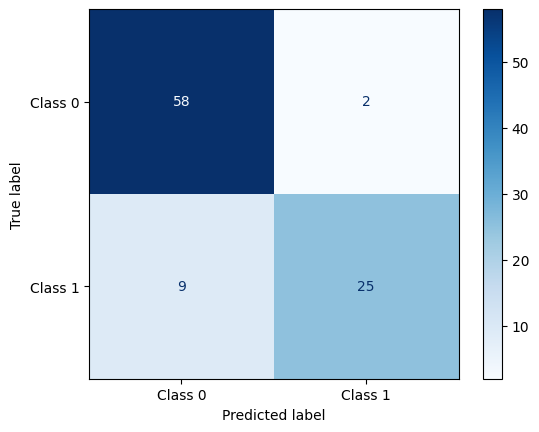

In [ ]:
cm_c = confusion_matrix(y_test_c_ist, y_pred_log_ist_cirrhosis)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm_c,
                              display_labels=["Class 0", "Class 1"])
matrix.plot(cmap="Blues")
plt.show()

Model demonstruje bardzo dobrą skuteczność, poprawnie klasyfikując 83 z 94 przypadków. Jest to 5 przypadków więcej niż w poprzedniej analizie na całym zbiorze danych.

Model poprawnie zidentyfikował 58 z 60 pacjentów z Klasy 0 (czyli potrafi zidentyfikować żyjącego pacjenta) i popełnił tylko 2 błędy (przypadki Fałszywie Pozytywne).
Natomiast popełnił 9 błędów przy poprawnej klasyfikacji zmarłych pacjentów, których przyporządkował jako żyjących (Fałszywie Negatywne). Poprawnie zidentyfikował 25 z 34 pacjentów z klasy 1.

Metryki oceny modelu

In [ ]:
accuracy_c_ist = accuracy_score(y_test_c_ist, y_pred_log_ist_cirrhosis)
precision_c_ist = precision_score(y_test_c_ist, y_pred_log_ist_cirrhosis)
recall_c_ist = recall_score(y_test_c_ist, y_pred_log_ist_cirrhosis)
f1_c_ist = f1_score(y_test_c_ist, y_pred_log_ist_cirrhosis)

mse_c_ist = mean_squared_error(y_test_c_ist, y_pred_log_ist_cirrhosis)
rmse_c_ist = np.sqrt(mse_c_ist)
r2_c_ist = r2_score(y_test_c_ist, y_pred_log_ist_cirrhosis)

print(f"Accuracy: {accuracy_c_ist}")
print(f"Precision: {precision_c_ist}")
print(f"Recall: {recall_c_ist}")
print(f"F1-Score: {f1_c_ist}")
print(f"MSE: {mse_c_ist}")
print(f"RMSE: {rmse_c_ist}")
print(f"R^2 Score: {r2_c_ist}")

Accuracy: 0.8829787234042553
Precision: 0.9259259259259259
Recall: 0.7352941176470589
F1-Score: 0.819672131147541
MSE: 0.11702127659574468
RMSE: 0.3420837274641176
R^2 Score: 0.4931372549019609


Model osiągnął bardzo wysoką dokładność na poziomie 88.3%, co wskazuje na jego znaczną zdolność do poprawnego klasyfikowania większości przypadków w zbiorze testowym. Jest to lekka poprawa w stosunku do modelu bazowego.

Precyzja dla klasy 1.0 jest bardzo wysoka i wynosi 92.6%. Oznacza to, że gdy model przewiduje przynależność do klasy 1, jest to wysoce wiarygodne.
Natomiast czułość dla klasy 1.0 wynosi 73.5% i jest to już gorszy wynik. Model źle zaklasyfikował ponad 26% przypadków z klasy 1 jako przypadki z klasy 0.

Wartość F1-Score na poziomie 82.0% wskazuje na dobry ogólny balans między precyzją, a czułością dla klasy pozytywnej.
Wartości MSE (0.117) i RMSE (0.342) są niższe niż w poprzednim modelu, co wskazuje na bardziej dokładne szacowanie prawdopodobieństwa przynależności do klas przez ten model.
Wartość R^2 wynosząca 49.3% jest również wyższa niż poprzednio i sugeruje że model lepiej wyjaśnia zmienność w danych związaną z przynależnością do klas.

### Regresja logistyczna z walidacją krzyżową dla cech istotnych

In [ ]:
#Model regresji logistycznej z walidacją krzyżową dla cech istotnych
lr_cirrhosis_ist = LogisticRegression(penalty=None, max_iter=10000)
scores_log_ist_cirrhosis = cross_validate(
    lr_cirrhosis_ist, X_cirrhosis_ist, y_cirrhosis_ist, cv=10, return_train_score=True,
    scoring=("accuracy", "precision", "recall", "f1")
)
scores_log_ist_cirrhosis

{'fit_time': array([0.00729895, 0.00522041, 0.00626159, 0.00481439, 0.00537586,
        0.00694227, 0.00576949, 0.0060358 , 0.00539303, 0.00653934]),
 'score_time': array([0.01022935, 0.01152372, 0.00978994, 0.00968909, 0.01009393,
        0.01220155, 0.00953412, 0.00951219, 0.01010084, 0.00955081]),
 'test_accuracy': array([0.6875    , 0.90625   , 0.83870968, 0.90322581, 0.90322581,
        0.70967742, 0.77419355, 0.77419355, 0.77419355, 0.70967742]),
 'train_accuracy': array([0.82857143, 0.80714286, 0.82562278, 0.81494662, 0.81850534,
        0.85053381, 0.82562278, 0.83985765, 0.82918149, 0.82918149]),
 'test_precision': array([0.61538462, 1.        , 0.9       , 0.91666667, 1.        ,
        0.8       , 0.69230769, 0.77777778, 0.69230769, 0.57894737]),
 'train_precision': array([0.82      , 0.82222222, 0.82474227, 0.8125    , 0.81443299,
        0.84466019, 0.82653061, 0.84      , 0.83505155, 0.82828283]),
 'test_recall': array([0.61538462, 0.76923077, 0.69230769, 0.84615385, 0.7

Dokładność na zbiorach testowych jest zróżnicowana i waha się od 69% do aż 91% między poszczególnymi foldami walidacji.
Również takie wahania występują w czułości, f1-score oraz precyzji (gdzie waha się ona drastycznie od 58% do 100%). Ta wydajność modelu na danych testowych jest bardzo niestabilna. Wiarygodność predykcji modelu jest wysoce zależna od konkretnego podziału danych. W niektórych przypadkach model działa lepiej niż w innych. Jest to model o wysokiej wariancji.

Porównanie wyników testowych z treningowymi pokazuje wyraźne oznaki przeuczenia zbioru. Wyniki na zbiorach treningowych są względnie wyższe i bardziej stabilne.
Model bardzo dobrze dopasowuje się do danych treningowych w każdym foldzie.

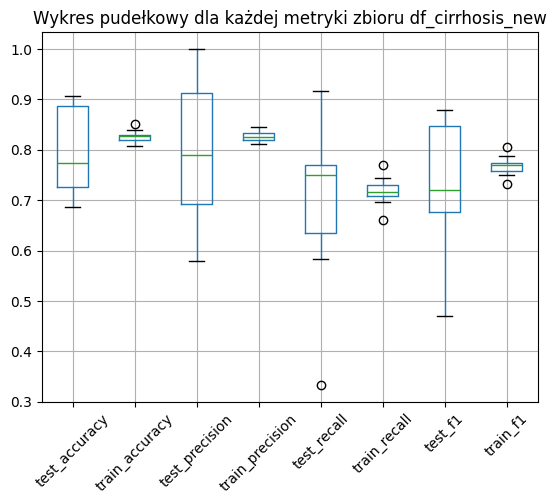

In [ ]:
scores_logistic_df_c = pd.DataFrame(scores_log_ist_cirrhosis)
scores_logistic_df_c.drop(columns=["fit_time", "score_time"]).boxplot()
plt.title("Wykres pudełkowy dla każdej metryki zbioru df_cirrhosis_new")
plt.xticks(rotation=45)
plt.show()

Wykres pudełkowy ilustruje wspomnianą wysoką zmienną wyników modelu na danych testowych. Jest to widoczne w postaci szerokich pudełek na wykresie ramka-wąsy.

Rozkłady test_precision i test_recall są najbardziej szerokie. Precyzja w niektórych foldach osiąga idealne 1.0, podczas gdy w innych spada poniżej 0.6. Podobnie, czułość waha się od bardzo niskich wartości (nawet poniżej 0.4) do ponad 0.9. Oznacza to, że zdolność modelu do unikania fałszywie pozytywnych klasyfikacji jest zależny od podziału danych wejściowych. Jest to model podatny na przeuczenie.

W przeciwieństwie do metryk testowych, metryki treningowe charakteryzują się znacznie większą stabilnością, na co wskazują wąskie pudełka i krótkie wąsy. Mediany tych metryk są również wyższe niż mediany metryk testowych.

### KNN - K-najbliższych sąsiadów

In [ ]:
#Model KNN
model_cirrhosis_knn = KNeighborsClassifier(n_neighbors=2)
model_cirrhosis_knn.fit(X_train_c, y_train_c)
y_pred_c_knn = model_cirrhosis_knn.predict(X_test_c)

Macierz błędów

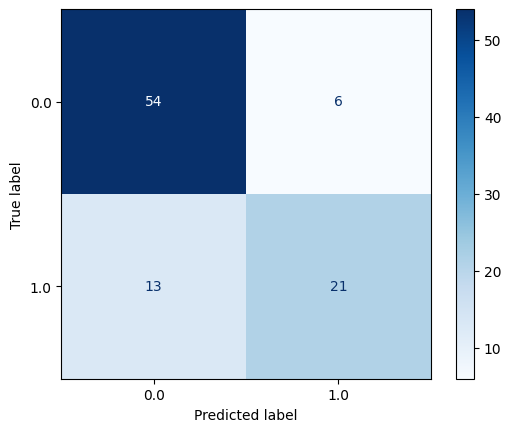

In [ ]:
cm_knn_c = confusion_matrix(y_test_c, y_pred_c_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn_c, display_labels=model_cirrhosis_knn.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy:", accuracy_score(y_test_c, y_pred_c_knn))
print("Classification Report:\n", classification_report(y_test_c, y_pred_c_knn))

Accuracy: 0.7978723404255319
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.90      0.85        60
         1.0       0.78      0.62      0.69        34

    accuracy                           0.80        94
   macro avg       0.79      0.76      0.77        94
weighted avg       0.80      0.80      0.79        94



Model KNN osiągnął dobrą ogólną dokładność klasyfikacji na poziomie około 80%, poprawnie przypisując większość pacjentów do odpowiednich klas.

Model jest szczególnie skuteczny w identyfikacji pacjentów z klasy 0 i osiąga bardzo wysoką czułość na poziomie 90%.
Dla klasy 0 mamy o wiele niższą czułość wynoszącą 62%. Model nie jest w stanie wykryć aż 38% pacjentów, którzy faktycznie zmarli. Jest to skutek wysokiej liczby fałszywie negatywnych klasyfikacji. Natomiast liczba fałszywie pozytywnych klasyfikacji jest niższa i osiągnęła liczbę 6 przypadków.

Najlepiej model radzi sobie z klasyfikacją klasy 0.0, ale i tak osiąga całkiem dobre wyniki f1-score dla obu grup.

### Szukanie najlepszej liczby n_neighbors dla KNN

In [ ]:
grid_cv = GridSearchCV(KNeighborsClassifier(),
                       param_grid={
                           "n_neighbors": range(2, 50)
                       }, cv=5, scoring="f1",
                       verbose=1, n_jobs=6)

In [ ]:
grid_cv.fit(X_train_c, y_train_c)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=6,
             param_grid={'n_neighbors': range(2, 50)}, scoring='f1', verbose=1)

In [ ]:
grid_cv.best_params_

{'n_neighbors': 5}

In [ ]:
knn = grid_cv.best_estimator_
knn

KNeighborsClassifier()

Wynik optymalizacji hiperparametrów dla modelu KNN wskazał liczbę `n_neighbors` = 5. Jest to taka wartość, która maksymalizuje średni wynik F1-score na danych walidacyjnych. Wynik ten różni się od początkowej wartości.

In [ ]:
f1_score(y_test_c, knn.predict(X_test_c))

0.6571428571428571

Najlepszy wynik F1-Score wyniósł około 0.66. Jest to umiarkowany wynik i wskazuje, że nawet po znalezieniu optymalnej liczby sąsiadów, model KNN ma ograniczenia w jednoczesnym balansowaniu precyzji i czułości. Nadal popełnia on znaczącą liczbę błędów.

### Model KNN dla najlepszego parametru best_estimator

In [ ]:
# Model KNN dla najlepszego parametru n_neighbors
model_cirrhosis_knn_best = KNeighborsClassifier(n_neighbors=5)
model_cirrhosis_knn_best.fit(X_train_c, y_train_c)
y_pred_c_knn_best = model_cirrhosis_knn_best.predict(X_test_c)

Macierz błędów

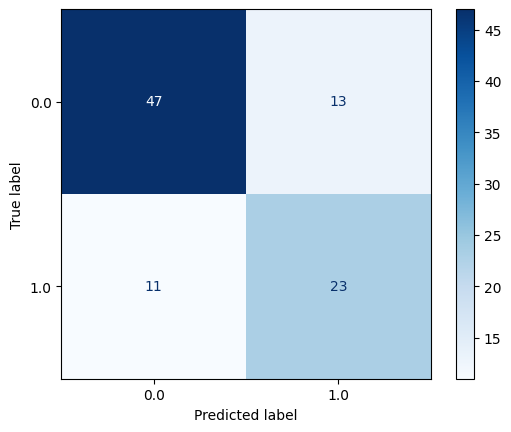

In [ ]:
cm_knn_c_best = confusion_matrix(y_test_c, y_pred_c_knn_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn_c_best, display_labels=model_cirrhosis_knn_best.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy:", accuracy_score(y_test_c, y_pred_c_knn_best))
print("Classification Report:\n", classification_report(y_test_c, y_pred_c_knn_best))

Accuracy: 0.7446808510638298
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.78      0.80        60
         1.0       0.64      0.68      0.66        34

    accuracy                           0.74        94
   macro avg       0.72      0.73      0.73        94
weighted avg       0.75      0.74      0.75        94



Model osiągnął dokładność na poziomie około 74.5%, co wskazuje na gorszy wynik niż poprzednio przy `n_neighbors` = 2. Jest to wynik wskazujący na całkiem dobrą zdolność predykcyjną, ale co czwarty przypadek jest klasyfikowany błędnie.
Dla klasy 0.0 precyzja wyniosła 81% i czułość 78%. F1-Score jest również niższy niż poprzednio i wynosi 0.8 zamiast 0.85.

Głównym problemem modelu jest jego wydajność dla klasy 1.0 - niska precyzja i niski F1-Score świadczą o gorszej klasyfikacji zmarłych. Gdy model przewiduje Klasę 1, jest to poprawne tylko w 64% przypadków. Występuje dużo fałszywie pozytywnych przypadków. 11 przypadków było zaklasyfikowanych jako fałszywie negatywnych.

### Wykres z podziałem na obszary klasyfikacji KNN

In [ ]:
#redukcja wymiarów do 2 za pomocą PCA
pca = PCA(n_components=2)
X_train_c_knn_pca = pca.fit_transform(X_train_c)
X_test_c_knn_pca = pca.transform(X_test_c)

model_cirrhosis_knn_pca = KNeighborsClassifier(n_neighbors=5)
model_cirrhosis_knn_pca.fit(X_train_c_knn_pca, y_train_c)
y_pred_c_knn_pca = model_cirrhosis_knn_pca.predict(X_test_c_knn_pca)

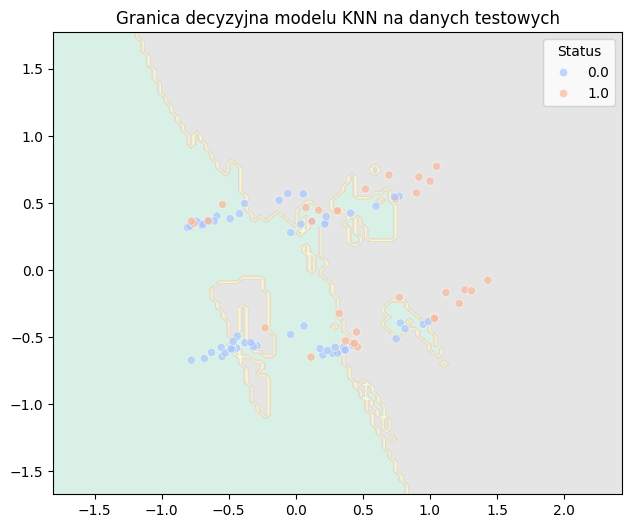

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(model_cirrhosis_knn_pca, X_test_c_knn_pca, response_method="predict", ax=ax, cmap="Pastel2", alpha=0.5)
sns.scatterplot(x=X_test_c_knn_pca[:, 0], y=X_test_c_knn_pca[:, 1], hue=y_test_c, alpha=0.7, ax=ax, palette="coolwarm")
ax.set_aspect("equal")
ax.set_title("Granica decyzyjna modelu KNN na danych testowych")
plt.show()

Wykres wyraźnie pokazuje, że model KNN stworzył nieliniową i złożoną granicę decyzyjną.
Granica dopasowuje się wokół grup punktów tworząc nieregularne kształty. Jest to zdolność modelu do adaptacji do lokalnych wzorców w danych, ale może też prowadzić do nadmiernego dopasowania.

Punkty pomarańczowe klasy 1.0 znajdujące się w przewidywanym regionie klasy 0.0 są najczęstszym błędem na wykresie. Jest to zgodne z macierzą błędów i niskim poziomem czułości dla klasy 1.0.

### KNN - dla cech istotnych

In [ ]:
grid_cv.fit(X_train_c_ist, y_train_c_ist)
grid_cv.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'n_neighbors': 7}

Na początkowym etapie warto dobrać optymalną wartość parametru `n_neighbors`, aby uzyskać jak najlepszą jakość klasyfikacji.

Wykorzystując kroswalidację za pomocą `GridSearchCV`, najlepszym wyborem okazała się wartość `n_neighbors` = 7, którą wykorzystam w dalszych krokach analizy.

In [ ]:
grid_cv.best_score_

np.float64(0.6533801434663504)

Model z parametrem `n_neighbors` = 7 został wybrany na podstawie wyboru elementu z maksymalną wartością F1-Score uzyskanej podczas kroswalidacji. Osiągnięty wynik wynosi około 0.65.

In [ ]:
# Model KNN dla cech istotnych
model_cirrhosis_knn_ist = KNeighborsClassifier(n_neighbors=7)
model_cirrhosis_knn_ist.fit(X_train_c_ist, y_train_c_ist)
y_pred_c_knn_ist = model_cirrhosis_knn_ist.predict(X_test_c_ist)

Macierz błędów

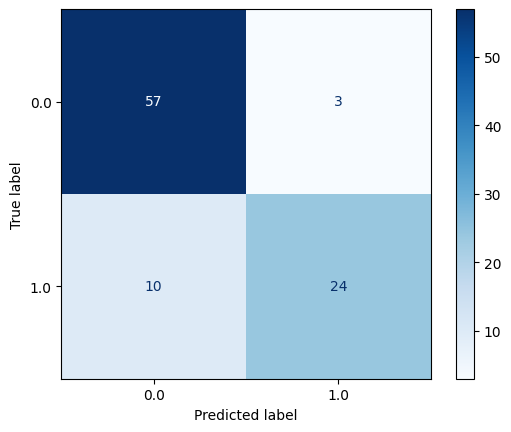

In [ ]:
cm_knn_c_ist = confusion_matrix(y_test_c_ist, y_pred_c_knn_ist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn_c_ist, display_labels=model_cirrhosis_knn_ist.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy:", accuracy_score(y_test_c_ist, y_pred_c_knn_ist))
print("Classification Report:\n", classification_report(y_test_c_ist, y_pred_c_knn_ist))

Accuracy: 0.8617021276595744
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.95      0.90        60
         1.0       0.89      0.71      0.79        34

    accuracy                           0.86        94
   macro avg       0.87      0.83      0.84        94
weighted avg       0.86      0.86      0.86        94



Model KNN działający tylko na wybranych, istotnych cechach oraz z doborem odpowiedniej wartości n_neighbors, osiągnął znacznie lepsze wyniki niż ten sam model działający na pełnym zestawie cech lub nawet po optymalizacji. Dokładność wzrosła do 86.2%, a F1-score dla Klasy 1 do 79%.

Model nadal bardzo dobrze radzi sobie z klasyfikacją dla klasy 0, osiągając bardzo wysoką czułość 95% i precyzję 85%.
Jednak najważniejsza zmiana to poprawa klasyfikacji dla klasy 1 - precyzja teraz wynosi 89% i oznacza, że gdy model przewiduje klasę 1 to jest wysoce wiarygodny. Mamy to potwierdzenie w macierzy błędów, gdzie nasz model zaklasyfikował tylko 3 przypadki jako fałszywie pozytywny wynik. F1-score dla Klasy 1 również wzrósł i wynosi teraz 79%.

Jedynym wynikiem, który mógłby wymagać poprawy jest wskaźnik recall na poziomie 0.71. Wpływa na niego liczba fałszywie negatywnych przypadków, gdzie model zamiast zaklasyfikować dane przypadki jako klasa 1, przypisał je klasie 0.

### Wykres z podziałem na obszary klasyfikacji KNN dla cech istotnych

In [ ]:
#redukcja wymiarów do 2 za pomocą PCA
pca = PCA(n_components=2)
X_train_c_knn_pca_ist = pca.fit_transform(X_train_c_ist)
X_test_c_knn_pca_ist = pca.transform(X_test_c_ist)

#Model KNN dla cech istotnych
model_cirrhosis_knn_pca_ist = KNeighborsClassifier(n_neighbors=7)
model_cirrhosis_knn_pca_ist.fit(X_train_c_knn_pca_ist, y_train_c_ist)

y_pred_c_knn_pca_ist = model_cirrhosis_knn_pca_ist.predict(X_test_c_knn_pca_ist)

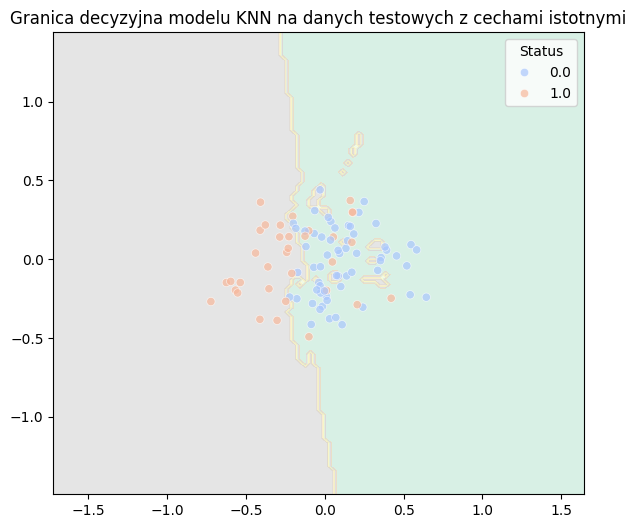

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(model_cirrhosis_knn_pca_ist, X_test_c_knn_pca_ist, response_method="predict", ax=ax, cmap="Pastel2", alpha=0.5)
sns.scatterplot(x=X_test_c_knn_pca_ist[:, 0], y=X_test_c_knn_pca_ist[:, 1], hue=y_test_c_ist, alpha=0.7, ax=ax, palette="coolwarm")
ax.set_aspect("equal")
ax.set_title("Granica decyzyjna modelu KNN na danych testowych z cechami istotnymi")
plt.show()

Granica decyzyjna o wiele lepiej dopasowała się do danych. Jest ona nadal nieliniowa i dopasowuje się do lokalnych struktur, ale zaczęła tworzyć bardziej spójne regiony niż granica na pełnym zbiorze cech. Sugeruje to, że usunięcie mniej istotnych cech pomogło modelowi skupić się na bardziej znaczących wzorcach.

Większość punktów niebieskich znajduje się w przewidzianej klasie 0 (co odpowiada liczbie fałszywie pozytywnych klasyfikacji z macierzy błędów). Gorzej wypadają punkty pomarańczowe, gdzie niektóre znajdują w przewidzianej klasie 0 (i odpowiada to większej liczbie fałszywie negatywnych klasyfikacji). Mimo poprawy, nadal jest to znaczące ograniczenie modelu do dobrego przewidywania danych.

Wybrane cechy istotne pozwalają na lepsze, choć wciąż nieidealne, rozdzielenie obu klas w porównaniu do pełnego zestawu danych. Punkty nadal się przenikają, ale ogólny trend separacji jest wyraźniejszy.

### SVM (Support Vector Machine) - LinearSVC()

In [ ]:
#Model SVM - LinearSVM()
model_cirrhosis_svm_linear = LinearSVC()
model_cirrhosis_svm_linear.fit(X_train_c, y_train_c)
y_pred_svm_c_linear = model_cirrhosis_svm_linear.predict(X_test_c)

Macierz błędów

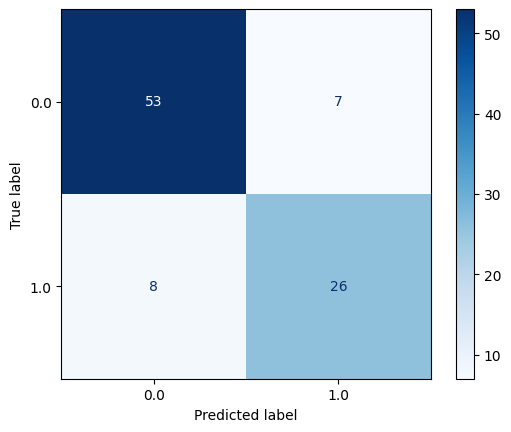

In [ ]:
cm_svm_c = confusion_matrix(y_test_c, y_pred_svm_c_linear)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_c, display_labels=model_cirrhosis_svm_linear.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy:", accuracy_score(y_test_c, y_pred_svm_c_linear))
print("Classification Report:\n", classification_report(y_test_c, y_pred_svm_c_linear))

Accuracy: 0.8404255319148937
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.88      0.88        60
         1.0       0.79      0.76      0.78        34

    accuracy                           0.84        94
   macro avg       0.83      0.82      0.83        94
weighted avg       0.84      0.84      0.84        94



Model osiągnął dobrą dokładność na poziomie 84% i dobrze klasyfikuje większość przypadków, co jest widoczne na macierzy błędów.

Wysoka precyzja na poziomie 87% oraz czułość na poziomie 88% dla klasy 0.0 oznaczają bardzo dobry wynik F1-Score. Dla klasy 1.0 wyniki są nieco niższe, jednak nadal F1-Score osiąga wysoki wynik - na poziomie 78%. Model popełnia stosunkowo zbalansowaną liczbę błędów dla obu klas: 7 przypadków fałszywie pozytywnych oraz 8 przypadków fałszywie negatywnych.

Model liniowy w tym przypadku sugeruje, że istnieje znaczący stopień liniowej separowalności między klasami w przestrzeni cech.
Jest to model dobrze zbalansowany pod względem błędów i osiąga średni poziom metryk na bardzo wysokim poziomie.

### SVM (Support Vector Machine) - kernel = "poly"

In [ ]:
# Model SVM - poly
model_cirrhosis_svm_poly = SVC(kernel="poly", degree=2)
model_cirrhosis_svm_poly.fit(X_train_c, y_train_c)
y_pred_svm_c_poly = model_cirrhosis_svm_poly.predict(X_test_c)

Macierz błędów

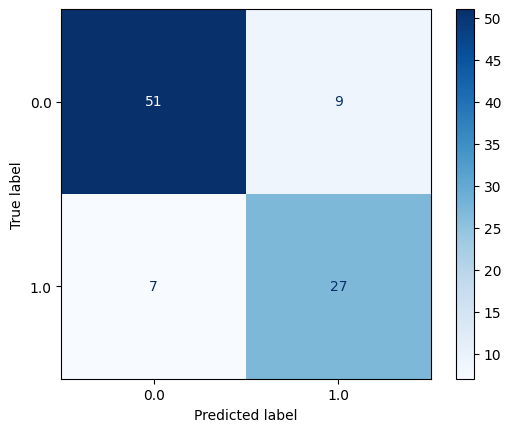

In [ ]:
cm_svm_c_poly = confusion_matrix(y_test_c, y_pred_svm_c_poly)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_c_poly, display_labels=model_cirrhosis_svm_poly.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy: ", accuracy_score(y_test_c, y_pred_svm_c_poly))
print("Classification Report:\n", classification_report(y_test_c, y_pred_svm_c_poly))

Accuracy:  0.8297872340425532
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.85      0.86        60
         1.0       0.75      0.79      0.77        34

    accuracy                           0.83        94
   macro avg       0.81      0.82      0.82        94
weighted avg       0.83      0.83      0.83        94



Wraz ze wzrostem wartości parametru `degree` dla jądra typu poly, model wykazywał systematyczny spadek dokładności oraz wzrost liczby błędnie sklasyfikowanych przypadków – co było widoczne w macierzy błędów.  

Najlepsze wyniki osiągnięto przy `degree = 2`, gdzie model uzyskał accuracy na poziomie 83%. Choć wynik ten jest nieznacznie niższy niż wcześniej, różnica sprowadza się jedynie do jednego dodatkowego przypadku zaklasyfikowanego jako fałszywie pozytywny. Klasa 0 miała bardzo wysoką precyzję i recall, natomiast klasa 1 miała nieco gorsze wyniki na poziomie 75% i 79%.

Model wydaje się być dobrze zbalansowany. Zarówno precyzja, jak i recall dla obu klas są na dobrym poziomie, a liczba błędów jest stosunkowo niska i zbliżona. Nie ma wyraźnej tendencji do faworyzowania jednej metryki. W tym przypadku, zastosowanie nieliniowego jądra nie przyniosło znaczącej poprawy w stosunku do prostszego modelu liniowego, a wyniki są minimalnie niższe. Sugeruje to, że dodatkowa złożoność może nie być konieczna.

### SVM (Support Vector Machine) - kernel = "rbf"

In [ ]:
# Model SVM - rbf
model_cirrhosis_svm_rbf = SVC(kernel="rbf")
model_cirrhosis_svm_rbf.fit(X_train_c, y_train_c)
y_pred_svm_c_rbf = model_cirrhosis_svm_rbf.predict(X_test_c)

Macierz błędów

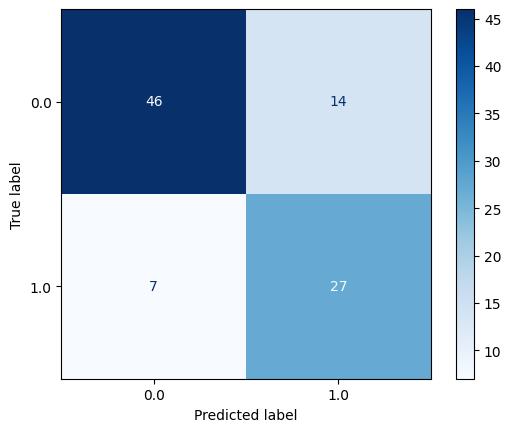

In [ ]:
cm_svm_c_rbf = confusion_matrix(y_test_c, y_pred_svm_c_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_c_rbf, display_labels=model_cirrhosis_svm_rbf.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy: ", accuracy_score(y_test_c, y_pred_svm_c_rbf))
print("Classification Report:\n", classification_report(y_test_c, y_pred_svm_c_rbf))

Accuracy:  0.776595744680851
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.77      0.81        60
         1.0       0.66      0.79      0.72        34

    accuracy                           0.78        94
   macro avg       0.76      0.78      0.77        94
weighted avg       0.79      0.78      0.78        94



Model osiągnął dokładność na poziomie około 77.7%. Wynik ten jest niższy niż w przypadku kilku wczęsniej testowanych modeli SVM. Zastosowanie jądra RBF jest najmniej optymalne.

Model SVM z jądrem RBF ma dobrą precyzję dla klasy 0.0, ale gorszą dokładność 77%. Błędnie klasyfikuje jako klasę 1 aż 23% pacjentów z Klasy 0. Pokazuje to również wysoka liczba przypadków fałszywie pozytywnych, która wyniosła 14.
Dla klasy 1 jest lepsza czułość, jednak gorsza precyzja. Niska liczba fałszywie negatywnych klasyfikacji spowodowała, że czułość wynosi 79%. Precyzja natomiast wynosi 66% i oznacza, że model w 1/3 przypadków klasyfikuje obiekty jako fałszywie pozytywne. Model wychwytuje większość przypadków klasy 1, ale robi to kosztem błędnego klasyfikowania przypadków z klasy 0.

Najbardziej stałym modelem oraz najlepszym pod względem dokładności i f1-score, był model SVM z jądrem liniowym.

### Wykres z podziałem na obszary klasyfikacji SVM dla funkcji jądra liniowego

In [ ]:
pca = PCA(n_components=2)
X_train_c_svm_pca = pca.fit_transform(X_train_c)
X_test_c_svm_pca = pca.transform(X_test_c)

model_cirrhosis_svm_pca = LinearSVC()
model_cirrhosis_svm_pca.fit(X_train_c_svm_pca, y_train_c)

y_pred_svm_c_pca = model_cirrhosis_svm_pca.predict(X_test_c_svm_pca)

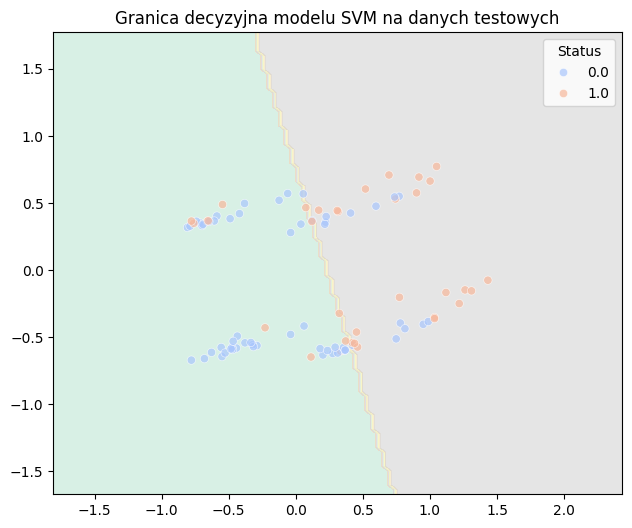

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(model_cirrhosis_svm_pca, X_test_c_svm_pca, response_method="predict", ax=ax, cmap="Pastel2", alpha=0.5)
sns.scatterplot(x=X_test_c_svm_pca[:, 0], y=X_test_c_svm_pca[:, 1], hue=y_test_c, alpha=0.7, ax=ax, palette="coolwarm")
ax.set_aspect("equal")
ax.set_title("Granica decyzyjna modelu SVM na danych testowych")
plt.show()

Wykres wyraźnie wyznaczył linię dzielącą obie klasy w zbiorze danych. Znaczna część punktów jest poprawnie sklasyfikowana. Istnieje jednak widoczny obszar przenikania się klas, w miejscu przecięcia linii, co prowadzi do błędów.

Jest stosunkowo mało niewłaściwych punktów, jednak nadal sprawiają one trudności w klasyfikacji danych. Wizualna liczba błędów wydaje się być zbalansowana, co jest zgodne z macierzą błędów. Wykres sugeruje, że dane najlepiej można rozdzielić wykorzystując liniowość. Prosta linia jest w stanie całkiem dobrze poradzić sobie z rozdzieleniem większości punktów.

### SVM (Support Vector Machine) - LinearSVC() dla cech istotnych

In [ ]:
#Model SVM - LinearSVM() z cechami istotnymi
model_cirrhosis_svm_ist = LinearSVC()
model_cirrhosis_svm_ist.fit(X_train_c_ist, y_train_c_ist)
y_pred_svm_c_ist = model_cirrhosis_svm_ist.predict(X_test_c_ist)

Macierz błędów

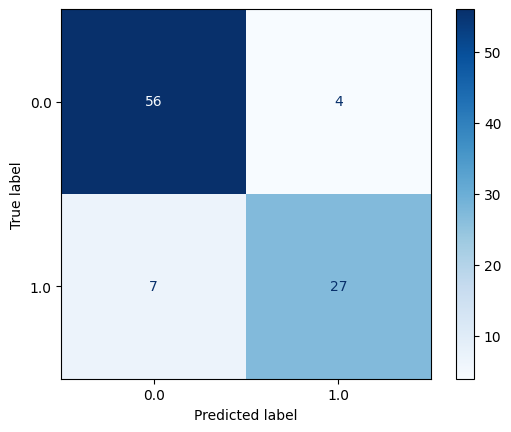

In [ ]:
cm_svm_c_ist = confusion_matrix(y_test_c_ist, y_pred_svm_c_ist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_c_ist, display_labels=model_cirrhosis_svm_ist.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy: ", accuracy_score(y_test_c_ist, y_pred_svm_c_ist))
print("Classification Report:\n", classification_report(y_test_c_ist, y_pred_svm_c_ist))

Accuracy:  0.8829787234042553
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.93      0.91        60
         1.0       0.87      0.79      0.83        34

    accuracy                           0.88        94
   macro avg       0.88      0.86      0.87        94
weighted avg       0.88      0.88      0.88        94



Model działający na tylko cechach istotnych znacząco zwiększył swoje wyniki w porównaniu do tego samego modelu na pełnym zestawie danych. Accuracy wzrosło do 88%, a F1-Score dla klasy 1.0 do 83%. Wskazuje to na bardzo wysoką zdolność modelu do poprawnej klasyfikacji przypadków.

Model jeszcze lepiej radzi sobie z identyfikacją klasy 0, osiągając wysoką precyzję na poziomie 89% oraz bardzo wysoką czułość na poziomie 93%. Liczba przypadków zaklasyfikowanych jako fałszywie pozytywne zmalała do 4.
Wydajność dla klasy 1 wskazała na taką samą liczbę przypadków zidentyfikowanych jako fałszywie negatywne, co w przypadku pierwotnego modelu SVM. Precyzja wyniosła 87%, a czułość 79%. Model wykrywa prawie 80% faktycznych przypadków klasy 1.0.

Wysokie wyniki wskazują na to, że wybrane cechy posiadają kluczową informację, a zależności między tymi cechami, a stanem pacjenta są w dużej mierze liniowo separowalne. Selekcja cech pozwoliła modelowi liniowemu na osiągnięcie pełni potencjału.

### SVM (Support Vector Machine) - kernel = "poly" dla cech istotnych

In [ ]:
# Model SVM - poly z cechami istotnymi
model_cirrhosis_svm_poly_ist = SVC(kernel="poly", degree=2)
model_cirrhosis_svm_poly_ist.fit(X_train_c_ist, y_train_c_ist)
y_pred_svm_c_poly_ist = model_cirrhosis_svm_poly_ist.predict(X_test_c_ist)

Macierz błędów

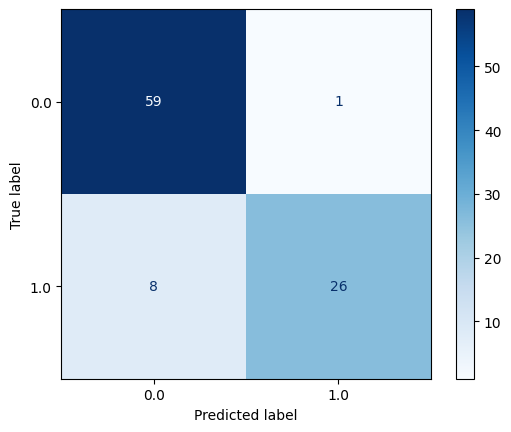

In [ ]:
cm_svm_c_poly_ist = confusion_matrix(y_test_c_ist, y_pred_svm_c_poly_ist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_c_poly_ist, display_labels=model_cirrhosis_svm_poly_ist.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy: ", accuracy_score(y_test_c_ist, y_pred_svm_c_poly_ist))
print("Classification Report:\n", classification_report(y_test_c_ist, y_pred_svm_c_poly_ist))

Accuracy:  0.9042553191489362
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.93        60
         1.0       0.96      0.76      0.85        34

    accuracy                           0.90        94
   macro avg       0.92      0.87      0.89        94
weighted avg       0.91      0.90      0.90        94



Model osiągnął bardzo wysoką dokładność na poziomie 90.4%. Jest to najlepszy wynik spośród wszystkich dotychczas analizowanych modeli na zbiorze df_cirrhosis. Wskazuje na bardzo dobrą zdolność do poprawnej klasyfikacji.

Model jest niemal nieomylny w identyfikacji klasy 0. Osiągnął czułość równą 98% oraz precyzję równą 88%. Liczba fałszywie pozytywnych przypadków wyniosła 1. F1-Score wyniósł 0.93 i jest to bardzo dobry wynik.
Pod względem klasy 1 - model zidentyfikował 8 przypadków niepoprawnie. Jego precyzja wynosi 96% ze względu na minimalną liczbę FP. Czułość wypada najsłabiej i wskazuje, że model poprawnie identyfikuje 76% faktycznych przypadków klasy 1.
Podobnie jak w wielu poprzednich modelach, głównym źródłem błędów pozostają przypadki Fałszywie Negatywne, czyli ominięcie części pacjentów, którzy faktycznie zmarli.

Co najważniejsze, ten wynik sugeruje, że połączenie selekcji cech istotnych z wprowadzeniem specyficznej nieliniowości (za pomocą jądra wielomianowego stopnia 2) okazało się najbardziej efektywnym modelem dla tego zbioru danych.

### SVM (Support Vector Machine) - kernel = "rbf" dla cech istotnych

In [ ]:
# Model SVM - rbf z cechami istotnymi
model_cirrhosis_svm_rbf_ist = SVC(kernel="rbf")
model_cirrhosis_svm_rbf_ist.fit(X_train_c_ist, y_train_c_ist)
y_pred_svm_c_rbf_ist = model_cirrhosis_svm_rbf_ist.predict(X_test_c_ist)

Macierz błędów

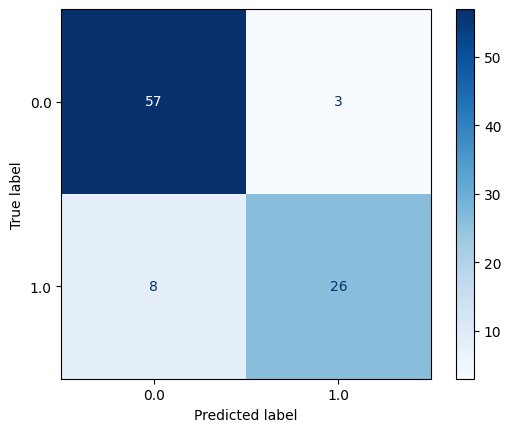

In [ ]:
cm_svm_c_rbf_ist = confusion_matrix(y_test_c_ist, y_pred_svm_c_rbf_ist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_c_rbf_ist, display_labels=model_cirrhosis_svm_rbf_ist.classes_)
disp.plot(cmap='Blues')
plt.show()

Metryki oceny modelu

In [ ]:
print("Accuracy: ", accuracy_score(y_test_c_ist, y_pred_svm_c_rbf_ist))
print("Classification Report:\n", classification_report(y_test_c_ist, y_pred_svm_c_rbf_ist))

Accuracy:  0.8829787234042553
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.95      0.91        60
         1.0       0.90      0.76      0.83        34

    accuracy                           0.88        94
   macro avg       0.89      0.86      0.87        94
weighted avg       0.88      0.88      0.88        94



Model RBF osiągnął również bardzo dobre wyniki. Dokładność wyniosła 0.88, co świadczy o dobrej zdolności do klasyfikacji. Osiągnął on również bardzo dobre wartości precyzji i F1-Score.

Nadal najlepsze wyniki uzyskała identyfikacja klasy 0.0, osiągająć czułość równą 95%. Tylko 3 przypadki były źle sklasyfikowane jako fałszywie pozytywne.
Klasa 1.0 ma niższy poziom czułości, ponieważ jest to obszar z największą ilością błędów. Model poprawnie identyfikuje 76% faktycznych przypadków klasy.
F1-score dla klasy 0 i 1 odpowiednio 91% oraz 83% potwierdza dobry balans precyzji i czułości dla obu klas. Całkwoita liczba błędów jest niska i wynosi 11. Jest to taka sama liczba błędów jak w przypadku modelu SVM z jądrem liniowym

Wyniki tego modelu potwierdzają, że model najlepiej potrafi klasyfikować podane dane dla wybranych cech. Usunęło to szum informacyjny i skupiło klasyfikację na najważniejszych obszarach.
Najlepszy wynik pozostaje jednak dla jądra wielomianowego poly.

### Wykres z podziałem na obszary klasyfikacji SVM dla cech istotnych dla funkcji jądra wielomianowego poly

In [ ]:
pca = PCA(n_components=2)
X_train_c_svm_pca_ist = pca.fit_transform(X_train_c_ist)
X_test_c_svm_pca_ist = pca.transform(X_test_c_ist)

model_cirrhosis_svm_pca_ist = SVC(kernel="poly", degree=2)
model_cirrhosis_svm_pca_ist.fit(X_train_c_svm_pca_ist, y_train_c_ist)

y_pred_svm_c_pca_ist = model_cirrhosis_svm_pca_ist.predict(X_test_c_svm_pca_ist)

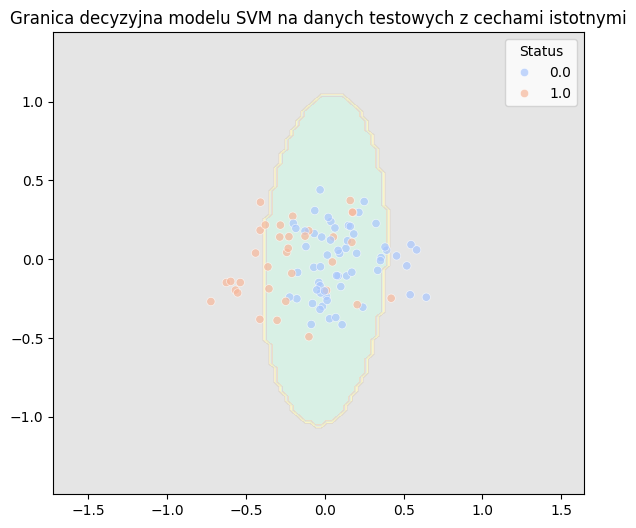

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(model_cirrhosis_svm_pca_ist, X_test_c_svm_pca_ist, response_method="predict", ax=ax, cmap="Pastel2", alpha=0.5)
sns.scatterplot(x=X_test_c_svm_pca_ist[:, 0], y=X_test_c_svm_pca_ist[:, 1], hue=y_test_c_ist, alpha=0.7, ax=ax, palette="coolwarm")
ax.set_aspect("equal")
ax.set_title("Granica decyzyjna modelu SVM na danych testowych z cechami istotnymi")
plt.show()

Granica decyzyjna na wykresie granicy decyzyjnej modelu SVM z jądrem wielomianowym poly stopnia 2 jest wyraźnie nieliniowa i zakrzywiona, przyjmując kształt elipsy. Jest to zgodne z oczekiwaniami dla jądra wielomianowego stopnia 2, które pozwala na tworzenie bardziej złożonych podziałów.

Granica skutecznie oddziela większość punktów obu klas. Duża część punktów obu klas znajduje się w swoim regionie. Najwięcej pomyłek ma klasa 1 - czyli model najgorzej może sobie poradzić z identyfikacją zmarłych pacjentów.

Jednak możemy zaobserwować znaczne wymieszanie się punktów. Dzieje się tak ze względu na redukcję wymiarowości PCA. Dany model nie osiąga tej samej dokładności co model początkowy. Tylko opracowany model, bez redukcji wymiarów i wizualizacji w 2D, jest w stanie przyjąć początkowe metryki.

### Podsumowanie trzech modeli

In [ ]:
#Lista do przechowywania wyników dla każdego modelu
model_results_cirrhosis = []

#Regresja logistyczna (Wszystkie cechy)
model_results_cirrhosis.append({
    'Model': 'Logistic Regression',
    'Features': 'All',
    'Accuracy': accuracy_c,
    'Precision': precision_c,
    'Recall': recall_c,
    'F1-Score': f1_c
})

#Regresja logistyczna (Wybrane cechy - RFECV)
model_results_cirrhosis.append({
    'Model': 'Logistic Regression',
    'Features': 'RFECV',
    'Accuracy': accuracy_c_ist,
    'Precision': precision_c_ist,
    'Recall': recall_c_ist,
    'F1-Score': f1_c_ist
})

#KNN (k=2, Wszystkie Cechy)
model_results_cirrhosis.append({
    'Model': 'KNN (k=2)',
    'Features': 'All',
    'Accuracy': accuracy_score(y_test_c, y_pred_c_knn),
    'Precision': precision_score(y_test_c, y_pred_c_knn),
    'Recall': recall_score(y_test_c, y_pred_c_knn),
    'F1-Score': f1_score(y_test_c, y_pred_c_knn)
})

#KNN (k=5, Wszystkie Cechy)
model_results_cirrhosis.append({
    'Model': 'KNN (k=5)',
    'Features': 'All',
    'Accuracy': accuracy_score(y_test_c, y_pred_c_knn_best),
    'Precision': precision_score(y_test_c, y_pred_c_knn_best),
    'Recall': recall_score(y_test_c, y_pred_c_knn_best),
    'F1-Score': f1_score(y_test_c, y_pred_c_knn_best)
})

#KNN (k=2, Wybrane Cechy - RFECV)
model_results_cirrhosis.append({
    'Model': 'KNN (k=2)',
    'Features': 'RFECV',
    'Accuracy': accuracy_score(y_test_c_ist, y_pred_c_knn_ist),
    'Precision': precision_score(y_test_c_ist, y_pred_c_knn_ist),
    'Recall': recall_score(y_test_c_ist, y_pred_c_knn_ist),
    'F1-Score': f1_score(y_test_c_ist, y_pred_c_knn_ist)
})

#KNN (k=7, Wybrane Cechy - RFECV)
model_results_cirrhosis.append({
    'Model': 'KNN (k=7)',
    'Features': 'RFECV',
    'Accuracy': accuracy_score(y_test_c_ist, y_pred_c_knn_pca_ist),
    'Precision': precision_score(y_test_c_ist, y_pred_c_knn_pca_ist),
    'Recall': recall_score(y_test_c_ist, y_pred_c_knn_pca_ist),
    'F1-Score': f1_score(y_test_c_ist, y_pred_c_knn_pca_ist)
})

#SVM (Linear, Wszystkie Cechy)
model_results_cirrhosis.append({
    'Model': 'SVM (Linear)',
    'Features': 'All',
    'Accuracy': accuracy_score(y_test_c, y_pred_svm_c_linear),
    'Precision': precision_score(y_test_c, y_pred_svm_c_linear),
    'Recall': recall_score(y_test_c, y_pred_svm_c_linear),
    'F1-Score': f1_score(y_test_c, y_pred_svm_c_linear)
})

#SVM (Poly, Wszystkie Cechy)
model_results_cirrhosis.append({
    'Model': 'SVM (Poly degree = 2)',
    'Features': 'All',
    'Accuracy': accuracy_score(y_test_c, y_pred_svm_c_poly),
    'Precision': precision_score(y_test_c, y_pred_svm_c_poly),
    'Recall': recall_score(y_test_c, y_pred_svm_c_poly),
    'F1-Score': f1_score(y_test_c, y_pred_svm_c_poly)
})

#SVM (RBF, Wszystkie Cechy)
model_results_cirrhosis.append({
    'Model': 'SVM (RBF)',
    'Features': 'All',
    'Accuracy': accuracy_score(y_test_c, y_pred_svm_c_rbf),
    'Precision': precision_score(y_test_c, y_pred_svm_c_rbf),
    'Recall': recall_score(y_test_c, y_pred_svm_c_rbf),
    'F1-Score': f1_score(y_test_c, y_pred_svm_c_rbf)
})

#SVM (Linear, Wybrane Cechy - RFECV)
model_results_cirrhosis.append({
    'Model': 'SVM (Linear)',
    'Features': 'RFECV',
    'Accuracy': accuracy_score(y_test_c_ist, y_pred_svm_c_ist),
    'Precision': precision_score(y_test_c_ist, y_pred_svm_c_ist),
    'Recall': recall_score(y_test_c_ist, y_pred_svm_c_ist),
    'F1-Score': f1_score(y_test_c_ist, y_pred_svm_c_ist)
})

#SVM (Poly, Wybrane Cechy - RFECV)
model_results_cirrhosis.append({
    'Model': 'SVM (Poly degree = 2)',
    'Features': 'RFECV',
    'Accuracy': accuracy_score(y_test_c_ist, y_pred_svm_c_poly_ist),
    'Precision': precision_score(y_test_c_ist, y_pred_svm_c_poly_ist),
    'Recall': recall_score(y_test_c_ist, y_pred_svm_c_poly_ist),
    'F1-Score': f1_score(y_test_c_ist, y_pred_svm_c_poly_ist)
})

#SVM (RBF, Wybrane Cechy - RFECV)
model_results_cirrhosis.append({
    'Model': 'SVM (RBF)',
    'Features': 'RFECV',
    'Accuracy': accuracy_score(y_test_c_ist, y_pred_svm_c_rbf_ist),
    'Precision': precision_score(y_test_c_ist, y_pred_svm_c_rbf_ist),
    'Recall': recall_score(y_test_c_ist, y_pred_svm_c_rbf_ist),
    'F1-Score': f1_score(y_test_c_ist, y_pred_svm_c_rbf_ist)
})

#Zapisanie wyników do DataFrame
summary_df_cirrhosis = pd.DataFrame(model_results_cirrhosis)
pd.options.display.float_format = '{:.4f}'.format
print(summary_df_cirrhosis)

                    Model Features  Accuracy  Precision  Recall  F1-Score
0     Logistic Regression      All    0.8298     0.7647  0.7647    0.7647
1     Logistic Regression    RFECV    0.8830     0.9259  0.7353    0.8197
2               KNN (k=2)      All    0.7979     0.7778  0.6176    0.6885
3               KNN (k=5)      All    0.7447     0.6389  0.6765    0.6571
4               KNN (k=2)    RFECV    0.8617     0.8889  0.7059    0.7869
5               KNN (k=7)    RFECV    0.8298     0.8462  0.6471    0.7333
6            SVM (Linear)      All    0.8404     0.7879  0.7647    0.7761
7   SVM (Poly degree = 2)      All    0.8298     0.7500  0.7941    0.7714
8               SVM (RBF)      All    0.7766     0.6585  0.7941    0.7200
9            SVM (Linear)    RFECV    0.8830     0.8710  0.7941    0.8308
10  SVM (Poly degree = 2)    RFECV    0.9043     0.9630  0.7647    0.8525
11              SVM (RBF)    RFECV    0.8830     0.8966  0.7647    0.8254


Na podstawie przedstawionej tabeli wyników możemy podsumować, który z modeli najlepiej wypadł przy dopasowywaniu i klasyfikacji danych.

Najlepszym modelem okazał się model SVM z jądrem wielomianowym poly o stopniu 2 na cechach istotnych. Osiągnął najwyższą dokładność 90.43% oraz najwyższy F1-Score 85.25% Jego precyzja 96.30% oznacza, że gdy przewiduje, że pacjent zmarł, jest to niezwykle wiarygodne i generuje minimalną liczbę fałszywie pozytywnych przypisań. Ma on też wysoką (lecz nie najwyższą) czułość 77%.

Bardzo dobrymi modelami były również SVM z jądrem liniowym na cechach istotnych oraz SVM z jądrem RBF na cechach istotnych. Każdy z tych modeli przyjmował dokładność 88%. Natomiast model liniowy miał nieco wyższą czułość 79%, co oznacza, że wykrył stosunkowo lepiej przypadki zgonów. Dzieje się to kosztem niższej precyzji 87%.
Model RBF miał dobrą precyzję i czułość i był bardzo zbliżony do modelu z jądrem wielomianowym. Precyzja zaważyła na niższym poziomie dokładności.

Oprócz modeli SVM, które z cechami istotnymi dały bardzo wiarygodne modele danych, początkowa klasyfikacja regresją logistyczną na danych istotnych również przyniosła dobre wyniki. Ten model miał dokładność 88% oraz F1-Score 82%. Wyróżnia się wyjątkowo wysoką precyzją 93%, ale ma najniższą czułość spośród typowanych modeli.

Zastosowanie selekcji cech istotnych (RFECV) drastycznie poprawiło wyniki wszystkich algorytmów. Modele trenowane tylko na istotnych cechach RFECV dawały wyższe wyniki niż początkowe modele na całym zbiorze danych.

Modele KNN (szczególnie na pełnym zbiorze) wykazały wyraźnie niższą skuteczność i nie są przystosowane do tego zbioru.

Najlepsze modele osiągają bardzo wysoką precyzję kosztem nieco niższej czułości. Model SVM z jądrem liniowym daje stabilność i balans z wyższym poziomem Recall.